#Uploading Files

In [1]:
import pandas as pd
from google.colab import files

# Upload your file
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Load data without parsing dates first
data = pd.read_csv(file_name)
print("Columns in your CSV:", data.columns.tolist())

Saving Daily RW to test python.csv to Daily RW to test python.csv
Saving detected_market_phases.csv to detected_market_phases.csv
Saving DTB3.csv to DTB3.csv
Columns in your CSV: ['Date ', 'SP500 ', 'BTC', 'ETH']


# 20.08.25( pooled bull market analysis)

In [9]:
# Final Corrected Code for Hypothesis II Analysis - POOLED ANALYSIS FOCUS


import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re
import os

# --- 1. CONFIGURATION & PARAMETERS ---

# File paths (ensure these files are in the same directory as the script or provide full paths)
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'

# Output file names for the results
POOLED_RESULTS_EXCEL_FILE = 'pooled_analysis_results_final.xlsx'
# SUBPERIOD_RESULTS_EXCEL_FILE = 'subperiod_analysis_results_final.xlsx'  # We'll focus on pooled first

# Simulation Parameters
TRANSACTION_COST = 0.0025  # 0.25%
REBALANCE_THRESHOLD = 0.01 # Absolute 1% deviation for fixed-weight portfolios
ANNUAL_TRADING_DAYS = 252

# Optimization Parameters
LOOKBACK_WINDOW = 252  # Days for rolling optimization
# REBALANCE_FREQUENCY is now passed as a parameter

# ADDED: Portfolio Constraints (0% min allocation, 10% max per crypto)
MIN_ASSET_ALLOCATION = 0.00   # 0% minimum allocation
MAX_EQUITY_ALLOCATION = 0.90  # 90% max for SP500
MAX_CRYPTO_ALLOCATION = 0.10  # 10% max per crypto

# NEW: Rebalancing frequencies to test
REBALANCE_FREQUENCIES_TO_TEST = {
    'Monthly': 'ME',
    'Quarterly': 'QE'
}

# --- 2. DATA LOADING AND PREPARATION ---

def load_and_prepare_data(price_file, rf_file, phases_file):
    """Loads, merges, and prepares all necessary data for the analysis."""
    print("Loading and preparing data...")

    try:
        # Load data files and clean column names for robustness
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]

        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]

        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]

    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure all CSV files are in the correct directory.")
        return None, None

    # Standardize Date Columns to datetime objects
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)

        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Could not find a 'Date' or 'DATE' column in the risk-free rate CSV file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: A required column was not found. Please check your CSV files. Details: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Could not find the required '{cleaned_rf_col_name}' column in your risk-free rate file.")

    # Merge dataframes
    df = pd.merge(price_df, rf_df, on='Date', how='left')
    # --- FIX for FutureWarning ---
    # Changed from inplace=True to direct assignment to avoid the warning.
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    # Calculate Daily Returns and add the risk-free rate
    returns_df = df[['SP500', 'BTC', 'ETH']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name]
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- 3. PERFORMANCE METRIC FUNCTIONS ---

def calculate_annualized_return(returns):
    """Calculates the geometric annualized return for accurate compounded growth representation."""
    if returns.empty or len(returns) == 0:
        return 0.0
    num_years = len(returns) / ANNUAL_TRADING_DAYS
    cumulative_return = (1 + returns).prod()
    return (cumulative_return ** (1 / num_years)) - 1

# FIXED: Sharpe Ratio calculation with correct annualization
def calculate_sharpe_ratio(returns, rf_rate):
    """Calculates the annualized Sharpe Ratio using a time-varying risk-free rate."""
    if returns.empty or returns.std() == 0:
        return 0.0
    excess_returns = returns - rf_rate
    # Correct annualization: multiply return by days, volatility by sqrt(days)
    return (excess_returns.mean() * ANNUAL_TRADING_DAYS) / (excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS))

def calculate_sortino_ratio(returns, mar=0):
    if returns.empty:
        return 0.0

    # Precise MAR conversion
    daily_mar = (1 + mar)**(1/ANNUAL_TRADING_DAYS) - 1

    # Full-series downside deviation
    downside_diff = np.maximum(daily_mar - returns, 0)
    downside_var = np.mean(downside_diff ** 2)
    downside_std = np.sqrt(downside_var) * np.sqrt(ANNUAL_TRADING_DAYS)

    if downside_std == 0 or pd.isna(downside_std):
        return 0.0

    annualized_ret = calculate_annualized_return(returns)
    return (annualized_ret - mar) / downside_std

def calculate_cvar_95(returns):
    """Calculates the 95% Conditional Value-at-Risk (CVaR)."""
    if returns.empty:
        return 0.0
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()
    return -cvar_95  # Return as a positive value representing loss

# --- 4. PORTFOLIO OPTIMIZATION & SIMULATION ---

def portfolio_variance(weights, cov_matrix):
    """Helper function to calculate portfolio variance for MVP optimization."""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf_rate):
    """Calculates negative Sharpe for Tangency Portfolio optimization. Correctly uses excess returns."""
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_std == 0:
        return 0
    excess_return = portfolio_return - rf_rate
    return -(excess_return / portfolio_std) * np.sqrt(ANNUAL_TRADING_DAYS)

def get_optimized_portfolio(mean_returns, cov_matrix, rf_rate, opt_type):
    """Finds optimal weights with institutional constraints"""
    num_assets = len(mean_returns)
    args = (cov_matrix,) if opt_type == 'MVP' else (mean_returns, cov_matrix, rf_rate)
    target_func = portfolio_variance if opt_type == 'MVP' else negative_sharpe_ratio

    # Define custom bounds for each asset (0% min, 10% crypto max)
    bounds = [
        (MIN_ASSET_ALLOCATION, MAX_EQUITY_ALLOCATION),  # SP500 bounds (0-90%)
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION),  # BTC bounds (0-10%)
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION)   # ETH bounds (0-10%)
    ]

    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Must sum to 100%
    )

    # SAFE INITIAL WEIGHTS: Within constraints (SP500:90%, BTC:10%, ETH:10% -> normalized)
    total = MAX_EQUITY_ALLOCATION + MAX_CRYPTO_ALLOCATION + MAX_CRYPTO_ALLOCATION
    if total > 0:
        initial_weights = [
            MAX_EQUITY_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total
        ]
    else:
        initial_weights = [1.0, 0.0, 0.0]  # Fallback

    result = minimize(
        target_func,
        initial_weights,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000, 'ftol': 1e-9}  # Increase precision
    )

    if result.success:
        # Normalize weights to sum exactly to 1
        normalized_weights = result.x / np.sum(result.x)
        return normalized_weights
    else:
        print(f"Optimization failed: {result.message}")
        print(f"Trying backup optimization with relaxed constraints...")
        # Fallback method
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
        result = minimize(
            target_func,
            initial_weights,
            args=args,
            method='SLSQP',
            constraints=constraints
        )
        if result.success:
            return result.x / np.sum(result.x)
        return initial_weights  # Return initial weights if optimization fails

def simulate_fixed_weight_portfolio(returns_df, bull_market_mask, weights, threshold, cost):
    """Simulates a fixed-weight portfolio with threshold rebalancing and costs."""
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return pd.Series()

    sim_returns['is_period_start'] = ~sim_returns.index.to_series().diff().dt.days.eq(1)
    portfolio_values = [1.0]
    current_weights = weights.copy()
    asset_cols = list(weights.keys())

    for i in range(len(sim_returns)):
        daily_return = sum(current_weights[asset] * sim_returns[asset].iloc[i] for asset in asset_cols)
        portfolio_values.append(portfolio_values[-1] * (1 + daily_return))

        # Avoid division by zero if portfolio value drops to zero
        if portfolio_values[-1] == 0:
            market_weights = weights.copy()
        else:
            market_weights = {
                asset: (current_weights[asset] * (1 + sim_returns[asset].iloc[i])) / (1 + daily_return)
                for asset in asset_cols
            }

        if any(abs(market_weights[asset] - weights[asset]) > threshold for asset in asset_cols) or sim_returns['is_period_start'].iloc[i]:
            turnover = sum(abs(market_weights[asset] - weights[asset]) for asset in asset_cols) / 2
            portfolio_values[-1] *= (1 - (turnover * cost))
            current_weights = weights.copy()
        else:
            current_weights = market_weights

    return pd.Series(portfolio_values[1:], index=sim_returns.index).pct_change().dropna()

def simulate_optimized_portfolio(full_returns_df, bull_market_mask, lookback, frequency, opt_type, cost):
    """Simulates a dynamically optimized portfolio with rebalancing and costs."""
    sim_dates = full_returns_df[bull_market_mask].index
    if sim_dates.empty:
        return pd.Series(), pd.DataFrame(), 0.0  # Return 0 turnover if no dates

    # NEW: Create a list of only the rebalancing dates
    rebalance_dates = pd.date_range(sim_dates.min(), sim_dates.max(), freq=frequency).normalize()
    rebalance_dates = [d for d in rebalance_dates if d in sim_dates]

    # NEW: Initialize turnover tracking
    total_turnover = 0.0

    portfolio_returns = []
    weights_history = []
    # Start with SP500 only
    current_weights = np.array([1.0, 0.0, 0.0])
    last_rebalance_date = sim_dates[0] - pd.DateOffset(days=1)

    # NEW: Loop through all dates in the simulation period
    for date in sim_dates:
        daily_rebalance = False

        # Check if today is a rebalancing day
        if date in rebalance_dates and date > last_rebalance_date:
            lookback_start = date - pd.DateOffset(days=lookback)
            # Ensure lookback period doesn't extend before available data
            if lookback_start < full_returns_df.index[0]:
                lookback_start = full_returns_df.index[0]

            lookback_data = full_returns_df.loc[lookback_start:date-pd.DateOffset(days=1)]

            if len(lookback_data) > 10:  # Require minimum data points
                asset_returns = lookback_data[['SP500', 'BTC', 'ETH']]
                mean_returns = asset_returns.mean()
                cov_matrix = asset_returns.cov()
                rf_lookback = lookback_data['RF_Rate'].mean()
                new_weights = get_optimized_portfolio(mean_returns, cov_matrix, rf_lookback, opt_type)

                # NEW: Calculate and accumulate turnover
                turnover = np.sum(np.abs(new_weights - current_weights)) / 2
                total_turnover += turnover
                rebalance_cost = turnover * cost

                # Apply cost to the portfolio
                if portfolio_returns:
                    portfolio_returns[-1] -= rebalance_cost

                current_weights = new_weights
                last_rebalance_date = date
                daily_rebalance = True
                weights_history.append({
                    'Date': date,
                    'SP500_w': current_weights[0],
                    'BTC_w': current_weights[1],
                    'ETH_w': current_weights[2]
                })

        # Calculate daily portfolio return
        daily_asset_returns = full_returns_df.loc[date, ['SP500', 'BTC', 'ETH']].values
        daily_port_return = np.dot(current_weights, daily_asset_returns)
        portfolio_returns.append(daily_port_return)

    return pd.Series(portfolio_returns, index=sim_dates).dropna(), pd.DataFrame(weights_history).set_index('Date'), total_turnover

# --- 5. MAIN ANALYSIS FUNCTIONS ---

def run_pooled_analysis(full_returns, phases, rebalance_freq='ME'):
    """
    Runs the pooled analysis for a specific rebalancing frequency.
    Returns results and weights dataframes.
    """
    print(f"\n--- Starting Pooled Bull Market Analysis ({rebalance_freq}) ---")
    bull_phases = phases[phases['Phase'] == 'Bull']
    mask = pd.Series(False, index=full_returns.index)
    for _, row in bull_phases.iterrows():
        mask.loc[row['Start']:row['End']] = True

    rf_rate = full_returns.loc[mask, 'RF_Rate']
    portfolios_to_test = {
        '100% SP500': {'SP500': 1.00, 'BTC': 0.000, 'ETH': 0.000},
        '99% SP500, 1% BTC': {'SP500': 0.99, 'BTC': 0.01, 'ETH': 0.00},
        '98% SP500, 2% BTC': {'SP500': 0.98, 'BTC': 0.02, 'ETH': 0.00},
        '97% SP500, 3% BTC': {'SP500': 0.97, 'BTC': 0.03, 'ETH': 0.00},
        '96% SP500, 4% BTC': {'SP500': 0.96, 'BTC': 0.04, 'ETH': 0.00},
        '95% SP500, 5% BTC': {'SP500': 0.95, 'BTC': 0.05, 'ETH': 0.00},
        '99% SP500, 1% ETH': {'SP500': 0.99, 'BTC': 0.00, 'ETH': 0.01},
        '98% SP500, 2% ETH': {'SP500': 0.98, 'BTC': 0.00, 'ETH': 0.02},
        '97% SP500, 3% ETH': {'SP500': 0.97, 'BTC': 0.00, 'ETH': 0.03},
        '96% SP500, 4% ETH': {'SP500': 0.96, 'BTC': 0.00, 'ETH': 0.04},
        '95% SP500, 5% ETH': {'SP500': 0.95, 'BTC': 0.00, 'ETH': 0.05},
        '99% SP500, 0.5% BTC, 0.5% ETH': {'SP500': 0.99, 'BTC': 0.005, 'ETH': 0.005},
        '98% SP500, 1% BTC, 1% ETH':   {'SP500': 0.98, 'BTC': 0.010, 'ETH': 0.010},
        '97% SP500, 1.5% BTC, 1.5% ETH': {'SP500': 0.97, 'BTC': 0.015, 'ETH': 0.015},
        '96% SP500, 2% BTC, 2% ETH':   {'SP500': 0.96, 'BTC': 0.020, 'ETH': 0.020},
        '95% SP500, 2.5% BTC, 2.5% ETH': {'SP500': 0.95, 'BTC': 0.025, 'ETH': 0.025}
    }

    results = []
    weights_to_save = {}

    print("Simulating fixed-weight portfolios...")
    for name, weights in portfolios_to_test.items():
        port_returns = simulate_fixed_weight_portfolio(
            full_returns, mask, weights, REBALANCE_THRESHOLD, TRANSACTION_COST
        )
        if not port_returns.empty:
            results.append({
                'Portfolio': name,
                'Rebalancing Frequency': 'N/A (Fixed)',
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns),
                'Total Turnover': 0.0  # Fixed weights have no optimization turnover
            })

    print("Simulating dynamically optimized portfolios...")
    for opt_type in ['MVP', 'Tangency']:
        port_returns, weights_df, turnover = simulate_optimized_portfolio(
            full_returns, mask, LOOKBACK_WINDOW, rebalance_freq, opt_type, TRANSACTION_COST
        )
        if not port_returns.empty:
            freq_name = [k for k, v in REBALANCE_FREQUENCIES_TO_TEST.items() if v == rebalance_freq][0]
            results.append({
                'Portfolio': opt_type,
                'Rebalancing Frequency': freq_name,
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns),
                'Total Turnover': turnover
            })
            if not weights_df.empty:
                weights_to_save[f'{opt_type}_{freq_name}_Weights'] = weights_df

    results_df = pd.DataFrame(results)
    print(f"\n--- Pooled Analysis Results ({rebalance_freq}) ---")
    print(results_df.to_string())
    return results_df, weights_to_save

def run_comprehensive_pooled_analysis(full_returns, phases):
    """
    Runs the pooled analysis for all rebalancing frequencies and compiles results.
    """
    all_results = []
    all_weights = {}

    # Run analysis for each frequency
    for freq_name, freq_code in REBALANCE_FREQUENCIES_TO_TEST.items():
        results_df, weights_dict = run_pooled_analysis(full_returns, phases, freq_code)
        all_results.append(results_df)

        # Store weights with frequency in key
        for key, df in weights_dict.items():
            all_weights[key] = df

    # Combine all results
    final_results = pd.concat(all_results, ignore_index=True)

    return final_results, all_weights

# --- Main Execution Block ---
if __name__ == '__main__':
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run comprehensive pooled analysis
        pooled_results_df, pooled_weights = run_comprehensive_pooled_analysis(returns, market_phases)

        # Save to Excel with multiple sheets
        with pd.ExcelWriter(POOLED_RESULTS_EXCEL_FILE, engine='openpyxl') as writer:
            # Save main results
            pooled_results_df.to_excel(writer, sheet_name='All_Performance_Metrics', index=False)

            # Create separate sheets for rebalancing comparison
            mvp_results = pooled_results_df[pooled_results_df['Portfolio'] == 'MVP']
            tangency_results = pooled_results_df[pooled_results_df['Portfolio'] == 'Tangency']

            mvp_results.to_excel(writer, sheet_name='MVP_Rebalancing_Comparison', index=False)
            tangency_results.to_excel(writer, sheet_name='Tangency_Rebalancing_Comparison', index=False)

            # Save fixed-weight results separately
            fixed_results = pooled_results_df[pooled_results_df['Rebalancing Frequency'] == 'N/A (Fixed)']
            fixed_results.to_excel(writer, sheet_name='Fixed_Weight_Portfolios', index=False)

            # Save weights data
            for sheet_name, df in pooled_weights.items():
                # Shorten sheet name if needed (Excel has 31-character limit)
                short_name = sheet_name[:31]
                df.to_excel(writer, sheet_name=short_name)

        print(f"\n✅ Comprehensive pooled analysis results exported to '{POOLED_RESULTS_EXCEL_FILE}'")
        print("Sheets created:")
        print("- All_Performance_Metrics: Complete results for all portfolios")
        print("- MVP_Rebalancing_Comparison: MVP results across frequencies")
        print("- Tangency_Rebalancing_Comparison: Tangency results across frequencies")
        print("- Fixed_Weight_Portfolios: All fixed-weight strategy results")
        print("- Weight sheets for each portfolio type and frequency")

Loading and preparing data...
Data preparation complete.

--- Starting Pooled Bull Market Analysis (ME) ---
Simulating fixed-weight portfolios...
Simulating dynamically optimized portfolios...

--- Pooled Analysis Results (ME) ---
                        Portfolio Rebalancing Frequency  Annualized Return  Sharpe Ratio  Sortino Ratio  CVaR 95%  Total Turnover
0                      100% SP500           N/A (Fixed)           0.332176      1.720163       3.274267  0.021905        0.000000
1               99% SP500, 1% BTC           N/A (Fixed)           0.342110      1.769918       3.385982  0.021831        0.000000
2               98% SP500, 2% BTC           N/A (Fixed)           0.352065      1.817075       3.492752  0.021766        0.000000
3               97% SP500, 3% BTC           N/A (Fixed)           0.362041      1.861417       3.594395  0.021717        0.000000
4               96% SP500, 4% BTC           N/A (Fixed)           0.372037      1.902762       3.690430  0.021703      

#20.08.25 ( subperiod )

In [13]:
# COMPLETE CODE FOR SUBPERIOD ANALYSIS ONLY
# Structured like your pooled analysis for consistency

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re

# --- 1. CONFIGURATION & PARAMETERS ---

# File paths (ensure these files are in the same directory as the script or provide full paths)
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'

# Output file name for the results
SUBPERIOD_RESULTS_EXCEL_FILE = 'subperiod_analysis_results.xlsx'

# Simulation Parameters
TRANSACTION_COST = 0.0025  # 0.25%
REBALANCE_THRESHOLD = 0.01 # Absolute 1% deviation for fixed-weight portfolios
ANNUAL_TRADING_DAYS = 252

# Optimization Parameters
LOOKBACK_WINDOW = 252  # Days for rolling optimization
REBALANCE_FREQ = 'QE'   # Quarterly rebalancing for subperiod analysis

# Portfolio Constraints (0% min allocation, 10% max per crypto)
MIN_ASSET_ALLOCATION = 0.00   # 0% minimum allocation
MAX_EQUITY_ALLOCATION = 0.90  # 90% max for SP500
MAX_CRYPTO_ALLOCATION = 0.10  # 10% max per crypto

# --- 2. DATA LOADING AND PREPARATION ---

def load_and_prepare_data(price_file, rf_file, phases_file):
    """Loads, merges, and prepares all necessary data for the analysis."""
    print("Loading and preparing data...")

    try:
        # Load data files and clean column names for robustness
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]

        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]

        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]

    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure all CSV files are in the correct directory.")
        return None, None

    # Standardize Date Columns to datetime objects
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)

        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Could not find a 'Date' or 'DATE' column in the risk-free rate CSV file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: A required column was not found. Please check your CSV files. Details: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Could not find the required '{cleaned_rf_col_name}' column in your risk-free rate file.")

    # Merge dataframes
    df = pd.merge(price_df, rf_df, on='Date', how='left')
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    # Calculate Daily Returns and add the risk-free rate
    returns_df = df[['SP500', 'BTC', 'ETH']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name]
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- 3. PERFORMANCE METRIC FUNCTIONS ---

def calculate_annualized_return(returns):
    """Calculates the geometric annualized return for accurate compounded growth representation."""
    if returns.empty or len(returns) == 0:
        return 0.0
    num_years = len(returns) / ANNUAL_TRADING_DAYS
    cumulative_return = (1 + returns).prod()
    return (cumulative_return ** (1 / num_years)) - 1

def calculate_sharpe_ratio(returns, rf_rate):
    """Calculates the annualized Sharpe Ratio using a time-varying risk-free rate."""
    if returns.empty or returns.std() == 0:
        return 0.0
    excess_returns = returns - rf_rate
    return (excess_returns.mean() * ANNUAL_TRADING_DAYS) / (excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS))

def calculate_sortino_ratio(returns, mar=0):
    if returns.empty:
        return 0.0
    daily_mar = (1 + mar)**(1/ANNUAL_TRADING_DAYS) - 1
    downside_diff = np.maximum(daily_mar - returns, 0)
    downside_var = np.mean(downside_diff ** 2)
    downside_std = np.sqrt(downside_var) * np.sqrt(ANNUAL_TRADING_DAYS)

    if downside_std == 0 or pd.isna(downside_std):
        return 0.0

    annualized_ret = calculate_annualized_return(returns)
    return (annualized_ret - mar) / downside_std

def calculate_cvar_95(returns):
    """Calculates the 95% Conditional Value-at-Risk (CVaR)."""
    if returns.empty:
        return 0.0
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()
    return -cvar_95

# --- 4. PORTFOLIO OPTIMIZATION & SIMULATION ---

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf_rate):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_std == 0:
        return 0
    excess_return = portfolio_return - rf_rate
    return -(excess_return / portfolio_std) * np.sqrt(ANNUAL_TRADING_DAYS)

def get_optimized_portfolio(mean_returns, cov_matrix, rf_rate, opt_type):
    num_assets = len(mean_returns)
    args = (cov_matrix,) if opt_type == 'MVP' else (mean_returns, cov_matrix, rf_rate)
    target_func = portfolio_variance if opt_type == 'MVP' else negative_sharpe_ratio

    bounds = [
        (MIN_ASSET_ALLOCATION, MAX_EQUITY_ALLOCATION),
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION),
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION)
    ]

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)

    total = MAX_EQUITY_ALLOCATION + MAX_CRYPTO_ALLOCATION + MAX_CRYPTO_ALLOCATION
    if total > 0:
        initial_weights = [MAX_EQUITY_ALLOCATION / total, MAX_CRYPTO_ALLOCATION / total, MAX_CRYPTO_ALLOCATION / total]
    else:
        initial_weights = [1.0, 0.0, 0.0]

    result = minimize(target_func, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        return result.x / np.sum(result.x)
    else:
        return initial_weights

def simulate_fixed_weight_portfolio(returns_df, bull_market_mask, weights, threshold, cost):
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return pd.Series()

    portfolio_values = [1.0]
    current_weights = weights.copy()
    asset_cols = list(weights.keys())

    for i in range(len(sim_returns)):
        daily_return = sum(current_weights[asset] * sim_returns[asset].iloc[i] for asset in asset_cols)
        portfolio_values.append(portfolio_values[-1] * (1 + daily_return))

        if portfolio_values[-1] == 0:
            market_weights = weights.copy()
        else:
            market_weights = {asset: (current_weights[asset] * (1 + sim_returns[asset].iloc[i])) / (1 + daily_return) for asset in asset_cols}

        if any(abs(market_weights[asset] - weights[asset]) > threshold for asset in asset_cols):
            turnover = sum(abs(market_weights[asset] - weights[asset]) for asset in asset_cols) / 2
            portfolio_values[-1] *= (1 - (turnover * cost))
            current_weights = weights.copy()
        else:
            current_weights = market_weights

    return pd.Series(portfolio_values[1:], index=sim_returns.index).pct_change().dropna()

def simulate_optimized_portfolio(full_returns_df, bull_market_mask, lookback, frequency, opt_type, cost):
    sim_dates = full_returns_df[bull_market_mask].index
    if sim_dates.empty:
        return pd.Series(), pd.DataFrame(), 0.0

    rebalance_dates = pd.date_range(sim_dates.min(), sim_dates.max(), freq=frequency).normalize()
    rebalance_dates = [d for d in rebalance_dates if d in sim_dates]

    total_turnover = 0.0
    portfolio_returns = []
    weights_history = []
    current_weights = np.array([1.0, 0.0, 0.0])
    last_rebalance_date = sim_dates[0] - pd.DateOffset(days=1)

    for date in sim_dates:
        if date in rebalance_dates and date > last_rebalance_date:
            lookback_start = date - pd.DateOffset(days=lookback)
            if lookback_start < full_returns_df.index[0]:
                lookback_start = full_returns_df.index[0]

            lookback_data = full_returns_df.loc[lookback_start:date-pd.DateOffset(days=1)]

            if len(lookback_data) > 10:
                asset_returns = lookback_data[['SP500', 'BTC', 'ETH']]
                mean_returns = asset_returns.mean()
                cov_matrix = asset_returns.cov()
                rf_lookback = lookback_data['RF_Rate'].mean()
                new_weights = get_optimized_portfolio(mean_returns, cov_matrix, rf_lookback, opt_type)

                turnover = np.sum(np.abs(new_weights - current_weights)) / 2
                total_turnover += turnover
                rebalance_cost = turnover * cost

                if portfolio_returns:
                    portfolio_returns[-1] -= rebalance_cost

                current_weights = new_weights
                last_rebalance_date = date
                weights_history.append({'Date': date, 'SP500_w': current_weights[0], 'BTC_w': current_weights[1], 'ETH_w': current_weights[2]})

        daily_asset_returns = full_returns_df.loc[date, ['SP500', 'BTC', 'ETH']].values
        daily_port_return = np.dot(current_weights, daily_asset_returns)
        portfolio_returns.append(daily_port_return)

    return pd.Series(portfolio_returns, index=sim_dates).dropna(), pd.DataFrame(weights_history).set_index('Date'), total_turnover

# --- 5. SUBPERIOD ANALYSIS FUNCTION ---

def run_subperiod_analysis(full_returns, phases):
    """
    Runs comprehensive analysis on individual bull market subperiods.
    Returns results in the same format as pooled analysis.
    """
    print("=" * 60)
    print("STARTING SUBPERIOD ANALYSIS")
    print("=" * 60)

    bull_phases = phases[phases['Phase'] == 'Bull'].reset_index(drop=True)
    all_results = []

    for i, phase_row in bull_phases.iterrows():
        phase_name = f"Bull Phase {i+1}"
        print(f"\nAnalyzing {phase_name}...")

        mask = (full_returns.index >= phase_row['Start']) & (full_returns.index <= phase_row['End'])
        if mask.sum() == 0:
            continue

        rf_rate = full_returns.loc[mask, 'RF_Rate']

        # Test all portfolios like in pooled analysis
        portfolios_to_test = {
            '100% SP500': {'SP500': 1.00, 'BTC': 0.000, 'ETH': 0.000},
            '99% SP500, 1% BTC': {'SP500': 0.99, 'BTC': 0.01, 'ETH': 0.00},
            '98% SP500, 2% BTC': {'SP500': 0.98, 'BTC': 0.02, 'ETH': 0.00},
            '97% SP500, 3% BTC': {'SP500': 0.97, 'BTC': 0.03, 'ETH': 0.00},
            '96% SP500, 4% BTC': {'SP500': 0.96, 'BTC': 0.04, 'ETH': 0.00},
            '95% SP500, 5% BTC': {'SP500': 0.95, 'BTC': 0.05, 'ETH': 0.00},
            '99% SP500, 1% ETH': {'SP500': 0.99, 'BTC': 0.00, 'ETH': 0.01},
            '98% SP500, 2% ETH': {'SP500': 0.98, 'BTC': 0.00, 'ETH': 0.02},
            '97% SP500, 3% ETH': {'SP500': 0.97, 'BTC': 0.00, 'ETH': 0.03},
            '96% SP500, 4% ETH': {'SP500': 0.96, 'BTC': 0.00, 'ETH': 0.04},
            '95% SP500, 5% ETH': {'SP500': 0.95, 'BTC': 0.00, 'ETH': 0.05},
            '99% SP500, 0.5% BTC, 0.5% ETH': {'SP500': 0.99, 'BTC': 0.005, 'ETH': 0.005},
            '98% SP500, 1% BTC, 1% ETH': {'SP500': 0.98, 'BTC': 0.010, 'ETH': 0.010},
            '97% SP500, 1.5% BTC, 1.5% ETH': {'SP500': 0.97, 'BTC': 0.015, 'ETH': 0.015},
            '96% SP500, 2% BTC, 2% ETH': {'SP500': 0.96, 'BTC': 0.020, 'ETH': 0.020},
            '95% SP500, 2.5% BTC, 2.5% ETH': {'SP500': 0.95, 'BTC': 0.025, 'ETH': 0.025}
        }

        # Simulate fixed-weight portfolios
        for name, weights in portfolios_to_test.items():
            port_returns = simulate_fixed_weight_portfolio(full_returns, mask, weights, REBALANCE_THRESHOLD, TRANSACTION_COST)
            if not port_returns.empty:
                all_results.append({
                    'Phase': phase_name,
                    'Portfolio': name,
                    'Type': 'Fixed',
                    'Annualized Return': calculate_annualized_return(port_returns),
                    'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                    'Sortino Ratio': calculate_sortino_ratio(port_returns),
                    'CVaR 95%': calculate_cvar_95(port_returns),
                    'Turnover': 0.0
                })

        # Simulate optimized portfolios
        for opt_type in ['MVP', 'Tangency']:
            port_returns, weights_df, turnover = simulate_optimized_portfolio(full_returns, mask, LOOKBACK_WINDOW, REBALANCE_FREQ, opt_type, TRANSACTION_COST)
            if not port_returns.empty:
                all_results.append({
                    'Phase': phase_name,
                    'Portfolio': opt_type,
                    'Type': 'Optimized',
                    'Annualized Return': calculate_annualized_return(port_returns),
                    'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                    'Sortino Ratio': calculate_sortino_ratio(port_returns),
                    'CVaR 95%': calculate_cvar_95(port_returns),
                    'Turnover': turnover
                })

    return pd.DataFrame(all_results)

# --- 6. MAIN EXECUTION ---
if __name__ == '__main__':
    # Load data
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run subperiod analysis
        print("=" * 60)
        print("RUNNING SUBPERIOD ANALYSIS")
        print("=" * 60)
        results_df = run_subperiod_analysis(returns, market_phases)

        # Save to Excel with THE EXACT SAME STRUCTURE as pooled analysis
        with pd.ExcelWriter(SUBPERIOD_RESULTS_EXCEL_FILE, engine='openpyxl') as writer:
            # 1. Main results sheet (equivalent to All_Performance_Metrics)
            results_df.to_excel(writer, sheet_name='All_Performance_Metrics', index=False)

            # 2. Separate fixed-weight results (equivalent to Fixed_Weight_Portfolios)
            fixed_results = results_df[results_df['Type'] == 'Fixed']
            fixed_results.to_excel(writer, sheet_name='Fixed_Weight_Portfolios', index=False)

            # 3. Separate optimized results (MVP + Tangency together)
            optimized_results = results_df[results_df['Type'] == 'Optimized']
            optimized_results.to_excel(writer, sheet_name='Optimized_Portfolios', index=False)

            # 4. Sharpe summary table for your thesis (equivalent to comparison sheets but for phases)
            sharpe_summary = results_df.pivot_table(
                index='Portfolio',
                columns='Phase',
                values='Sharpe Ratio',
                aggfunc='first'
            ).reset_index()
            sharpe_summary.to_excel(writer, sheet_name='Sharpe_by_Phase', index=False)

            # 5. Individual sheets for each phase
            for phase in results_df['Phase'].unique():
                phase_data = results_df[results_df['Phase'] == phase]
                sheet_name = f"{phase.replace(' ', '_')}"[:31]  # Excel sheet name limit
                phase_data.to_excel(writer, sheet_name=sheet_name, index=False)

        # THE EXACT SAME PRINT OUTPUT FORMAT AS POOLED ANALYSIS
        print(f"\n✅ Comprehensive subperiod analysis results exported to '{SUBPERIOD_RESULTS_EXCEL_FILE}'")
        print("Sheets created:")
        print("- All_Performance_Metrics: Complete results for all portfolios")
        print("- Fixed_Weight_Portfolios: All fixed-weight strategy results")
        print("- Optimized_Portfolios: MVP and Tangency portfolio results")
        print("- Sharpe_by_Phase: Sharpe ratios across phases (for thesis table)")
        print("- Individual sheets for each bull phase")

        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETE!")
        print("=" * 60)

Loading and preparing data...
Data preparation complete.
RUNNING SUBPERIOD ANALYSIS
STARTING SUBPERIOD ANALYSIS

Analyzing Bull Phase 1...

Analyzing Bull Phase 2...

Analyzing Bull Phase 3...

✅ Comprehensive subperiod analysis results exported to 'subperiod_analysis_results.xlsx'
Sheets created:
- All_Performance_Metrics: Complete results for all portfolios
- Fixed_Weight_Portfolios: All fixed-weight strategy results
- Optimized_Portfolios: MVP and Tangency portfolio results
- Sharpe_by_Phase: Sharpe ratios across phases (for thesis table)
- Individual sheets for each bull phase

ANALYSIS COMPLETE!


In [15]:
# Updated to include optimized portfolio weights for sub-periods
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re
import os

# --- 1. CONFIGURATION & PARAMETERS ---
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'

POOLED_RESULTS_EXCEL_FILE = 'pooled_analysis_results_final.xlsx'
SUBPERIOD_RESULTS_EXCEL_FILE = 'subperiod_analysis_results_final.xlsx'

TRANSACTION_COST = 0.0025
REBALANCE_THRESHOLD = 0.01
ANNUAL_TRADING_DAYS = 252
LOOKBACK_WINDOW = 252
REBALANCE_FREQUENCY = 'ME'

MIN_ASSET_ALLOCATION = 0.00
MAX_EQUITY_ALLOCATION = 0.90
MAX_CRYPTO_ALLOCATION = 0.10

# --- 2. DATA LOADING AND PREPARATION ---
def load_and_prepare_data(price_file, rf_file, phases_file):
    print("Loading and preparing data...")
    try:
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]
        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]
        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None

    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)
        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Missing 'Date' column in risk-free rate file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Missing '{cleaned_rf_col_name}' column")

    df = pd.merge(price_df, rf_df, on='Date', how='left')
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    returns_df = df[['SP500', 'BTC', 'ETH']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name]
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- 3. PERFORMANCE METRIC FUNCTIONS ---
def calculate_annualized_return(returns):
    if returns.empty or len(returns) == 0:
        return 0.0
    num_years = len(returns) / ANNUAL_TRADING_DAYS
    cumulative_return = (1 + returns).prod()
    return (cumulative_return ** (1 / num_years)) - 1

def calculate_sharpe_ratio(returns, rf_rate):
    if returns.empty or returns.std() == 0:
        return 0.0
    excess_returns = returns - rf_rate
    return (excess_returns.mean() * ANNUAL_TRADING_DAYS) / (excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS))

def calculate_sortino_ratio(returns, mar=0):
    if returns.empty:
        return 0.0
    daily_mar = (1 + mar)**(1/ANNUAL_TRADING_DAYS) - 1
    downside_diff = np.maximum(daily_mar - returns, 0)
    downside_var = np.mean(downside_diff ** 2)
    downside_std = np.sqrt(downside_var) * np.sqrt(ANNUAL_TRADING_DAYS)
    if downside_std == 0 or pd.isna(downside_std):
        return 0.0
    annualized_ret = calculate_annualized_return(returns)
    return (annualized_ret - mar) / downside_std

def calculate_cvar_95(returns):
    if returns.empty:
        return 0.0
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()
    return -cvar_95

# --- 4. PORTFOLIO OPTIMIZATION & SIMULATION ---
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf_rate):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_std == 0:
        return 0
    excess_return = portfolio_return - rf_rate
    return -(excess_return / portfolio_std) * np.sqrt(ANNUAL_TRADING_DAYS)

def get_optimized_portfolio(mean_returns, cov_matrix, rf_rate, opt_type):
    num_assets = len(mean_returns)
    args = (cov_matrix,) if opt_type == 'MVP' else (mean_returns, cov_matrix, rf_rate)
    target_func = portfolio_variance if opt_type == 'MVP' else negative_sharpe_ratio

    bounds = [
        (MIN_ASSET_ALLOCATION, MAX_EQUITY_ALLOCATION),
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION),
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION)
    ]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)

    total = MAX_EQUITY_ALLOCATION + MAX_CRYPTO_ALLOCATION + MAX_CRYPTO_ALLOCATION
    if total > 0:
        initial_weights = [
            MAX_EQUITY_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total
        ]
    else:
        initial_weights = [1.0, 0.0, 0.0]

    result = minimize(
        target_func,
        initial_weights,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000, 'ftol': 1e-9}
    )

    if result.success:
        return result.x / np.sum(result.x)
    else:
        print(f"Optimization failed: {result.message}")
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
        result = minimize(
            target_func,
            initial_weights,
            args=args,
            method='SLSQP',
            constraints=constraints
        )
        if result.success:
            return result.x / np.sum(result.x)
        return initial_weights

def simulate_fixed_weight_portfolio(returns_df, bull_market_mask, weights, threshold, cost):
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return pd.Series()

    sim_returns['is_period_start'] = ~sim_returns.index.to_series().diff().dt.days.eq(1)
    portfolio_values = [1.0]
    current_weights = weights.copy()
    asset_cols = list(weights.keys())

    for i in range(len(sim_returns)):
        daily_return = sum(current_weights[asset] * sim_returns[asset].iloc[i] for asset in asset_cols)
        portfolio_values.append(portfolio_values[-1] * (1 + daily_return))

        if portfolio_values[-1] == 0:
            market_weights = weights.copy()
        else:
            market_weights = {
                asset: (current_weights[asset] * (1 + sim_returns[asset].iloc[i])) / (1 + daily_return)
                for asset in asset_cols
            }

        if any(abs(market_weights[asset] - weights[asset]) > threshold for asset in asset_cols) or sim_returns['is_period_start'].iloc[i]:
            turnover = sum(abs(market_weights[asset] - weights[asset]) for asset in asset_cols) / 2
            portfolio_values[-1] *= (1 - (turnover * cost))
            current_weights = weights.copy()
        else:
            current_weights = market_weights

    return pd.Series(portfolio_values[1:], index=sim_returns.index).pct_change().dropna()

def simulate_optimized_portfolio(full_returns_df, bull_market_mask, lookback, frequency, opt_type, cost):
    sim_dates = full_returns_df[bull_market_mask].index
    if sim_dates.empty:
        return pd.Series(), pd.DataFrame()

    rebalance_dates = pd.date_range(sim_dates.min(), sim_dates.max(), freq=frequency).normalize()
    rebalance_dates = [d for d in rebalance_dates if d in sim_dates]

    portfolio_returns = []
    weights_history = []
    current_weights = np.array([1.0, 0.0, 0.0])
    last_rebalance_date = sim_dates[0] - pd.DateOffset(days=1)

    for date in sim_dates:
        if date in rebalance_dates and date > last_rebalance_date:
            lookback_start = date - pd.DateOffset(days=lookback)
            if lookback_start < full_returns_df.index[0]:
                lookback_start = full_returns_df.index[0]

            lookback_data = full_returns_df.loc[lookback_start:date-pd.DateOffset(days=1)]

            if len(lookback_data) > 10:
                asset_returns = lookback_data[['SP500', 'BTC', 'ETH']]
                mean_returns = asset_returns.mean()
                cov_matrix = asset_returns.cov()
                rf_lookback = lookback_data['RF_Rate'].mean()
                new_weights = get_optimized_portfolio(mean_returns, cov_matrix, rf_lookback, opt_type)

                turnover = np.sum(np.abs(new_weights - current_weights)) / 2
                rebalance_cost = turnover * cost
                if portfolio_returns:
                    portfolio_returns[-1] -= rebalance_cost

                current_weights = new_weights
                last_rebalance_date = date
                weights_history.append({
                    'Date': date,
                    'SP500_w': current_weights[0],
                    'BTC_w': current_weights[1],
                    'ETH_w': current_weights[2]
                })

        daily_asset_returns = full_returns_df.loc[date, ['SP500', 'BTC', 'ETH']].values
        daily_port_return = np.dot(current_weights, daily_asset_returns)
        portfolio_returns.append(daily_port_return)

    return pd.Series(portfolio_returns, index=sim_dates).dropna(), pd.DataFrame(weights_history).set_index('Date')

# --- 5. MAIN ANALYSIS SCRIPT (UPDATED FOR SUB-PERIOD WEIGHTS) ---
def run_analysis(full_returns, phases, analysis_type='pooled'):
    if analysis_type == 'pooled':
        print("\n--- Starting Pooled Bull Market Analysis ---")
        bull_phases = phases[phases['Phase'] == 'Bull']
        mask = pd.Series(False, index=full_returns.index)
        for _, row in bull_phases.iterrows():
            mask.loc[row['Start']:row['End']] = True
    else:
        print(f"\n--- Starting Subperiod Analysis for {analysis_type} ---")
        mask = (full_returns.index >= phases['Start']) & (full_returns.index <= phases['End'])

    rf_rate = full_returns.loc[mask, 'RF_Rate']
    portfolios_to_test = {
        '100% SP500': {'SP500': 1.00, 'BTC': 0.000, 'ETH': 0.000},
        '99% SP500, 1% BTC': {'SP500': 0.99, 'BTC': 0.01, 'ETH': 0.00},
        '98% SP500, 2% BTC': {'SP500': 0.98, 'BTC': 0.02, 'ETH': 0.00},
        '97% SP500, 3% BTC': {'SP500': 0.97, 'BTC': 0.03, 'ETH': 0.00},
        '96% SP500, 4% BTC': {'SP500': 0.96, 'BTC': 0.04, 'ETH': 0.00},
        '95% SP500, 5% BTC': {'SP500': 0.95, 'BTC': 0.05, 'ETH': 0.00},
        '99% SP500, 1% ETH': {'SP500': 0.99, 'BTC': 0.00, 'ETH': 0.01},
        '98% SP500, 2% ETH': {'SP500': 0.98, 'BTC': 0.00, 'ETH': 0.02},
        '97% SP500, 3% ETH': {'SP500': 0.97, 'BTC': 0.00, 'ETH': 0.03},
        '96% SP500, 4% ETH': {'SP500': 0.96, 'BTC': 0.00, 'ETH': 0.04},
        '95% SP500, 5% ETH': {'SP500': 0.95, 'BTC': 0.00, 'ETH': 0.05},
        '99% SP500, 0.5% BTC, 0.5% ETH': {'SP500': 0.99, 'BTC': 0.005, 'ETH': 0.005},
        '98% SP500, 1% BTC, 1% ETH':   {'SP500': 0.98, 'BTC': 0.010, 'ETH': 0.010},
        '97% SP500, 1.5% BTC, 1.5% ETH': {'SP500': 0.97, 'BTC': 0.015, 'ETH': 0.015},
        '96% SP500, 2% BTC, 2% ETH':   {'SP500': 0.96, 'BTC': 0.020, 'ETH': 0.020},
        '95% SP500, 2.5% BTC, 2.5% ETH': {'SP500': 0.95, 'BTC': 0.025, 'ETH': 0.025}
    }

    results = []
    weights_to_save = {}

    print("Simulating fixed-weight portfolios...")
    for name, weights in portfolios_to_test.items():
        port_returns = simulate_fixed_weight_portfolio(
            full_returns, mask, weights, REBALANCE_THRESHOLD, TRANSACTION_COST
        )
        if not port_returns.empty:
            results.append({
                'Portfolio': name,
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns)
            })

    print("Simulating dynamically optimized portfolios...")
    for opt_type in ['MVP', 'Tangency']:
        port_returns, weights_df = simulate_optimized_portfolio(
            full_returns, mask, LOOKBACK_WINDOW, REBALANCE_FREQUENCY, opt_type, TRANSACTION_COST
        )
        if not port_returns.empty:
            results.append({
                'Portfolio': f'{opt_type} (Optimized)',
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns)
            })
            if not weights_df.empty:
                weights_to_save[f'{opt_type}_Weights'] = weights_df

    results_df = pd.DataFrame(results)
    print(f"\n--- {analysis_type.title()} Analysis Results ---")
    print(results_df.to_string())
    return results_df, weights_to_save

# --- Main Execution Block (UPDATED FOR SUB-PERIOD WEIGHTS) ---
if __name__ == '__main__':
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run and save Pooled Analysis
        pooled_results_df, pooled_weights = run_analysis(returns, market_phases, analysis_type='pooled')
        with pd.ExcelWriter(POOLED_RESULTS_EXCEL_FILE, engine='openpyxl') as writer:
            pooled_results_df.to_excel(writer, sheet_name='Pooled_Results', index=False)
            for sheet_name, df in pooled_weights.items():
                df.to_excel(writer, sheet_name=sheet_name)
        print(f"\n✅ Pooled analysis results and weights exported to '{POOLED_RESULTS_EXCEL_FILE}'")

        # Run and save Separate Subperiod Analysis
        all_subperiod_results = []
        all_subperiod_weights = []  # To store weights from all subperiods

        bull_phases = market_phases[market_phases['Phase'] == 'Bull'].reset_index()
        for i, phase_row in bull_phases.iterrows():
            phase_name = f"Bull Phase {i+1}"
            print(f"\n--- Processing {phase_name} ---")
            sub_results_df, sub_weights = run_analysis(returns, phase_row, analysis_type=phase_name)
            sub_results_df['Phase'] = phase_name
            all_subperiod_results.append(sub_results_df)

            # Store weights with phase information and optimization type
            for opt_type, weights_df in sub_weights.items():
                df_weights = weights_df.reset_index()
                df_weights['Phase'] = phase_name
                df_weights['Optimization_Type'] = opt_type.replace('_Weights', '')
                all_subperiod_weights.append(df_weights)

        if all_subperiod_results:
            # Combine results from all subperiods
            final_subperiod_df = pd.concat(all_subperiod_results, ignore_index=True)

            # Combine weights from all subperiods
            if all_subperiod_weights:
                combined_weights = pd.concat(all_subperiod_weights, ignore_index=True)

                # Create separate DataFrames for MVP and Tangency weights
                mvp_weights = combined_weights[combined_weights['Optimization_Type'] == 'MVP']
                tangency_weights = combined_weights[combined_weights['Optimization_Type'] == 'Tangency']
            else:
                mvp_weights = pd.DataFrame()
                tangency_weights = pd.DataFrame()

            # Save to Excel
            with pd.ExcelWriter(SUBPERIOD_RESULTS_EXCEL_FILE, engine='openpyxl') as writer:
                # Save performance results
                final_subperiod_df.to_excel(writer, sheet_name='Subperiod_Results', index=False)

                # Save weights if we have them
                if not mvp_weights.empty:
                    mvp_weights.to_excel(writer, sheet_name='MVP_Weights', index=False)
                if not tangency_weights.empty:
                    tangency_weights.to_excel(writer, sheet_name='Tangency_Weights', index=False)

            print(f"\n✅ Combined subperiod results and weights exported to '{SUBPERIOD_RESULTS_EXCEL_FILE}'")

Loading and preparing data...
Data preparation complete.

--- Starting Pooled Bull Market Analysis ---
Simulating fixed-weight portfolios...
Simulating dynamically optimized portfolios...

--- Pooled Analysis Results ---
                        Portfolio  Annualized Return  Sharpe Ratio  Sortino Ratio  CVaR 95%
0                      100% SP500           0.332176      1.720163       3.274267  0.021905
1               99% SP500, 1% BTC           0.342110      1.769918       3.385982  0.021831
2               98% SP500, 2% BTC           0.352065      1.817075       3.492752  0.021766
3               97% SP500, 3% BTC           0.362041      1.861417       3.594395  0.021717
4               96% SP500, 4% BTC           0.372037      1.902762       3.690430  0.021703
5               95% SP500, 5% BTC           0.382359      1.942234       3.784582  0.021726
6               99% SP500, 1% ETH           0.343959      1.772609       3.390330  0.021950
7               98% SP500, 2% ETH          

#20.08.25 (Valiadidation Step)

In [ ]:
# --- VALIDATION STEP ---
# Add this right after your data is loaded and before any analysis
print("=" * 60)
print("RUNNING VALIDATION TEST: 100% S&P 500 Portfolio")
print("=" * 60)

# Create a mask for the entire dataset (or a specific period for testing)
test_mask = (returns.index >= returns.index.min()) & (returns.index <= returns.index.max())

# Get the actual S&P 500 returns from your dataset
actual_sp500_returns = returns.loc[test_mask, 'SP500']

# Run your simulation function for the 100% S&P 500 portfolio
simulated_sp500_returns = simulate_fixed_weight_portfolio(
    returns, test_mask,
    weights={'SP500': 1.0, 'BTC': 0.0, 'ETH': 0.0},
    threshold=REBALANCE_THRESHOLD,
    cost=TRANSACTION_COST
)

# Check if the simulated returns match the actual returns (allowing for tiny rounding errors)
if not simulated_sp500_returns.empty:
    # Check if they are almost identical
    are_identical = np.allclose(simulated_sp500_returns, actual_sp500_returns.loc[simulated_sp500_returns.index], atol=1e-10)

    if are_identical:
        print("✅ VALIDATION PASSED! Simulated 100% SP500 returns match actual returns.")
        print("   This means your portfolio simulation engine is working correctly.")
    else:
        print("❌ VALIDATION FAILED! Simulated returns do NOT match actual returns.")
        print("   You must fix your simulation code before proceeding.")
        # Calculate and show the difference to help debug
        difference = simulated_sp500_returns - actual_sp500_returns.loc[simulated_sp500_returns.index]
        print(f"   Average absolute difference: {difference.abs().mean():.10f}")
        print(f"   Maximum absolute difference: {difference.abs().max():.10f}")
else:
    print("❌ VALIDATION ERROR: No simulated returns were generated.")

print("") # Add a blank line for readability

RUNNING VALIDATION TEST: 100% S&P 500 Portfolio
✅ VALIDATION PASSED! Simulated 100% SP500 returns match actual returns.
   This means your portfolio simulation engine is working correctly.



#20.08.25(Figures )

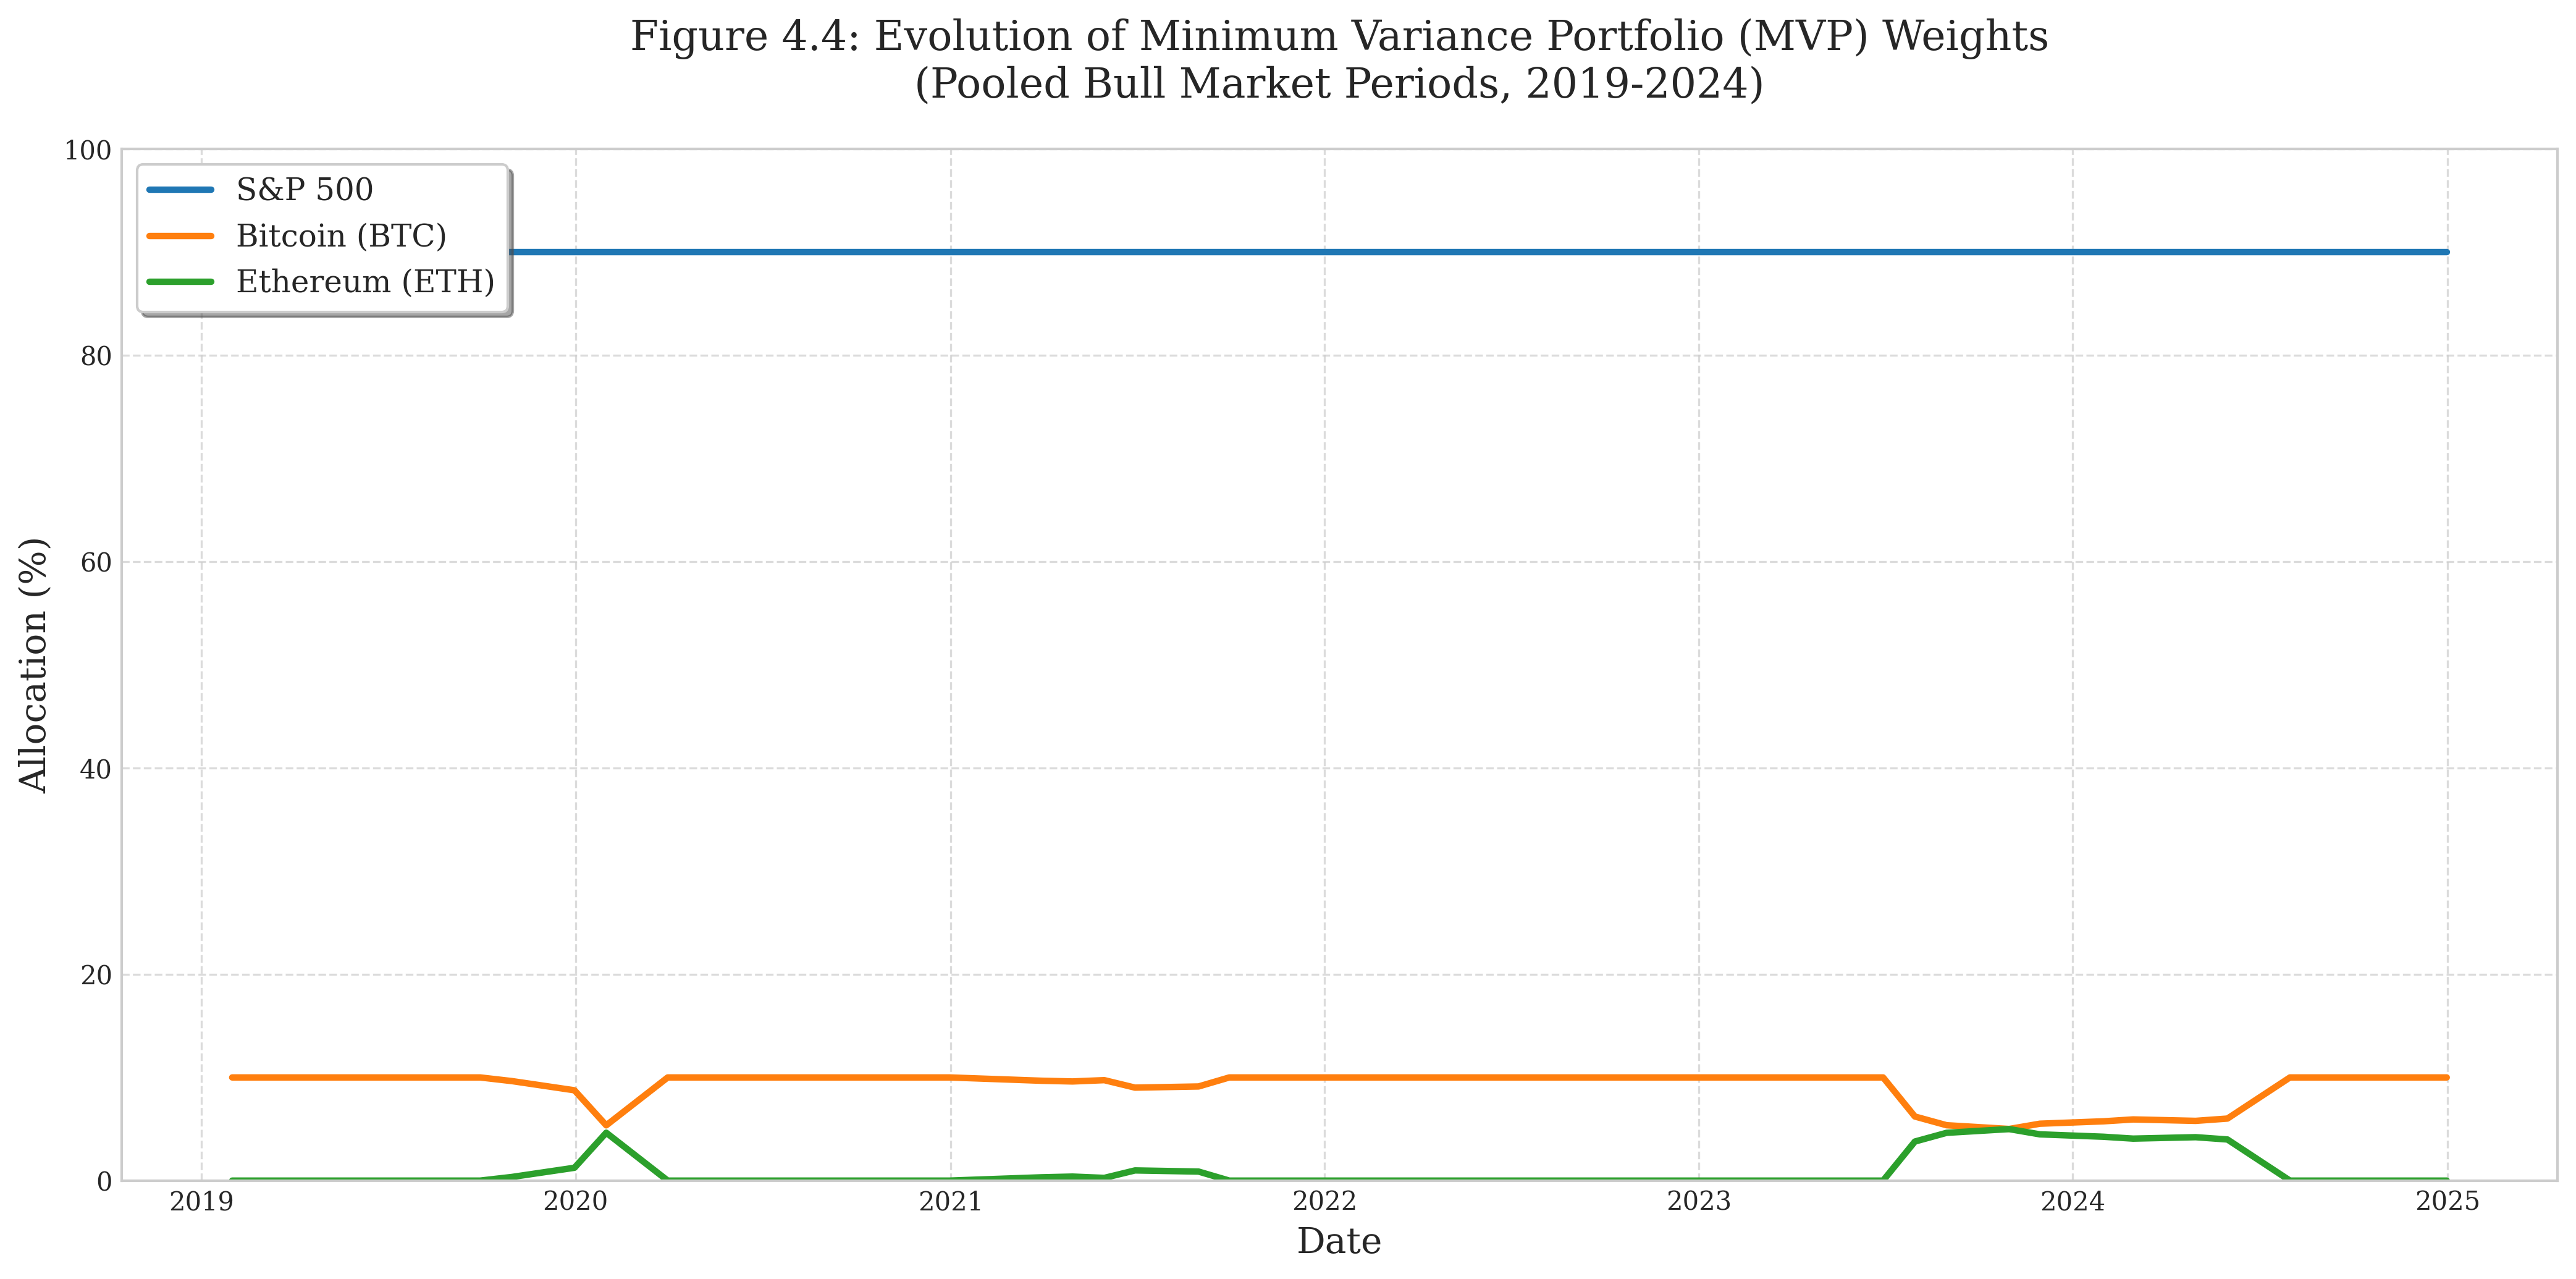

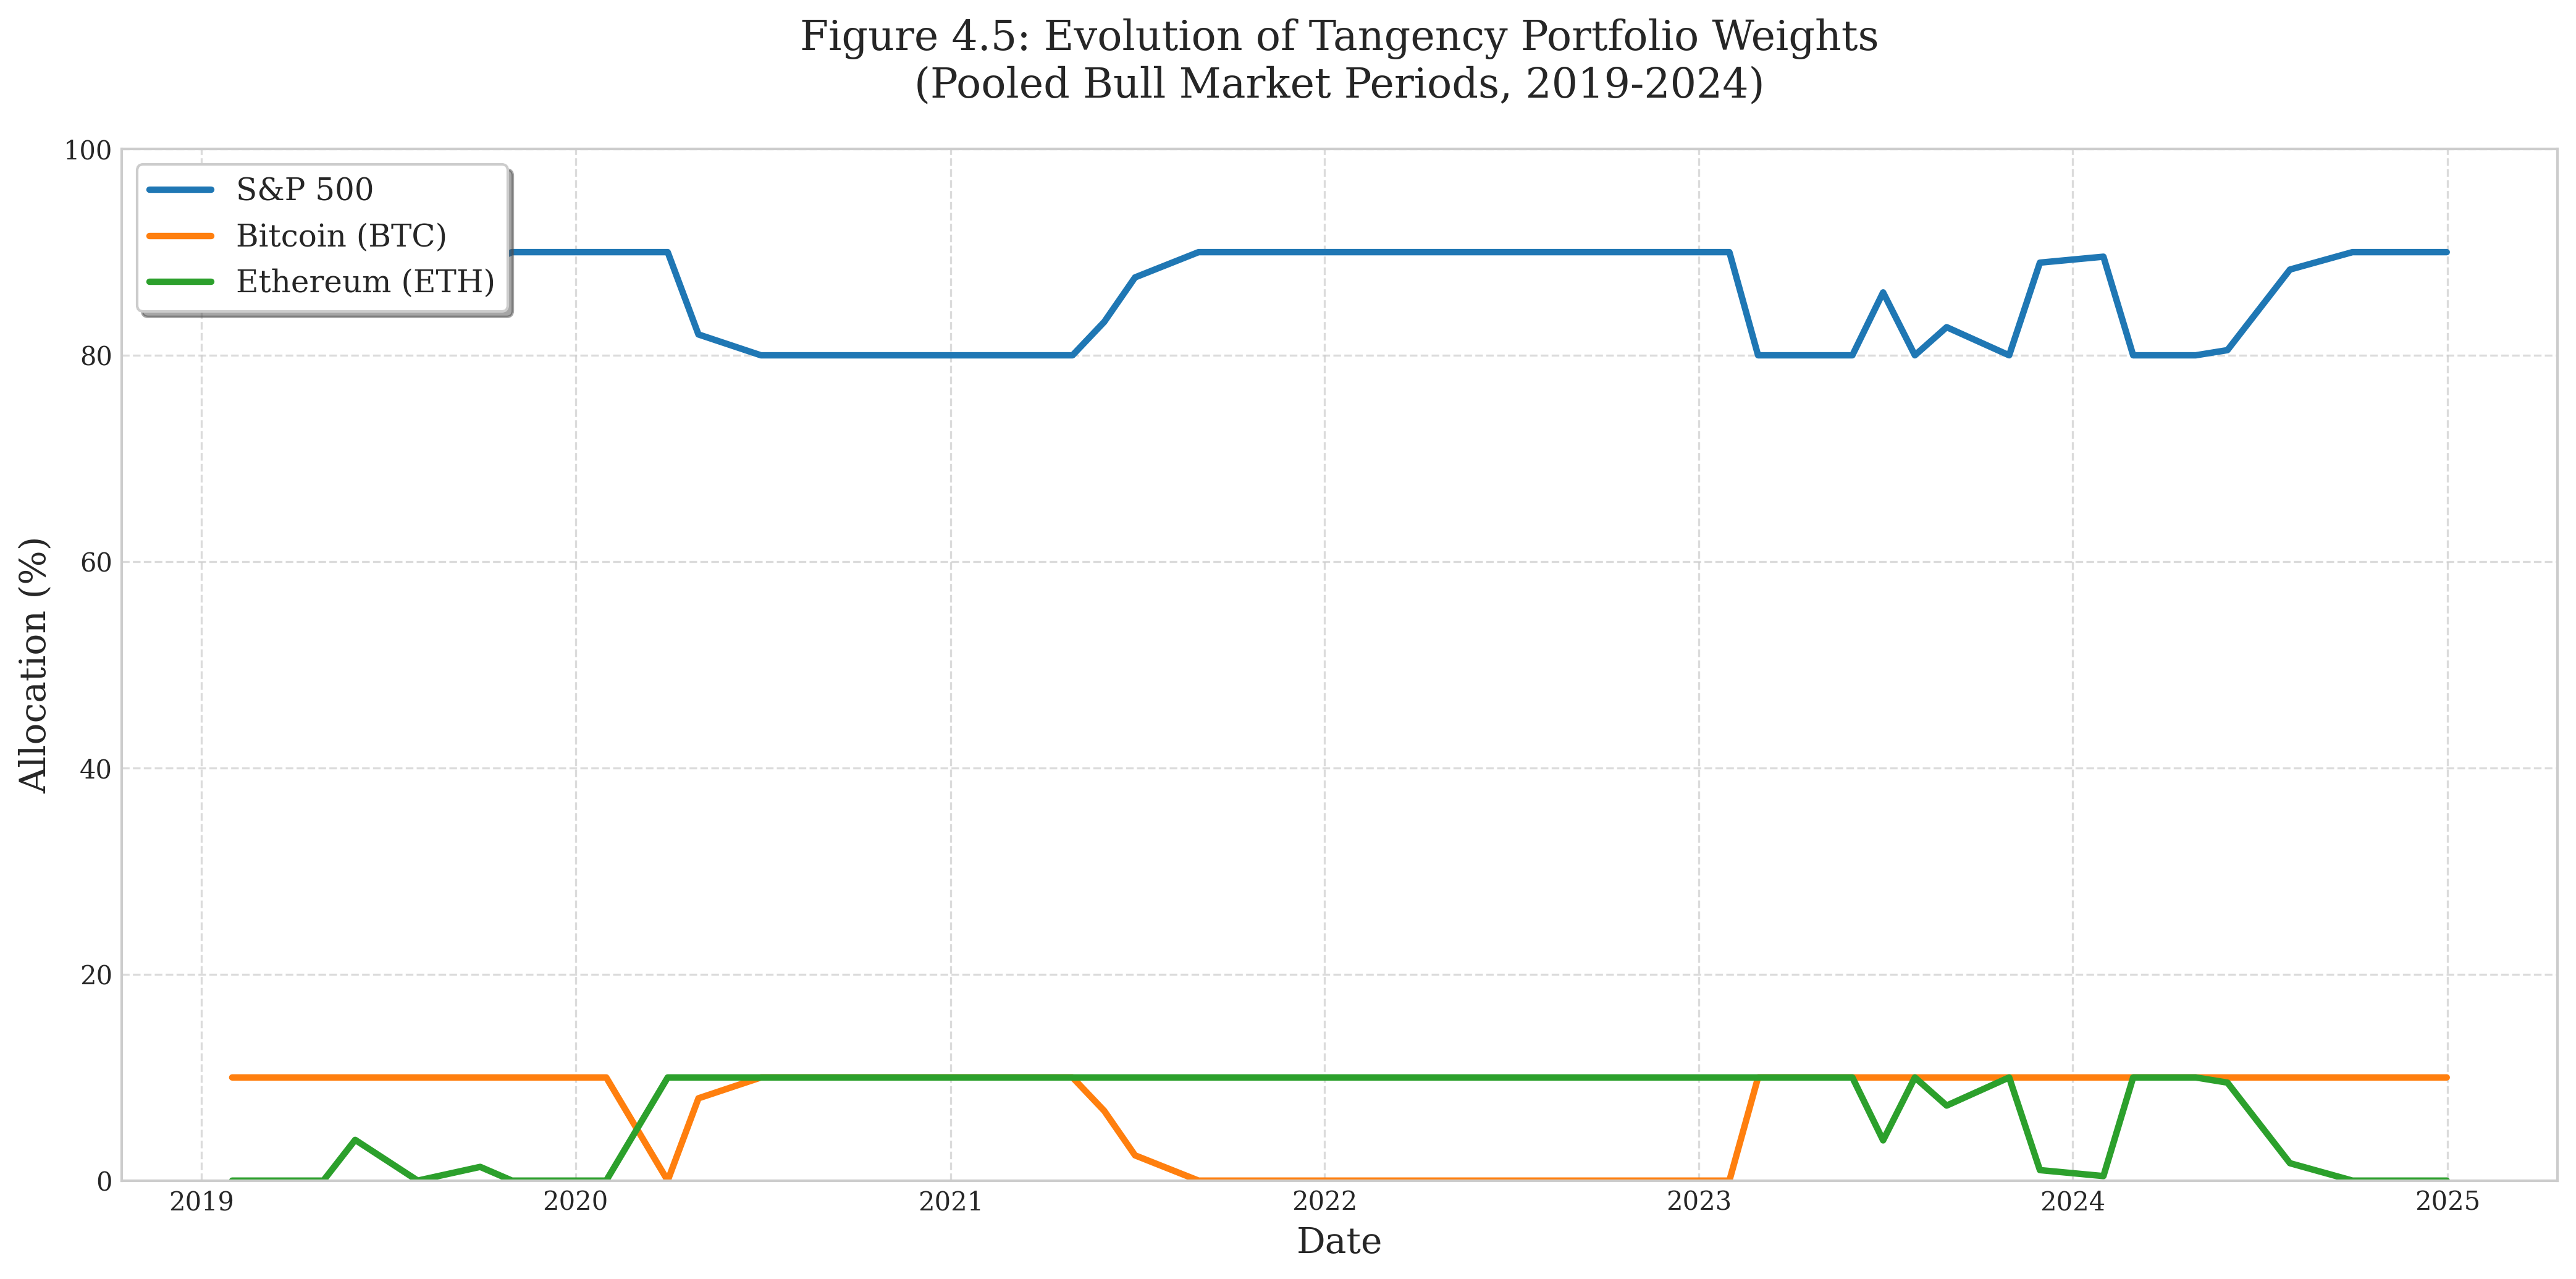

✅ Figures 4.4 and 4.5 have been created and saved as high-resolution PNG files.
   - thesis_figure_4.4_mvp_weights.png
   - thesis_figure_4.5_tangency_weights.png


In [ ]:
# =============================================================================
# CODE TO GENERATE FIGURES 4.4 & 4.5: EVOLUTION OF PORTFOLIO WEIGHTS
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the visual style for academic papers
plt.style.use('seaborn-v0_8-whitegrid')  # Clean with faint gridlines
plt.rcParams['font.family'] = 'serif'     # Use serif font, common in publications
plt.rcParams['figure.figsize'] = [12, 6]  # Set a good default figure size
plt.rcParams['figure.dpi'] = 300          # High resolution for publication

# Load the weight data from your pooled analysis results file
weights_file = 'pooled_analysis_results_final.xlsx'

# Read the data from Excel
mvp_weights_df = pd.read_excel(weights_file, sheet_name='MVP_Monthly_Weights', index_col='Date')
tangency_weights_df = pd.read_excel(weights_file, sheet_name='Tangency_Monthly_Weights', index_col='Date')

# Ensure the index is a DateTimeIndex
mvp_weights_df.index = pd.to_datetime(mvp_weights_df.index)
tangency_weights_df.index = pd.to_datetime(tangency_weights_df.index)

# --- CREATE FIGURE 4.4: Evolution of MVP Portfolio Weights ---
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each asset's weight
ax.plot(mvp_weights_df.index, mvp_weights_df['SP500_w'] * 100,
        label='S&P 500', linewidth=2.5, color='#1f77b4')  # Blue
ax.plot(mvp_weights_df.index, mvp_weights_df['BTC_w'] * 100,
        label='Bitcoin (BTC)', linewidth=2.5, color='#ff7f0e')  # Orange
ax.plot(mvp_weights_df.index, mvp_weights_df['ETH_w'] * 100,
        label='Ethereum (ETH)', linewidth=2.5, color='#2ca02c')  # Green

# Formatting the plot
ax.set_title('Figure 4.4: Evolution of Minimum Variance Portfolio (MVP) Weights\n(Pooled Bull Market Periods, 2019-2024)',
             fontsize=16, pad=20)
ax.set_ylabel('Allocation (%)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, shadow=True)

# Format the x-axis to show years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Add a light grid for easier reading
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure y-axis shows percentage properly
ax.set_ylim(0, 100)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('thesis_figure_4.4_mvp_weights.png', dpi=300, bbox_inches='tight')
plt.show()

# --- CREATE FIGURE 4.5: Evolution of Tangency Portfolio Weights ---
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each asset's weight
ax.plot(tangency_weights_df.index, tangency_weights_df['SP500_w'] * 100,
        label='S&P 500', linewidth=2.5, color='#1f77b4')  # Blue
ax.plot(tangency_weights_df.index, tangency_weights_df['BTC_w'] * 100,
        label='Bitcoin (BTC)', linewidth=2.5, color='#ff7f0e')  # Orange
ax.plot(tangency_weights_df.index, tangency_weights_df['ETH_w'] * 100,
        label='Ethereum (ETH)', linewidth=2.5, color='#2ca02c')  # Green

# Formatting the plot
ax.set_title('Figure 4.5: Evolution of Tangency Portfolio Weights\n(Pooled Bull Market Periods, 2019-2024)',
             fontsize=16, pad=20)
ax.set_ylabel('Allocation (%)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, shadow=True)

# Format the x-axis to show years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Add a light grid for easier reading
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure y-axis shows percentage properly
ax.set_ylim(0, 100)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('thesis_figure_4.5_tangency_weights.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Figures 4.4 and 4.5 have been created and saved as high-resolution PNG files.")
print("   - thesis_figure_4.4_mvp_weights.png")
print("   - thesis_figure_4.5_tangency_weights.png")

#28.08.2025 (Bootstrapping testing) for BTC

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re
import os

# --- 1. CONFIGURATION & PARAMETERS ---

# File paths (ensure these files are in the same directory as the script or provide full paths)
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'

# Output file names for the results
POOLED_RESULTS_EXCEL_FILE = 'pooled_analysis_results_final.xlsx'
# SUBPERIOD_RESULTS_EXCEL_FILE = 'subperiod_analysis_results_final.xlsx'  # We'll focus on pooled first

# Simulation Parameters
TRANSACTION_COST = 0.0025  # 0.25%
REBALANCE_THRESHOLD = 0.01 # Absolute 1% deviation for fixed-weight portfolios
ANNUAL_TRADING_DAYS = 252

# Optimization Parameters
LOOKBACK_WINDOW = 252  # Days for rolling optimization
# REBALANCE_FREQUENCY is now passed as a parameter

# ADDED: Portfolio Constraints (0% min allocation, 10% max per crypto)
MIN_ASSET_ALLOCATION = 0.00   # 0% minimum allocation
MAX_EQUITY_ALLOCATION = 0.90  # 90% max for SP500
MAX_CRYPTO_ALLOCATION = 0.10  # 10% max per crypto

# NEW: Rebalancing frequencies to test
REBALANCE_FREQUENCIES_TO_TEST = {
    'Monthly': 'ME',
    'Quarterly': 'QE'
}

# --- 2. DATA LOADING AND PREPARATION ---

def load_and_prepare_data(price_file, rf_file, phases_file):
    """Loads, merges, and prepares all necessary data for the analysis."""
    print("Loading and preparing data...")

    try:
        # Load data files and clean column names for robustness
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]

        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]

        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]

    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure all CSV files are in the correct directory.")
        return None, None

    # Standardize Date Columns to datetime objects
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)

        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Could not find a 'Date' or 'DATE' column in the risk-free rate CSV file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: A required column was not found. Please check your CSV files. Details: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Could not find the required '{cleaned_rf_col_name}' column in your risk-free rate file.")

    # Merge dataframes
    df = pd.merge(price_df, rf_df, on='Date', how='left')
    # --- FIX for FutureWarning ---
    # Changed from inplace=True to direct assignment to avoid the warning.
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    # Calculate Daily Returns and add the risk-free rate
    returns_df = df[['SP500', 'BTC', 'ETH']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name]
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- 3. PERFORMANCE METRIC FUNCTIONS ---

def calculate_annualized_return(returns):
    """Calculates the geometric annualized return for accurate compounded growth representation."""
    if returns.empty or len(returns) == 0:
        return 0.0
    num_years = len(returns) / ANNUAL_TRADING_DAYS
    cumulative_return = (1 + returns).prod()
    return (cumulative_return ** (1 / num_years)) - 1

# FIXED: Sharpe Ratio calculation with correct annualization
def calculate_sharpe_ratio(returns, rf_rate):
    """Calculates the annualized Sharpe Ratio using a time-varying risk-free rate."""
    if returns.empty or returns.std() == 0:
        return 0.0
    excess_returns = returns - rf_rate
    # Correct annualization: multiply return by days, volatility by sqrt(days)
    return (excess_returns.mean() * ANNUAL_TRADING_DAYS) / (excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS))

def calculate_sortino_ratio(returns, mar=0):
    if returns.empty:
        return 0.0

    # Precise MAR conversion
    daily_mar = (1 + mar)**(1/ANNUAL_TRADING_DAYS) - 1

    # Full-series downside deviation
    downside_diff = np.maximum(daily_mar - returns, 0)
    downside_var = np.mean(downside_diff ** 2)
    downside_std = np.sqrt(downside_var) * np.sqrt(ANNUAL_TRADING_DAYS)

    if downside_std == 0 or pd.isna(downside_std):
        return 0.0

    annualized_ret = calculate_annualized_return(returns)
    return (annualized_ret - mar) / downside_std

def calculate_cvar_95(returns):
    """Calculates the 95% Conditional Value-at-Risk (CVaR)."""
    if returns.empty:
        return 0.0
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()
    return -cvar_95  # Return as a positive value representing loss

# --- 4. PORTFOLIO OPTIMIZATION & SIMULATION ---

def portfolio_variance(weights, cov_matrix):
    """Helper function to calculate portfolio variance for MVP optimization."""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf_rate):
    """Calculates negative Sharpe for Tangency Portfolio optimization. Correctly uses excess returns."""
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_std == 0:
        return 0
    excess_return = portfolio_return - rf_rate
    return -(excess_return / portfolio_std) * np.sqrt(ANNUAL_TRADING_DAYS)

def get_optimized_portfolio(mean_returns, cov_matrix, rf_rate, opt_type):
    """Finds optimal weights with institutional constraints"""
    num_assets = len(mean_returns)
    args = (cov_matrix,) if opt_type == 'MVP' else (mean_returns, cov_matrix, rf_rate)
    target_func = portfolio_variance if opt_type == 'MVP' else negative_sharpe_ratio

    # Define custom bounds for each asset (0% min, 10% crypto max)
    bounds = [
        (MIN_ASSET_ALLOCATION, MAX_EQUITY_ALLOCATION),  # SP500 bounds (0-90%)
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION),  # BTC bounds (0-10%)
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION)   # ETH bounds (0-10%)
    ]

    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Must sum to 100%
    )

    # SAFE INITIAL WEIGHTS: Within constraints (SP500:90%, BTC:10%, ETH:10% -> normalized)
    total = MAX_EQUITY_ALLOCATION + MAX_CRYPTO_ALLOCATION + MAX_CRYPTO_ALLOCATION
    if total > 0:
        initial_weights = [
            MAX_EQUITY_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total
        ]
    else:
        initial_weights = [1.0, 0.0, 0.0]  # Fallback

    result = minimize(
        target_func,
        initial_weights,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000, 'ftol': 1e-9}  # Increase precision
    )

    if result.success:
        # Normalize weights to sum exactly to 1
        normalized_weights = result.x / np.sum(result.x)
        return normalized_weights
    else:
        print(f"Optimization failed: {result.message}")
        print(f"Trying backup optimization with relaxed constraints...")
        # Fallback method
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
        result = minimize(
            target_func,
            initial_weights,
            args=args,
            method='SLSQP',
            constraints=constraints
        )
        if result.success:
            return result.x / np.sum(result.x)
        return initial_weights  # Return initial weights if optimization fails

def simulate_fixed_weight_portfolio(returns_df, bull_market_mask, weights, threshold, cost):
    """Simulates a fixed-weight portfolio with threshold rebalancing and costs."""
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return pd.Series()

    sim_returns['is_period_start'] = ~sim_returns.index.to_series().diff().dt.days.eq(1)
    portfolio_values = [1.0]
    current_weights = weights.copy()
    asset_cols = list(weights.keys())

    for i in range(len(sim_returns)):
        daily_return = sum(current_weights[asset] * sim_returns[asset].iloc[i] for asset in asset_cols)
        portfolio_values.append(portfolio_values[-1] * (1 + daily_return))

        # Avoid division by zero if portfolio value drops to zero
        if portfolio_values[-1] == 0:
            market_weights = weights.copy()
        else:
            market_weights = {
                asset: (current_weights[asset] * (1 + sim_returns[asset].iloc[i])) / (1 + daily_return)
                for asset in asset_cols
            }

        if any(abs(market_weights[asset] - weights[asset]) > threshold for asset in asset_cols) or sim_returns['is_period_start'].iloc[i]:
            turnover = sum(abs(market_weights[asset] - weights[asset]) for asset in asset_cols) / 2
            portfolio_values[-1] *= (1 - (turnover * cost))
            current_weights = weights.copy()
        else:
            current_weights = market_weights

    return pd.Series(portfolio_values[1:], index=sim_returns.index).pct_change().dropna()

def simulate_optimized_portfolio(full_returns_df, bull_market_mask, lookback, frequency, opt_type, cost):
    """Simulates a dynamically optimized portfolio with rebalancing and costs."""
    sim_dates = full_returns_df[bull_market_mask].index
    if sim_dates.empty:
        return pd.Series(), pd.DataFrame(), 0.0  # Return 0 turnover if no dates

    # NEW: Create a list of only the rebalancing dates
    rebalance_dates = pd.date_range(sim_dates.min(), sim_dates.max(), freq=frequency).normalize()
    rebalance_dates = [d for d in rebalance_dates if d in sim_dates]

    # NEW: Initialize turnover tracking
    total_turnover = 0.0

    portfolio_returns = []
    weights_history = []
    # Start with SP500 only
    current_weights = np.array([1.0, 0.0, 0.0])
    last_rebalance_date = sim_dates[0] - pd.DateOffset(days=1)

    # NEW: Loop through all dates in the simulation period
    for date in sim_dates:
        daily_rebalance = False

        # Check if today is a rebalancing day
        if date in rebalance_dates and date > last_rebalance_date:
            lookback_start = date - pd.DateOffset(days=lookback)
            # Ensure lookback period doesn't extend before available data
            if lookback_start < full_returns_df.index[0]:
                lookback_start = full_returns_df.index[0]

            lookback_data = full_returns_df.loc[lookback_start:date-pd.DateOffset(days=1)]

            if len(lookback_data) > 10:  # Require minimum data points
                asset_returns = lookback_data[['SP500', 'BTC', 'ETH']]
                mean_returns = asset_returns.mean()
                cov_matrix = asset_returns.cov()
                rf_lookback = lookback_data['RF_Rate'].mean()
                new_weights = get_optimized_portfolio(mean_returns, cov_matrix, rf_lookback, opt_type)

                # NEW: Calculate and accumulate turnover
                turnover = np.sum(np.abs(new_weights - current_weights)) / 2
                total_turnover += turnover
                rebalance_cost = turnover * cost

                # Apply cost to the portfolio
                if portfolio_returns:
                    portfolio_returns[-1] -= rebalance_cost

                current_weights = new_weights
                last_rebalance_date = date
                daily_rebalance = True
                weights_history.append({
                    'Date': date,
                    'SP500_w': current_weights[0],
                    'BTC_w': current_weights[1],
                    'ETH_w': current_weights[2]
                })

        # Calculate daily portfolio return
        daily_asset_returns = full_returns_df.loc[date, ['SP500', 'BTC', 'ETH']].values
        daily_port_return = np.dot(current_weights, daily_asset_returns)
        portfolio_returns.append(daily_port_return)

    return pd.Series(portfolio_returns, index=sim_dates).dropna(), pd.DataFrame(weights_history).set_index('Date'), total_turnover

# --- 5. MAIN ANALYSIS FUNCTIONS ---

def run_pooled_analysis(full_returns, phases, rebalance_freq='ME'):
    """
    Runs the pooled analysis for a specific rebalancing frequency.
    Returns results and weights dataframes.
    """
    print(f"\n--- Starting Pooled Bull Market Analysis ({rebalance_freq}) ---")
    bull_phases = phases[phases['Phase'] == 'Bull']
    mask = pd.Series(False, index=full_returns.index)
    for _, row in bull_phases.iterrows():
        mask.loc[row['Start']:row['End']] = True

    rf_rate = full_returns.loc[mask, 'RF_Rate']
    portfolios_to_test = {
        '100% SP500': {'SP500': 1.00, 'BTC': 0.000, 'ETH': 0.000},
        '99% SP500, 1% BTC': {'SP500': 0.99, 'BTC': 0.01, 'ETH': 0.00},
        '98% SP500, 2% BTC': {'SP500': 0.98, 'BTC': 0.02, 'ETH': 0.00},
        '97% SP500, 3% BTC': {'SP500': 0.97, 'BTC': 0.03, 'ETH': 0.00},
        '96% SP500, 4% BTC': {'SP500': 0.96, 'BTC': 0.04, 'ETH': 0.00},
        '95% SP500, 5% BTC': {'SP500': 0.95, 'BTC': 0.05, 'ETH': 0.00},
        '99% SP500, 1% ETH': {'SP500': 0.99, 'BTC': 0.00, 'ETH': 0.01},
        '98% SP500, 2% ETH': {'SP500': 0.98, 'BTC': 0.00, 'ETH': 0.02},
        '97% SP500, 3% ETH': {'SP500': 0.97, 'BTC': 0.00, 'ETH': 0.03},
        '96% SP500, 4% ETH': {'SP500': 0.96, 'BTC': 0.00, 'ETH': 0.04},
        '95% SP500, 5% ETH': {'SP500': 0.95, 'BTC': 0.00, 'ETH': 0.05},
        '99% SP500, 0.5% BTC, 0.5% ETH': {'SP500': 0.99, 'BTC': 0.005, 'ETH': 0.005},
        '98% SP500, 1% BTC, 1% ETH':   {'SP500': 0.98, 'BTC': 0.010, 'ETH': 0.010},
        '97% SP500, 1.5% BTC, 1.5% ETH': {'SP500': 0.97, 'BTC': 0.015, 'ETH': 0.015},
        '96% SP500, 2% BTC, 2% ETH':   {'SP500': 0.96, 'BTC': 0.020, 'ETH': 0.020},
        '95% SP500, 2.5% BTC, 2.5% ETH': {'SP500': 0.95, 'BTC': 0.025, 'ETH': 0.025}
    }

    results = []
    weights_to_save = {}

    print("Simulating fixed-weight portfolios...")
    for name, weights in portfolios_to_test.items():
        port_returns = simulate_fixed_weight_portfolio(
            full_returns, mask, weights, REBALANCE_THRESHOLD, TRANSACTION_COST
        )
        if not port_returns.empty:
            results.append({
                'Portfolio': name,
                'Rebalancing Frequency': 'N/A (Fixed)',
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns),
                'Total Turnover': 0.0  # Fixed weights have no optimization turnover
            })

    print("Simulating dynamically optimized portfolios...")
    for opt_type in ['MVP', 'Tangency']:
        port_returns, weights_df, turnover = simulate_optimized_portfolio(
            full_returns, mask, LOOKBACK_WINDOW, rebalance_freq, opt_type, TRANSACTION_COST
        )
        if not port_returns.empty:
            freq_name = [k for k, v in REBALANCE_FREQUENCIES_TO_TEST.items() if v == rebalance_freq][0]
            results.append({
                'Portfolio': opt_type,
                'Rebalancing Frequency': freq_name,
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns),
                'Total Turnover': turnover
            })
            if not weights_df.empty:
                weights_to_save[f'{opt_type}_{freq_name}_Weights'] = weights_df

    results_df = pd.DataFrame(results)
    print(f"\n--- Pooled Analysis Results ({rebalance_freq}) ---")
    print(results_df.to_string())
    return results_df, weights_to_save

def run_comprehensive_pooled_analysis(full_returns, phases):
    """
    Runs the pooled analysis for all rebalancing frequencies and compiles results.
    """
    all_results = []
    all_weights = {}

    # Run analysis for each frequency
    for freq_name, freq_code in REBALANCE_FREQUENCIES_TO_TEST.items():
        results_df, weights_dict = run_pooled_analysis(full_returns, phases, freq_code)
        all_results.append(results_df)

        # Store weights with frequency in key
        for key, df in weights_dict.items():
            all_weights[key] = df

    # Combine all results
    final_results = pd.concat(all_results, ignore_index=True)

    return final_results, all_weights

# --- Main Execution Block ---
if __name__ == '__main__':
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run comprehensive pooled analysis
        pooled_results_df, pooled_weights = run_comprehensive_pooled_analysis(returns, market_phases)

# --- 6. STATISTICAL SIGNIFICANCE (BOOTSTRAPPING) ---
# ... [ALL YOUR BOOTSTRAPPING FUNCTION DEFINITIONS GO HERE] ...
# def stationary_bootstrap(...):
# def bootstrap_metric_significance(...):
# def run_and_save_bootstrapping(...):

# --- Main Execution Block ---
if __name__ == '__main__':
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run comprehensive pooled analysis
        pooled_results_df, pooled_weights = run_comprehensive_pooled_analysis(returns, market_phases)

        # Save to Excel with multiple sheets
        with pd.ExcelWriter(POOLED_RESULTS_EXCEL_FILE, engine='openpyxl') as writer:
            # Save main results
            pooled_results_df.to_excel(writer, sheet_name='All_Performance_Metrics', index=False)

            # Create separate sheets for rebalancing comparison
            mvp_results = pooled_results_df[pooled_results_df['Portfolio'] == 'MVP']
            tangency_results = pooled_results_df[pooled_results_df['Portfolio'] == 'Tangency']

            mvp_results.to_excel(writer, sheet_name='MVP_Rebalancing_Comparison', index=False)
            tangency_results.to_excel(writer, sheet_name='Tangency_Rebalancing_Comparison', index=False)

            # Save fixed-weight results separately
            fixed_results = pooled_results_df[pooled_results_df['Rebalancing Frequency'] == 'N/A (Fixed)']
            fixed_results.to_excel(writer, sheet_name='Fixed_Weight_Portfolios', index=False)

            # Save weights data
            for sheet_name, df in pooled_weights.items():
                # Shorten sheet name if needed (Excel has 31-character limit)
                short_name = sheet_name[:31]
                df.to_excel(writer, sheet_name=short_name)

        print(f"\n✅ Comprehensive pooled analysis results exported to '{POOLED_RESULTS_EXCEL_FILE}'")

        # ************************** CRITICAL FIX **************************
        # NEW: Run bootstrapping AFTER the main analysis is done and saved
        print("\n")
        bootstrapping_df = run_and_save_bootstrapping(returns, market_phases)
        # ******************************************************************

Loading and preparing data...
Data preparation complete.

--- Starting Pooled Bull Market Analysis (ME) ---
Simulating fixed-weight portfolios...
Simulating dynamically optimized portfolios...

--- Pooled Analysis Results (ME) ---
                        Portfolio Rebalancing Frequency  Annualized Return  Sharpe Ratio  Sortino Ratio  CVaR 95%  Total Turnover
0                      100% SP500           N/A (Fixed)           0.332176      1.720163       3.274267  0.021905        0.000000
1               99% SP500, 1% BTC           N/A (Fixed)           0.342110      1.769918       3.385982  0.021831        0.000000
2               98% SP500, 2% BTC           N/A (Fixed)           0.352065      1.817075       3.492752  0.021766        0.000000
3               97% SP500, 3% BTC           N/A (Fixed)           0.362041      1.861417       3.594395  0.021717        0.000000
4               96% SP500, 4% BTC           N/A (Fixed)           0.372037      1.902762       3.690430  0.021703      

#(Bootstrapping testing)for Eth

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re
import os

# --- 1. CONFIGURATION & PARAMETERS ---

# File paths (ensure these files are in the same directory as the script or provide full paths)
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'

# Output file names for the results
POOLED_RESULTS_EXCEL_FILE = 'pooled_analysis_results_final.xlsx'
# SUBPERIOD_RESULTS_EXCEL_FILE = 'subperiod_analysis_results_final.xlsx'  # We'll focus on pooled first

# Simulation Parameters
TRANSACTION_COST = 0.0025  # 0.25%
REBALANCE_THRESHOLD = 0.01 # Absolute 1% deviation for fixed-weight portfolios
ANNUAL_TRADING_DAYS = 252

# Optimization Parameters
LOOKBACK_WINDOW = 252  # Days for rolling optimization
# REBALANCE_FREQUENCY is now passed as a parameter

# ADDED: Portfolio Constraints (0% min allocation, 10% max per crypto)
MIN_ASSET_ALLOCATION = 0.00   # 0% minimum allocation
MAX_EQUITY_ALLOCATION = 0.90  # 90% max for SP500
MAX_CRYPTO_ALLOCATION = 0.10  # 10% max per crypto

# NEW: Rebalancing frequencies to test
REBALANCE_FREQUENCIES_TO_TEST = {
    'Monthly': 'ME',
    'Quarterly': 'QE'
}

# --- 2. DATA LOADING AND PREPARATION ---

def load_and_prepare_data(price_file, rf_file, phases_file):
    """Loads, merges, and prepares all necessary data for the analysis."""
    print("Loading and preparing data...")

    try:
        # Load data files and clean column names for robustness
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]

        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]

        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]

    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure all CSV files are in the correct directory.")
        return None, None

    # Standardize Date Columns to datetime objects
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)

        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Could not find a 'Date' or 'DATE' column in the risk-free rate CSV file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: A required column was not found. Please check your CSV files. Details: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Could not find the required '{cleaned_rf_col_name}' column in your risk-free rate file.")

    # Merge dataframes
    df = pd.merge(price_df, rf_df, on='Date', how='left')
    # --- FIX for FutureWarning ---
    # Changed from inplace=True to direct assignment to avoid the warning.
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    # Calculate Daily Returns and add the risk-free rate
    returns_df = df[['SP500', 'BTC', 'ETH']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name]
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- 3. PERFORMANCE METRIC FUNCTIONS ---

def calculate_annualized_return(returns):
    """Calculates the geometric annualized return for accurate compounded growth representation."""
    if returns.empty or len(returns) == 0:
        return 0.0
    num_years = len(returns) / ANNUAL_TRADING_DAYS
    cumulative_return = (1 + returns).prod()
    return (cumulative_return ** (1 / num_years)) - 1

# FIXED: Sharpe Ratio calculation with correct annualization
def calculate_sharpe_ratio(returns, rf_rate):
    """Calculates the annualized Sharpe Ratio using a time-varying risk-free rate."""
    if returns.empty or returns.std() == 0:
        return 0.0
    excess_returns = returns - rf_rate
    # Correct annualization: multiply return by days, volatility by sqrt(days)
    return (excess_returns.mean() * ANNUAL_TRADING_DAYS) / (excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS))

def calculate_sortino_ratio(returns, mar=0):
    if returns.empty:
        return 0.0

    # Precise MAR conversion
    daily_mar = (1 + mar)**(1/ANNUAL_TRADING_DAYS) - 1

    # Full-series downside deviation
    downside_diff = np.maximum(daily_mar - returns, 0)
    downside_var = np.mean(downside_diff ** 2)
    downside_std = np.sqrt(downside_var) * np.sqrt(ANNUAL_TRADING_DAYS)

    if downside_std == 0 or pd.isna(downside_std):
        return 0.0

    annualized_ret = calculate_annualized_return(returns)
    return (annualized_ret - mar) / downside_std

def calculate_cvar_95(returns):
    """Calculates the 95% Conditional Value-at-Risk (CVaR)."""
    if returns.empty:
        return 0.0
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()
    return -cvar_95  # Return as a positive value representing loss

# --- 4. PORTFOLIO OPTIMIZATION & SIMULATION ---

def portfolio_variance(weights, cov_matrix):
    """Helper function to calculate portfolio variance for MVP optimization."""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf_rate):
    """Calculates negative Sharpe for Tangency Portfolio optimization. Correctly uses excess returns."""
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_std == 0:
        return 0
    excess_return = portfolio_return - rf_rate
    return -(excess_return / portfolio_std) * np.sqrt(ANNUAL_TRADING_DAYS)

def get_optimized_portfolio(mean_returns, cov_matrix, rf_rate, opt_type):
    """Finds optimal weights with institutional constraints"""
    num_assets = len(mean_returns)
    args = (cov_matrix,) if opt_type == 'MVP' else (mean_returns, cov_matrix, rf_rate)
    target_func = portfolio_variance if opt_type == 'MVP' else negative_sharpe_ratio

    # Define custom bounds for each asset (0% min, 10% crypto max)
    bounds = [
        (MIN_ASSET_ALLOCATION, MAX_EQUITY_ALLOCATION),  # SP500 bounds (0-90%)
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION),  # BTC bounds (0-10%)
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION)   # ETH bounds (0-10%)
    ]

    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Must sum to 100%
    )

    # SAFE INITIAL WEIGHTS: Within constraints (SP500:90%, BTC:10%, ETH:10% -> normalized)
    total = MAX_EQUITY_ALLOCATION + MAX_CRYPTO_ALLOCATION + MAX_CRYPTO_ALLOCATION
    if total > 0:
        initial_weights = [
            MAX_EQUITY_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total
        ]
    else:
        initial_weights = [1.0, 0.0, 0.0]  # Fallback

    result = minimize(
        target_func,
        initial_weights,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000, 'ftol': 1e-9}  # Increase precision
    )

    if result.success:
        # Normalize weights to sum exactly to 1
        normalized_weights = result.x / np.sum(result.x)
        return normalized_weights
    else:
        print(f"Optimization failed: {result.message}")
        print(f"Trying backup optimization with relaxed constraints...")
        # Fallback method
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
        result = minimize(
            target_func,
            initial_weights,
            args=args,
            method='SLSQP',
            constraints=constraints
        )
        if result.success:
            return result.x / np.sum(result.x)
        return initial_weights  # Return initial weights if optimization fails

def simulate_fixed_weight_portfolio(returns_df, bull_market_mask, weights, threshold, cost):
    """Simulates a fixed-weight portfolio with threshold rebalancing and costs."""
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return pd.Series()

    sim_returns['is_period_start'] = ~sim_returns.index.to_series().diff().dt.days.eq(1)
    portfolio_values = [1.0]
    current_weights = weights.copy()
    asset_cols = list(weights.keys())

    for i in range(len(sim_returns)):
        daily_return = sum(current_weights[asset] * sim_returns[asset].iloc[i] for asset in asset_cols)
        portfolio_values.append(portfolio_values[-1] * (1 + daily_return))

        # Avoid division by zero if portfolio value drops to zero
        if portfolio_values[-1] == 0:
            market_weights = weights.copy()
        else:
            market_weights = {
                asset: (current_weights[asset] * (1 + sim_returns[asset].iloc[i])) / (1 + daily_return)
                for asset in asset_cols
            }

        if any(abs(market_weights[asset] - weights[asset]) > threshold for asset in asset_cols) or sim_returns['is_period_start'].iloc[i]:
            turnover = sum(abs(market_weights[asset] - weights[asset]) for asset in asset_cols) / 2
            portfolio_values[-1] *= (1 - (turnover * cost))
            current_weights = weights.copy()
        else:
            current_weights = market_weights

    return pd.Series(portfolio_values[1:], index=sim_returns.index).pct_change().dropna()

def simulate_optimized_portfolio(full_returns_df, bull_market_mask, lookback, frequency, opt_type, cost):
    """Simulates a dynamically optimized portfolio with rebalancing and costs."""
    sim_dates = full_returns_df[bull_market_mask].index
    if sim_dates.empty:
        return pd.Series(), pd.DataFrame(), 0.0  # Return 0 turnover if no dates

    # NEW: Create a list of only the rebalancing dates
    rebalance_dates = pd.date_range(sim_dates.min(), sim_dates.max(), freq=frequency).normalize()
    rebalance_dates = [d for d in rebalance_dates if d in sim_dates]

    # NEW: Initialize turnover tracking
    total_turnover = 0.0

    portfolio_returns = []
    weights_history = []
    # Start with SP500 only
    current_weights = np.array([1.0, 0.0, 0.0])
    last_rebalance_date = sim_dates[0] - pd.DateOffset(days=1)

    # NEW: Loop through all dates in the simulation period
    for date in sim_dates:
        daily_rebalance = False

        # Check if today is a rebalancing day
        if date in rebalance_dates and date > last_rebalance_date:
            lookback_start = date - pd.DateOffset(days=lookback)
            # Ensure lookback period doesn't extend before available data
            if lookback_start < full_returns_df.index[0]:
                lookback_start = full_returns_df.index[0]

            lookback_data = full_returns_df.loc[lookback_start:date-pd.DateOffset(days=1)]

            if len(lookback_data) > 10:  # Require minimum data points
                asset_returns = lookback_data[['SP500', 'BTC', 'ETH']]
                mean_returns = asset_returns.mean()
                cov_matrix = asset_returns.cov()
                rf_lookback = lookback_data['RF_Rate'].mean()
                new_weights = get_optimized_portfolio(mean_returns, cov_matrix, rf_lookback, opt_type)

                # NEW: Calculate and accumulate turnover
                turnover = np.sum(np.abs(new_weights - current_weights)) / 2
                total_turnover += turnover
                rebalance_cost = turnover * cost

                # Apply cost to the portfolio
                if portfolio_returns:
                    portfolio_returns[-1] -= rebalance_cost

                current_weights = new_weights
                last_rebalance_date = date
                daily_rebalance = True
                weights_history.append({
                    'Date': date,
                    'SP500_w': current_weights[0],
                    'BTC_w': current_weights[1],
                    'ETH_w': current_weights[2]
                })

        # Calculate daily portfolio return
        daily_asset_returns = full_returns_df.loc[date, ['SP500', 'BTC', 'ETH']].values
        daily_port_return = np.dot(current_weights, daily_asset_returns)
        portfolio_returns.append(daily_port_return)

    return pd.Series(portfolio_returns, index=sim_dates).dropna(), pd.DataFrame(weights_history).set_index('Date'), total_turnover

# --- 5. MAIN ANALYSIS FUNCTIONS ---

def run_pooled_analysis(full_returns, phases, rebalance_freq='ME'):
    """
    Runs the pooled analysis for a specific rebalancing frequency.
    Returns results and weights dataframes.
    """
    print(f"\n--- Starting Pooled Bull Market Analysis ({rebalance_freq}) ---")
    bull_phases = phases[phases['Phase'] == 'Bull']
    mask = pd.Series(False, index=full_returns.index)
    for _, row in bull_phases.iterrows():
        mask.loc[row['Start']:row['End']] = True

    rf_rate = full_returns.loc[mask, 'RF_Rate']
    portfolios_to_test = {
        '100% SP500': {'SP500': 1.00, 'BTC': 0.000, 'ETH': 0.000},
        '99% SP500, 1% BTC': {'SP500': 0.99, 'BTC': 0.01, 'ETH': 0.00},
        '98% SP500, 2% BTC': {'SP500': 0.98, 'BTC': 0.02, 'ETH': 0.00},
        '97% SP500, 3% BTC': {'SP500': 0.97, 'BTC': 0.03, 'ETH': 0.00},
        '96% SP500, 4% BTC': {'SP500': 0.96, 'BTC': 0.04, 'ETH': 0.00},
        '95% SP500, 5% BTC': {'SP500': 0.95, 'BTC': 0.05, 'ETH': 0.00},
        '99% SP500, 1% ETH': {'SP500': 0.99, 'BTC': 0.00, 'ETH': 0.01},
        '98% SP500, 2% ETH': {'SP500': 0.98, 'BTC': 0.00, 'ETH': 0.02},
        '97% SP500, 3% ETH': {'SP500': 0.97, 'BTC': 0.00, 'ETH': 0.03},
        '96% SP500, 4% ETH': {'SP500': 0.96, 'BTC': 0.00, 'ETH': 0.04},
        '95% SP500, 5% ETH': {'SP500': 0.95, 'BTC': 0.00, 'ETH': 0.05},
        '99% SP500, 0.5% BTC, 0.5% ETH': {'SP500': 0.99, 'BTC': 0.005, 'ETH': 0.005},
        '98% SP500, 1% BTC, 1% ETH':   {'SP500': 0.98, 'BTC': 0.010, 'ETH': 0.010},
        '97% SP500, 1.5% BTC, 1.5% ETH': {'SP500': 0.97, 'BTC': 0.015, 'ETH': 0.015},
        '96% SP500, 2% BTC, 2% ETH':   {'SP500': 0.96, 'BTC': 0.020, 'ETH': 0.020},
        '95% SP500, 2.5% BTC, 2.5% ETH': {'SP500': 0.95, 'BTC': 0.025, 'ETH': 0.025}
    }

    results = []
    weights_to_save = {}

    print("Simulating fixed-weight portfolios...")
    for name, weights in portfolios_to_test.items():
        port_returns = simulate_fixed_weight_portfolio(
            full_returns, mask, weights, REBALANCE_THRESHOLD, TRANSACTION_COST
        )
        if not port_returns.empty:
            results.append({
                'Portfolio': name,
                'Rebalancing Frequency': 'N/A (Fixed)',
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns),
                'Total Turnover': 0.0  # Fixed weights have no optimization turnover
            })

    print("Simulating dynamically optimized portfolios...")
    for opt_type in ['MVP', 'Tangency']:
        port_returns, weights_df, turnover = simulate_optimized_portfolio(
            full_returns, mask, LOOKBACK_WINDOW, rebalance_freq, opt_type, TRANSACTION_COST
        )
        if not port_returns.empty:
            freq_name = [k for k, v in REBALANCE_FREQUENCIES_TO_TEST.items() if v == rebalance_freq][0]
            results.append({
                'Portfolio': opt_type,
                'Rebalancing Frequency': freq_name,
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns),
                'Total Turnover': turnover
            })
            if not weights_df.empty:
                weights_to_save[f'{opt_type}_{freq_name}_Weights'] = weights_df

    results_df = pd.DataFrame(results)
    print(f"\n--- Pooled Analysis Results ({rebalance_freq}) ---")
    print(results_df.to_string())
    return results_df, weights_to_save

def run_comprehensive_pooled_analysis(full_returns, phases):
    """
    Runs the pooled analysis for all rebalancing frequencies and compiles results.
    """
    all_results = []
    all_weights = {}

    # Run analysis for each frequency
    for freq_name, freq_code in REBALANCE_FREQUENCIES_TO_TEST.items():
        results_df, weights_dict = run_pooled_analysis(full_returns, phases, freq_code)
        all_results.append(results_df)

        # Store weights with frequency in key
        for key, df in weights_dict.items():
            all_weights[key] = df

    # Combine all results
    final_results = pd.concat(all_results, ignore_index=True)

    return final_results, all_weights

# --- 6. STATISTICAL SIGNIFICANCE (BOOTSTRAPPING) ---

def stationary_bootstrap(original_series, num_samples, mean_block_length):
    """
    Implements the Stationary Bootstrap algorithm from Politis & Romano (1994).
    Returns a list of indices for each bootstrap sample.

    Parameters:
    original_series (pd.Series): The original time series data.
    num_samples (int): The number of bootstrap samples to generate.
    mean_block_length (float): The mean length of the blocks.

    Returns:
    list: A list of lists, where each inner list contains the indices for one bootstrap sample.
    """
    n = len(original_series)
    indices = np.arange(n)
    bootstrap_samples = []

    p = 1.0 / mean_block_length  # Probability of starting a new block

    for _ in range(num_samples):
        sample_indices = []
        # Start at a random point
        current_index = np.random.randint(0, n)
        for _ in range(n):
            sample_indices.append(current_index)
            # Decide next step: move to next index or jump to a new random start
            if np.random.random() < p:
                current_index = np.random.randint(0, n)  # Jump
            else:
                current_index = (current_index + 1) % n  # Move to next
        bootstrap_samples.append(sample_indices)
    return bootstrap_samples

def bootstrap_metric_significance(returns_df, bull_market_mask, metric_func, portfolio_weights, num_bootstraps=10000, mean_block_length=10, alpha=0.10):
    """
    Bootstraps the difference of a performance metric between a crypto portfolio and the baseline.
    """
    # 1. Prepare the data for the bull market period
    bull_data = returns_df[bull_market_mask].copy()
    if bull_data.empty:
        print("No bull market data found for bootstrapping.")
        return None

    # 2. Calculate the OBSERVED difference in metrics
    baseline_returns = bull_data['SP500'].copy()

    # Build crypto portfolio returns safely
    crypto_returns = portfolio_weights['SP500'] * bull_data['SP500']
    if 'BTC' in portfolio_weights and 'BTC' in bull_data.columns:
        crypto_returns += portfolio_weights['BTC'] * bull_data['BTC']
    if 'ETH' in portfolio_weights and 'ETH' in bull_data.columns:
        crypto_returns += portfolio_weights.get('ETH', 0) * bull_data.get('ETH', 0)

    rf_series = bull_data['RF_Rate']

    # Calculate observed metrics safely
    try:
        metric_baseline = metric_func(baseline_returns, rf_series)
        metric_crypto = metric_func(crypto_returns, rf_series)
    except TypeError:
        metric_baseline = metric_func(baseline_returns)
        metric_crypto = metric_func(crypto_returns)

    observed_diff = metric_crypto - metric_baseline
    print(f"Observed difference in {metric_func.__name__}: {observed_diff:.6f}")

    # 3. Generate bootstrap samples
    print(f"Generating {num_bootstraps} bootstrap samples...")
    bootstrap_indices = stationary_bootstrap(bull_data['SP500'], num_bootstraps, mean_block_length)

    # 4. Calculate the metric difference for each bootstrap sample
    bootstrapped_diffs = []
    for i, indices in enumerate(bootstrap_indices):
        if i % 1000 == 0:
            print(f"Processing bootstrap sample {i}/{num_bootstraps}")

        sample_data = bull_data.iloc[indices]

        baseline_sample_returns = sample_data['SP500']
        crypto_sample_returns = portfolio_weights['SP500'] * sample_data['SP500']
        if 'BTC' in portfolio_weights and 'BTC' in sample_data.columns:
            crypto_sample_returns += portfolio_weights['BTC'] * sample_data['BTC']
        if 'ETH' in portfolio_weights and 'ETH' in sample_data.columns:
            crypto_sample_returns += portfolio_weights.get('ETH', 0) * sample_data.get('ETH', 0)

        rf_sample = sample_data['RF_Rate']

        try:
            metric_baseline_sample = metric_func(baseline_sample_returns, rf_sample)
            metric_crypto_sample = metric_func(crypto_sample_returns, rf_sample)
        except TypeError:
            metric_baseline_sample = metric_func(baseline_sample_returns)
            metric_crypto_sample = metric_func(crypto_sample_returns)

        diff = metric_crypto_sample - metric_baseline_sample
        bootstrapped_diffs.append(diff)

    bootstrapped_diffs = np.array(bootstrapped_diffs)

    # 5. Calculate confidence interval and significance
    ci_lower_one_tailed = np.percentile(bootstrapped_diffs, alpha * 100)
    is_significant = ci_lower_one_tailed > 0

    # 6. Compile results
    results = {
        'observed_difference': observed_diff,
        'bootstrapped_mean_difference': np.mean(bootstrapped_diffs),
        f'ci_lower_one_tailed_{int((1-alpha)*100)}%': ci_lower_one_tailed,
        f'ci_upper_one_tailed_{int((1-alpha)*100)}%': np.percentile(bootstrapped_diffs, (1 - alpha) * 100),
        'p_value_one_tailed': (bootstrapped_diffs <= 0).mean(),
        'significant_10pct': is_significant,
        'all_bootstrapped_differences': bootstrapped_diffs
    }
    return results

def run_and_save_bootstrapping(returns_df, phases_df):
    """Runs bootstrapping for key metrics and saves results."""
    print("\n" + "="*50)
    print("RUNNING BOOTSTRAPPING FOR STATISTICAL SIGNIFICANCE")
    print("="*50)

    # 1. Create the bull market mask (same as in pooled_analysis)
    bull_phases = phases_df[phases_df['Phase'] == 'Bull']
    bull_mask = pd.Series(False, index=returns_df.index)
    for _, row in bull_phases.iterrows():
        bull_mask.loc[row['Start']:row['End']] = True

    # 2. Define the portfolio to test (e.g., 95% SP500, 5% ETH)
    test_portfolio = {'SP500': 0.95, 'ETH': 0.05}

    # 3. Run bootstrapping for each metric - FIXED FOR SORTINO
    bootstrap_results = {}

    # Sharpe Ratio (needs risk-free rate)
    print(f"\n--- Bootstrapping Sharpe_Ratio ---")
    try:
        result = bootstrap_metric_significance(
            returns_df=returns_df,
            bull_market_mask=bull_mask,
            metric_func=calculate_sharpe_ratio,  # This one needs RF
            portfolio_weights=test_portfolio,
            num_bootstraps=10000,
            mean_block_length=10,
            alpha=0.10
        )
        if result:
            bootstrap_results['Sharpe_Ratio'] = result
            print(f"Result: {result['significant_10pct']} | Observed Diff: {result['observed_difference']:.4f}")
    except Exception as e:
        print(f"Error bootstrapping Sharpe_Ratio: {e}")
        import traceback
        traceback.print_exc()
        bootstrap_results['Sharpe_Ratio'] = None

    # Sortino Ratio (does NOT need risk-free rate)
    print(f"\n--- Bootstrapping Sortino_Ratio ---")
    try:
        # Create a wrapper that only takes returns (ignores RF)
        def sortino_wrapper(returns, rf_rate=None):
            return calculate_sortino_ratio(returns)

        result = bootstrap_metric_significance(
            returns_df=returns_df,
            bull_market_mask=bull_mask,
            metric_func=sortino_wrapper,  # Use wrapper that ignores RF
            portfolio_weights=test_portfolio,
            num_bootstraps=10000,
            mean_block_length=10,
            alpha=0.10
        )
        if result:
            bootstrap_results['Sortino_Ratio'] = result
            print(f"Result: {result['significant_10pct']} | Observed Diff: {result['observed_difference']:.4f}")
    except Exception as e:
        print(f"Error bootstrapping Sortino_Ratio: {e}")
        import traceback
        traceback.print_exc()
        bootstrap_results['Sortino_Ratio'] = None

    # CVaR (does NOT need risk-free rate)
    print(f"\n--- Bootstrapping CVaR_95 ---")
    try:
        # Create a wrapper that only takes returns (ignores RF)
        def cvar_wrapper(returns, rf_rate=None):
            return calculate_cvar_95(returns)

        result = bootstrap_metric_significance(
            returns_df=returns_df,
            bull_market_mask=bull_mask,
            metric_func=cvar_wrapper,  # Use wrapper that ignores RF
            portfolio_weights=test_portfolio,
            num_bootstraps=10000,
            mean_block_length=10,
            alpha=0.10
        )
        if result:
            bootstrap_results['CVaR_95'] = result
            print(f"Result: {result['significant_10pct']} | Observed Diff: {result['observed_difference']:.4f}")
    except Exception as e:
        print(f"Error bootstrapping CVaR_95: {e}")
        import traceback
        traceback.print_exc()
        bootstrap_results['CVaR_95'] = None

    # 4. Save results to a DataFrame and Excel
    results_list = []
    for metric, res in bootstrap_results.items():
        if res is not None:
            results_list.append({
                'Metric': metric,
                'Observed_Difference': res['observed_difference'],
                'Bootstrapped_Mean_Difference': res['bootstrapped_mean_difference'],
                'CI_Lower_90%_One_Tailed': res['ci_lower_one_tailed_90%'],
                'CI_Upper_90%_One_Tailed': res['ci_upper_one_tailed_90%'],
                'p_value_One_Tailed': res['p_value_one_tailed'],
                'Significant_at_10%': res['significant_10pct']
            })
    results_df = pd.DataFrame(results_list)

    # Save to Excel
    output_file = 'my_testing_bootstrapping_significance_results.xlsx'
    results_df.to_excel(output_file, index=False)
    print(f"\n✅ Bootstrapping results saved to '{output_file}'")
    print(results_df)
    return results_df

# --- Main Execution Block ---
if __name__ == '__main__':
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run comprehensive pooled analysis
        pooled_results_df, pooled_weights = run_comprehensive_pooled_analysis(returns, market_phases)

        # Run bootstrapping analysis
        bootstrap_results = run_and_save_bootstrapping(returns, market_phases)

Loading and preparing data...
Data preparation complete.

--- Starting Pooled Bull Market Analysis (ME) ---
Simulating fixed-weight portfolios...
Simulating dynamically optimized portfolios...

--- Pooled Analysis Results (ME) ---
                        Portfolio Rebalancing Frequency  Annualized Return  Sharpe Ratio  Sortino Ratio  CVaR 95%  Total Turnover
0                      100% SP500           N/A (Fixed)           0.332176      1.720163       3.274267  0.021905        0.000000
1               99% SP500, 1% BTC           N/A (Fixed)           0.342110      1.769918       3.385982  0.021831        0.000000
2               98% SP500, 2% BTC           N/A (Fixed)           0.352065      1.817075       3.492752  0.021766        0.000000
3               97% SP500, 3% BTC           N/A (Fixed)           0.362041      1.861417       3.594395  0.021717        0.000000
4               96% SP500, 4% BTC           N/A (Fixed)           0.372037      1.902762       3.690430  0.021703      

In [ ]:
# Final Corrected Code for Hypothesis II Analysis - POOLED ANALYSIS FOCUS
# This script has been modified to focus on and enhance the pooled analysis with rebalancing comparison.

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re
import os

# --- 1. CONFIGURATION & PARAMETERS ---

# File paths (ensure these files are in the same directory as the script or provide full paths)
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'

# Output file names for the results
POOLED_RESULTS_EXCEL_FILE = 'pooled_analysis_results_final.xlsx'
# SUBPERIOD_RESULTS_EXCEL_FILE = 'subperiod_analysis_results_final.xlsx'  # We'll focus on pooled first

# Simulation Parameters
TRANSACTION_COST = 0.0025  # 0.25%
REBALANCE_THRESHOLD = 0.01 # Absolute 1% deviation for fixed-weight portfolios
ANNUAL_TRADING_DAYS = 252

# Optimization Parameters
LOOKBACK_WINDOW = 252  # Days for rolling optimization
# REBALANCE_FREQUENCY is now passed as a parameter

# ADDED: Portfolio Constraints (0% min allocation, 10% max per crypto)
MIN_ASSET_ALLOCATION = 0.00   # 0% minimum allocation
MAX_EQUITY_ALLOCATION = 0.90  # 90% max for SP500
MAX_CRYPTO_ALLOCATION = 0.10  # 10% max per crypto

# NEW: Rebalancing frequencies to test
REBALANCE_FREQUENCIES_TO_TEST = {
    'Monthly': 'ME',
    'Quarterly': 'QE'
}

# --- 2. DATA LOADING AND PREPARATION ---

def load_and_prepare_data(price_file, rf_file, phases_file):
    """Loads, merges, and prepares all necessary data for the analysis."""
    print("Loading and preparing data...")

    try:
        # Load data files and clean column names for robustness
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]

        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]

        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]

    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure all CSV files are in the correct directory.")
        return None, None

    # Standardize Date Columns to datetime objects
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)

        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Could not find a 'Date' or 'DATE' column in the risk-free rate CSV file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: A required column was not found. Please check your CSV files. Details: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Could not find the required '{cleaned_rf_col_name}' column in your risk-free rate file.")

    # Merge dataframes
    df = pd.merge(price_df, rf_df, on='Date', how='left')
    # --- FIX for FutureWarning ---
    # Changed from inplace=True to direct assignment to avoid the warning.
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    # Calculate Daily Returns and add the risk-free rate
    returns_df = df[['SP500', 'BTC', 'ETH']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name]
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- 3. PERFORMANCE METRIC FUNCTIONS ---

def calculate_annualized_return(returns):
    """Calculates the geometric annualized return for accurate compounded growth representation."""
    if returns.empty or len(returns) == 0:
        return 0.0
    num_years = len(returns) / ANNUAL_TRADING_DAYS
    cumulative_return = (1 + returns).prod()
    return (cumulative_return ** (1 / num_years)) - 1

# FIXED: Sharpe Ratio calculation with correct annualization
def calculate_sharpe_ratio(returns, rf_rate):
    """Calculates the annualized Sharpe Ratio using a time-varying risk-free rate."""
    if returns.empty or returns.std() == 0:
        return 0.0
    excess_returns = returns - rf_rate
    # Correct annualization: multiply return by days, volatility by sqrt(days)
    return (excess_returns.mean() * ANNUAL_TRADING_DAYS) / (excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS))

def calculate_sortino_ratio(returns, mar=0):
    if returns.empty:
        return 0.0

    # Precise MAR conversion
    daily_mar = (1 + mar)**(1/ANNUAL_TRADING_DAYS) - 1

    # Full-series downside deviation
    downside_diff = np.maximum(daily_mar - returns, 0)
    downside_var = np.mean(downside_diff ** 2)
    downside_std = np.sqrt(downside_var) * np.sqrt(ANNUAL_TRADING_DAYS)

    if downside_std == 0 or pd.isna(downside_std):
        return 0.0

    annualized_ret = calculate_annualized_return(returns)
    return (annualized_ret - mar) / downside_std

def calculate_cvar_95(returns):
    """Calculates the 95% Conditional Value-at-Risk (CVaR)."""
    if returns.empty:
        return 0.0
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()
    return -cvar_95  # Return as a positive value representing loss

# --- 4. PORTFOLIO OPTIMIZATION & SIMULATION ---

def portfolio_variance(weights, cov_matrix):
    """Helper function to calculate portfolio variance for MVP optimization."""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf_rate):
    """Calculates negative Sharpe for Tangency Portfolio optimization. Correctly uses excess returns."""
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_std == 0:
        return 0
    excess_return = portfolio_return - rf_rate
    return -(excess_return / portfolio_std) * np.sqrt(ANNUAL_TRADING_DAYS)

def get_optimized_portfolio(mean_returns, cov_matrix, rf_rate, opt_type):
    """Finds optimal weights with institutional constraints"""
    num_assets = len(mean_returns)
    args = (cov_matrix,) if opt_type == 'MVP' else (mean_returns, cov_matrix, rf_rate)
    target_func = portfolio_variance if opt_type == 'MVP' else negative_sharpe_ratio

    # Define custom bounds for each asset (0% min, 10% crypto max)
    bounds = [
        (MIN_ASSET_ALLOCATION, MAX_EQUITY_ALLOCATION),  # SP500 bounds (0-90%)
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION),  # BTC bounds (0-10%)
        (MIN_ASSET_ALLOCATION, MAX_CRYPTO_ALLOCATION)   # ETH bounds (0-10%)
    ]

    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Must sum to 100%
    )

    # SAFE INITIAL WEIGHTS: Within constraints (SP500:90%, BTC:10%, ETH:10% -> normalized)
    total = MAX_EQUITY_ALLOCATION + MAX_CRYPTO_ALLOCATION + MAX_CRYPTO_ALLOCATION
    if total > 0:
        initial_weights = [
            MAX_EQUITY_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total,
            MAX_CRYPTO_ALLOCATION / total
        ]
    else:
        initial_weights = [1.0, 0.0, 0.0]  # Fallback

    result = minimize(
        target_func,
        initial_weights,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000, 'ftol': 1e-9}  # Increase precision
    )

    if result.success:
        # Normalize weights to sum exactly to 1
        normalized_weights = result.x / np.sum(result.x)
        return normalized_weights
    else:
        print(f"Optimization failed: {result.message}")
        print(f"Trying backup optimization with relaxed constraints...")
        # Fallback method
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
        result = minimize(
            target_func,
            initial_weights,
            args=args,
            method='SLSQP',
            constraints=constraints
        )
        if result.success:
            return result.x / np.sum(result.x)
        return initial_weights  # Return initial weights if optimization fails

def simulate_fixed_weight_portfolio(returns_df, bull_market_mask, weights, threshold, cost):
    """Simulates a fixed-weight portfolio with threshold rebalancing and costs."""
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return pd.Series()

    sim_returns['is_period_start'] = ~sim_returns.index.to_series().diff().dt.days.eq(1)
    portfolio_values = [1.0]
    current_weights = weights.copy()
    asset_cols = list(weights.keys())

    for i in range(len(sim_returns)):
        daily_return = sum(current_weights[asset] * sim_returns[asset].iloc[i] for asset in asset_cols)
        portfolio_values.append(portfolio_values[-1] * (1 + daily_return))

        # Avoid division by zero if portfolio value drops to zero
        if portfolio_values[-1] == 0:
            market_weights = weights.copy()
        else:
            market_weights = {
                asset: (current_weights[asset] * (1 + sim_returns[asset].iloc[i])) / (1 + daily_return)
                for asset in asset_cols
            }

        if any(abs(market_weights[asset] - weights[asset]) > threshold for asset in asset_cols) or sim_returns['is_period_start'].iloc[i]:
            turnover = sum(abs(market_weights[asset] - weights[asset]) for asset in asset_cols) / 2
            portfolio_values[-1] *= (1 - (turnover * cost))
            current_weights = weights.copy()
        else:
            current_weights = market_weights

    return pd.Series(portfolio_values[1:], index=sim_returns.index).pct_change().dropna()

def simulate_optimized_portfolio(full_returns_df, bull_market_mask, lookback, frequency, opt_type, cost):
    """Simulates a dynamically optimized portfolio with rebalancing and costs."""
    sim_dates = full_returns_df[bull_market_mask].index
    if sim_dates.empty:
        return pd.Series(), pd.DataFrame(), 0.0  # Return 0 turnover if no dates

    # NEW: Create a list of only the rebalancing dates
    rebalance_dates = pd.date_range(sim_dates.min(), sim_dates.max(), freq=frequency).normalize()
    rebalance_dates = [d for d in rebalance_dates if d in sim_dates]

    # NEW: Initialize turnover tracking
    total_turnover = 0.0

    portfolio_returns = []
    weights_history = []
    # Start with SP500 only
    current_weights = np.array([1.0, 0.0, 0.0])
    last_rebalance_date = sim_dates[0] - pd.DateOffset(days=1)

    # NEW: Loop through all dates in the simulation period
    for date in sim_dates:
        daily_rebalance = False

        # Check if today is a rebalancing day
        if date in rebalance_dates and date > last_rebalance_date:
            lookback_start = date - pd.DateOffset(days=lookback)
            # Ensure lookback period doesn't extend before available data
            if lookback_start < full_returns_df.index[0]:
                lookback_start = full_returns_df.index[0]

            lookback_data = full_returns_df.loc[lookback_start:date-pd.DateOffset(days=1)]

            if len(lookback_data) > 10:  # Require minimum data points
                asset_returns = lookback_data[['SP500', 'BTC', 'ETH']]
                mean_returns = asset_returns.mean()
                cov_matrix = asset_returns.cov()
                rf_lookback = lookback_data['RF_Rate'].mean()
                new_weights = get_optimized_portfolio(mean_returns, cov_matrix, rf_lookback, opt_type)

                # NEW: Calculate and accumulate turnover
                turnover = np.sum(np.abs(new_weights - current_weights)) / 2
                total_turnover += turnover
                rebalance_cost = turnover * cost

                # Apply cost to the portfolio
                if portfolio_returns:
                    portfolio_returns[-1] -= rebalance_cost

                current_weights = new_weights
                last_rebalance_date = date
                daily_rebalance = True
                weights_history.append({
                    'Date': date,
                    'SP500_w': current_weights[0],
                    'BTC_w': current_weights[1],
                    'ETH_w': current_weights[2]
                })

        # Calculate daily portfolio return
        daily_asset_returns = full_returns_df.loc[date, ['SP500', 'BTC', 'ETH']].values
        daily_port_return = np.dot(current_weights, daily_asset_returns)
        portfolio_returns.append(daily_port_return)

    return pd.Series(portfolio_returns, index=sim_dates).dropna(), pd.DataFrame(weights_history).set_index('Date'), total_turnover

# --- 5. MAIN ANALYSIS FUNCTIONS ---

def run_pooled_analysis(full_returns, phases, rebalance_freq='ME'):
    """
    Runs the pooled analysis for a specific rebalancing frequency.
    Returns results and weights dataframes.
    """
    print(f"\n--- Starting Pooled Bull Market Analysis ({rebalance_freq}) ---")
    bull_phases = phases[phases['Phase'] == 'Bull']
    mask = pd.Series(False, index=full_returns.index)
    for _, row in bull_phases.iterrows():
        mask.loc[row['Start']:row['End']] = True

    rf_rate = full_returns.loc[mask, 'RF_Rate']
    portfolios_to_test = {
        '100% SP500': {'SP500': 1.00, 'BTC': 0.000, 'ETH': 0.000},
        '99% SP500, 1% BTC': {'SP500': 0.99, 'BTC': 0.01, 'ETH': 0.00},
        '98% SP500, 2% BTC': {'SP500': 0.98, 'BTC': 0.02, 'ETH': 0.00},
        '97% SP500, 3% BTC': {'SP500': 0.97, 'BTC': 0.03, 'ETH': 0.00},
        '96% SP500, 4% BTC': {'SP500': 0.96, 'BTC': 0.04, 'ETH': 0.00},
        '95% SP500, 5% BTC': {'SP500': 0.95, 'BTC': 0.05, 'ETH': 0.00},
        '99% SP500, 1% ETH': {'SP500': 0.99, 'BTC': 0.00, 'ETH': 0.01},
        '98% SP500, 2% ETH': {'SP500': 0.98, 'BTC': 0.00, 'ETH': 0.02},
        '97% SP500, 3% ETH': {'SP500': 0.97, 'BTC': 0.00, 'ETH': 0.03},
        '96% SP500, 4% ETH': {'SP500': 0.96, 'BTC': 0.00, 'ETH': 0.04},
        '95% SP500, 5% ETH': {'SP500': 0.95, 'BTC': 0.00, 'ETH': 0.05},
        '99% SP500, 0.5% BTC, 0.5% ETH': {'SP500': 0.99, 'BTC': 0.005, 'ETH': 0.005},
        '98% SP500, 1% BTC, 1% ETH':   {'SP500': 0.98, 'BTC': 0.010, 'ETH': 0.010},
        '97% SP500, 1.5% BTC, 1.5% ETH': {'SP500': 0.97, 'BTC': 0.015, 'ETH': 0.015},
        '96% SP500, 2% BTC, 2% ETH':   {'SP500': 0.96, 'BTC': 0.020, 'ETH': 0.020},
        '95% SP500, 2.5% BTC, 2.5% ETH': {'SP500': 0.95, 'BTC': 0.025, 'ETH': 0.025}
    }

    results = []
    weights_to_save = {}

    print("Simulating fixed-weight portfolios...")
    for name, weights in portfolios_to_test.items():
        port_returns = simulate_fixed_weight_portfolio(
            full_returns, mask, weights, REBALANCE_THRESHOLD, TRANSACTION_COST
        )
        if not port_returns.empty:
            results.append({
                'Portfolio': name,
                'Rebalancing Frequency': 'N/A (Fixed)',
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns),
                'Total Turnover': 0.0  # Fixed weights have no optimization turnover
            })

    print("Simulating dynamically optimized portfolios...")
    for opt_type in ['MVP', 'Tangency']:
        port_returns, weights_df, turnover = simulate_optimized_portfolio(
            full_returns, mask, LOOKBACK_WINDOW, rebalance_freq, opt_type, TRANSACTION_COST
        )
        if not port_returns.empty:
            freq_name = [k for k, v in REBALANCE_FREQUENCIES_TO_TEST.items() if v == rebalance_freq][0]
            results.append({
                'Portfolio': opt_type,
                'Rebalancing Frequency': freq_name,
                'Annualized Return': calculate_annualized_return(port_returns),
                'Sharpe Ratio': calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index]),
                'Sortino Ratio': calculate_sortino_ratio(port_returns),
                'CVaR 95%': calculate_cvar_95(port_returns),
                'Total Turnover': turnover
            })
            if not weights_df.empty:
                weights_to_save[f'{opt_type}_{freq_name}_Weights'] = weights_df

    results_df = pd.DataFrame(results)
    print(f"\n--- Pooled Analysis Results ({rebalance_freq}) ---")
    print(results_df.to_string())
    return results_df, weights_to_save

def run_comprehensive_pooled_analysis(full_returns, phases):
    """
    Runs the pooled analysis for all rebalancing frequencies and compiles results.
    """
    all_results = []
    all_weights = {}

    # Run analysis for each frequency
    for freq_name, freq_code in REBALANCE_FREQUENCIES_TO_TEST.items():
        results_df, weights_dict = run_pooled_analysis(full_returns, phases, freq_code)
        all_results.append(results_df)

        # Store weights with frequency in key
        for key, df in weights_dict.items():
            all_weights[key] = df

    # Combine all results
    final_results = pd.concat(all_results, ignore_index=True)

    return final_results, all_weights

# --- Main Execution Block ---
if __name__ == '__main__':
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run comprehensive pooled analysis
        pooled_results_df, pooled_weights = run_comprehensive_pooled_analysis(returns, market_phases)

# --- 6. STATISTICAL SIGNIFICANCE (BOOTSTRAPPING) ---
# ... [ALL YOUR BOOTSTRAPPING FUNCTION DEFINITIONS GO HERE] ...
# def stationary_bootstrap(...):
# def bootstrap_metric_significance(...):
# def run_and_save_bootstrapping(...):

# --- Main Execution Block ---
if __name__ == '__main__':
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run comprehensive pooled analysis
        pooled_results_df, pooled_weights = run_comprehensive_pooled_analysis(returns, market_phases)

        # Save to Excel with multiple sheets
        with pd.ExcelWriter(POOLED_RESULTS_EXCEL_FILE, engine='openpyxl') as writer:
            # Save main results
            pooled_results_df.to_excel(writer, sheet_name='All_Performance_Metrics', index=False)

            # Create separate sheets for rebalancing comparison
            mvp_results = pooled_results_df[pooled_results_df['Portfolio'] == 'MVP']
            tangency_results = pooled_results_df[pooled_results_df['Portfolio'] == 'Tangency']

            mvp_results.to_excel(writer, sheet_name='MVP_Rebalancing_Comparison', index=False)
            tangency_results.to_excel(writer, sheet_name='Tangency_Rebalancing_Comparison', index=False)

            # Save fixed-weight results separately
            fixed_results = pooled_results_df[pooled_results_df['Rebalancing Frequency'] == 'N/A (Fixed)']
            fixed_results.to_excel(writer, sheet_name='Fixed_Weight_Portfolios', index=False)

            # Save weights data
            for sheet_name, df in pooled_weights.items():
                # Shorten sheet name if needed (Excel has 31-character limit)
                short_name = sheet_name[:31]
                df.to_excel(writer, sheet_name=short_name)

        print(f"\n✅ Comprehensive pooled analysis results exported to '{POOLED_RESULTS_EXCEL_FILE}'")

        # ************************** CRITICAL FIX **************************
        # NEW: Run bootstrapping AFTER the main analysis is done and saved
        print("\n")
        bootstrapping_df = run_and_save_bootstrapping(returns, market_phases)
        # ******************************************************************

In [ ]:
def run_subperiod_analysis(full_returns, phases, rebalance_freq='QE'):
    """
    Runs analysis on individual bull market subperiods using quarterly rebalancing.
    Returns two dataframes:
    1) A wide table of Sharpe Ratios for the thesis (Table 6)
    2) A detailed table of all metrics for reference
    """
    print(f"\n--- Starting Subperiod Analysis (Quarterly Rebalancing) ---")

    # Get only bull phases
    bull_phases = phases[phases['Phase'] == 'Bull'].reset_index(drop=True)

    all_detailed_results = []  # For storing all metrics
    sharpe_results = []        # For storing only Sharpe ratios for the wide table

    for i, phase_row in bull_phases.iterrows():
        phase_name = f"Bull Phase {i+1}"
        print(f"\nAnalyzing {phase_name} ({phase_row['Start'].date()} to {phase_row['End'].date()})")

        # Create mask for this specific phase
        mask = (full_returns.index >= phase_row['Start']) & (full_returns.index <= phase_row['End'])

        if mask.sum() == 0:
            print(f"Skipping {phase_name} - no data in range")
            continue

        rf_rate = full_returns.loc[mask, 'RF_Rate']

        # Test a subset of key portfolios for subperiod analysis
        portfolios_to_test = {
            '100% SP500': {'SP500': 1.00, 'BTC': 0.000, 'ETH': 0.000},
            '95% SP500, 5% BTC': {'SP500': 0.95, 'BTC': 0.05, 'ETH': 0.00},
            '95% SP500, 5% ETH': {'SP500': 0.95, 'BTC': 0.00, 'ETH': 0.05},
            'MVP': 'optimized',
            'Tangency': 'optimized'
        }

        phase_sharpe = {'Phase': phase_name}  # For the wide Sharpe table
        phase_detailed = {}                   # For the detailed metrics table

        for name, weights in portfolios_to_test.items():
            if weights == 'optimized':
                # Handle optimized portfolios
                opt_type = name
                port_returns, _, _ = simulate_optimized_portfolio(
                    full_returns, mask, LOOKBACK_WINDOW, rebalance_freq, opt_type, TRANSACTION_COST
                )
            else:
                # Handle fixed-weight portfolios
                port_returns = simulate_fixed_weight_portfolio(
                    full_returns, mask, weights, REBALANCE_THRESHOLD, TRANSACTION_COST
                )

            if not port_returns.empty:
                # Calculate all metrics
                annual_ret = calculate_annualized_return(port_returns)
                sharpe = calculate_sharpe_ratio(port_returns, rf_rate.loc[port_returns.index])
                sortino = calculate_sortino_ratio(port_returns)
                cvar = calculate_cvar_95(port_returns)

                # Store for detailed results
                phase_detailed[f'{name}_Return'] = annual_ret
                phase_detailed[f'{name}_Sharpe'] = sharpe
                phase_detailed[f'{name}_Sortino'] = sortino
                phase_detailed[f'{name}_CVaR'] = cvar

                # Store only Sharpe for the summary table
                phase_sharpe[name] = sharpe
            else:
                # Handle cases with no data
                phase_sharpe[name] = np.nan
                phase_detailed[f'{name}_Return'] = np.nan
                phase_detailed[f'{name}_Sharpe'] = np.nan
                phase_detailed[f'{name}_Sortino'] = np.nan
                phase_detailed[f'{name}_CVaR'] = np.nan
                print(f"Warning: No returns for {name} in {phase_name}")

        # Add phase info to detailed results
        phase_detailed['Phase'] = phase_name
        all_detailed_results.append(phase_detailed)
        sharpe_results.append(phase_sharpe)

    # Create dataframes
    sharpe_df = pd.DataFrame(sharpe_results)
    detailed_df = pd.DataFrame(all_detailed_results)

    # Reorder Sharpe columns for better readability (Your Table 6)
    column_order = ['Phase', '100% SP500', '95% SP500, 5% BTC', '95% SP500, 5% ETH', 'MVP', 'Tangency']
    sharpe_df = sharpe_df.reindex(columns=column_order)

    print(f"\n--- Subperiod Analysis Results (Sharpe Ratios for Thesis Table 6) ---")
    print(sharpe_df.to_string(float_format='%.3f'))

    print(f"\n--- Subperiod Analysis Results (All Metrics for Reference) ---")
    print(detailed_df.to_string(float_format='%.4f'))

    return sharpe_df, detailed_df

# THEN UPDATE THE MAIN EXECUTION BLOCK TO HANDLE THE TWO RETURNED DATAFRAMES:

       # RUN SUBPERIOD ANALYSIS
print("\n" + "=" * 60)
print("RUNNING SUBPERIOD ANALYSIS")
print("=" * 60)

subperiod_sharpe_df, subperiod_detailed_df = run_subperiod_analysis(
    returns, market_phases, rebalance_freq='QE'
)

# Save subperiod results
SUBPERIOD_RESULTS_EXCEL_FILE = 'subperiod_analysis_results_final.xlsx'
with pd.ExcelWriter(SUBPERIOD_RESULTS_EXCEL_FILE, engine='openpyxl') as writer:
    subperiod_sharpe_df.to_excel(writer, sheet_name='Subperiod_Sharpe_Ratios', index=False)
    subperiod_detailed_df.to_excel(writer, sheet_name='Subperiod_Full_Metrics', index=False)

print(f"\n✅ Subperiod analysis results exported to '{SUBPERIOD_RESULTS_EXCEL_FILE}'")
print("Sheets created:")
print("   - Subperiod_Sharpe_Ratios: Clean table for your Thesis Table 6")
print("   - Subperiod_Full_Metrics: All calculated metrics for your reference")


RUNNING SUBPERIOD ANALYSIS

--- Starting Subperiod Analysis (Quarterly Rebalancing) ---

Analyzing Bull Phase 1 (2019-01-01 to 2020-02-19)

Analyzing Bull Phase 2 (2020-03-23 to 2022-01-03)

Analyzing Bull Phase 3 (2022-10-12 to 2024-12-31)

--- Subperiod Analysis Results (Sharpe Ratios for Thesis Table 6) ---
          Phase  100% SP500  95% SP500, 5% BTC  95% SP500, 5% ETH   MVP  Tangency
0  Bull Phase 1       2.010              2.462              2.228 2.106     2.010
1  Bull Phase 2       2.199              2.407              2.574 2.676     2.788
2  Bull Phase 3       1.263              1.442              1.339 1.442     1.461

--- Subperiod Analysis Results (All Metrics for Reference) ---
   100% SP500_Return  100% SP500_Sharpe  100% SP500_Sortino  100% SP500_CVaR  95% SP500, 5% BTC_Return  95% SP500, 5% BTC_Sharpe  95% SP500, 5% BTC_Sortino  95% SP500, 5% BTC_CVaR  95% SP500, 5% ETH_Return  95% SP500, 5% ETH_Sharpe  95% SP500, 5% ETH_Sortino  95% SP500, 5% ETH_CVaR  MVP_Return 

In [ ]:
# Corrected Code for Portfolio Value Calculation
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re
import os

# --- 1. CONFIGURATION & PARAMETERS ---
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'
DETAILED_RESULTS_FILE = 'corrected_detailed_performance_metrics.xlsx'

TRANSACTION_COST = 0.0025
REBALANCE_THRESHOLD = 0.01
ANNUAL_TRADING_DAYS = 252

# --- 2. DATA LOADING AND PREPARATION ---
def load_and_prepare_data(price_file, rf_file, phases_file):
    """Loads, merges, and prepares all necessary data for the analysis."""
    print("Loading and preparing data...")

    try:
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]

        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]

        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]

    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure all CSV files are in the correct directory.")
        return None, None

    # Standardize Date Columns to datetime objects
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)

        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Could not find a 'Date' or 'DATE' column in the risk-free rate CSV file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: A required column was not found. Please check your CSV files. Details: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Could not find the required '{cleaned_rf_col_name}' column in your risk-free rate file.")

    # Merge dataframes
    df = pd.merge(price_df, rf_df, on='Date', how='left')
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    # Calculate Daily Returns and add the risk-free rate
    returns_df = df[['SP500', 'BTC', 'ETH']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name] / 100  # Convert percentage to decimal
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- 3. PERFORMANCE METRIC FUNCTIONS ---
def calculate_annualized_return(returns):
    """Calculates the geometric annualized return."""
    if returns.empty or len(returns) == 0:
        return 0.0
    num_years = len(returns) / ANNUAL_TRADING_DAYS
    cumulative_return = (1 + returns).prod()
    return (cumulative_return ** (1 / num_years)) - 1

def calculate_sharpe_ratio(returns, rf_rate):
    """Calculates the annualized Sharpe Ratio."""
    if returns.empty or returns.std() == 0:
        return 0.0
    excess_returns = returns - rf_rate
    return (excess_returns.mean() * ANNUAL_TRADING_DAYS) / (excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS))

def calculate_sortino_ratio(returns, mar=0):
    """Calculates the annualized Sortino Ratio."""
    if returns.empty:
        return 0.0

    daily_mar = (1 + mar)**(1/ANNUAL_TRADING_DAYS) - 1
    downside_diff = np.maximum(daily_mar - returns, 0)
    downside_var = np.mean(downside_diff ** 2)
    downside_std = np.sqrt(downside_var) * np.sqrt(ANNUAL_TRADING_DAYS)

    if downside_std == 0 or pd.isna(downside_std):
        return 0.0

    annualized_ret = calculate_annualized_return(returns)
    return (annualized_ret - mar) / downside_std

def calculate_cvar_95(returns):
    """Calculates the 95% Conditional Value-at-Risk (CVaR)."""
    if returns.empty:
        return 0.0
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()
    return -cvar_95

def calculate_max_drawdown(returns):
    """Calculates the maximum drawdown."""
    cumulative = (1 + returns).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

# --- 4. PORTFOLIO SIMULATION ---
def simulate_fixed_weight_portfolio_detailed(returns_df, bull_market_mask, weights, threshold, cost):
    """Simulates a fixed-weight portfolio with threshold rebalancing and costs, returns detailed data."""
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return pd.DataFrame(), pd.Series()

    # Initialize variables
    portfolio_value = 1.0
    current_weights = weights.copy()
    asset_cols = list(weights.keys())

    # For detailed tracking
    detailed_data = {
        'Date': [],
        'Portfolio_Value': [],
        'Daily_Return': [],
        'SP500_Weight': [],
        'BTC_Weight': [],
        'ETH_Weight': [],
        'Rebalanced': [],
        'Turnover': [],
        'Transaction_Cost': [],
        'SP500_Return': [],
        'BTC_Return': [],
        'ETH_Return': []
    }

    for i in range(len(sim_returns)):
        date = sim_returns.index[i]

        # Get asset returns for this day
        sp500_return = sim_returns['SP500'].iloc[i]
        btc_return = sim_returns['BTC'].iloc[i]
        eth_return = sim_returns['ETH'].iloc[i]

        # Calculate portfolio return
        daily_return = (current_weights['SP500'] * sp500_return +
                        current_weights['BTC'] * btc_return +
                        current_weights['ETH'] * eth_return)

        # Update portfolio value before any transaction costs
        portfolio_value *= (1 + daily_return)

        # Calculate market weights after price movement
        market_weights = {
            'SP500': (current_weights['SP500'] * (1 + sp500_return)) / (1 + daily_return),
            'BTC': (current_weights['BTC'] * (1 + btc_return)) / (1 + daily_return),
            'ETH': (current_weights['ETH'] * (1 + eth_return)) / (1 + daily_return)
        }

        # Check if rebalancing is needed
        rebalanced = False
        turnover = 0.0
        transaction_cost = 0.0

        if any(abs(market_weights[asset] - weights[asset]) > threshold for asset in asset_cols) or i == 0:
            rebalanced = True
            turnover = sum(abs(market_weights[asset] - weights[asset]) for asset in asset_cols) / 2
            transaction_cost = turnover * cost
            # Apply transaction cost to portfolio value
            portfolio_value *= (1 - transaction_cost)
            current_weights = weights.copy()
        else:
            current_weights = market_weights

        # Record detailed data
        detailed_data['Date'].append(date)
        detailed_data['Portfolio_Value'].append(portfolio_value)
        detailed_data['Daily_Return'].append(daily_return)
        detailed_data['SP500_Weight'].append(current_weights['SP500'])
        detailed_data['BTC_Weight'].append(current_weights['BTC'])
        detailed_data['ETH_Weight'].append(current_weights['ETH'])
        detailed_data['Rebalanced'].append(rebalanced)
        detailed_data['Turnover'].append(turnover)
        detailed_data['Transaction_Cost'].append(transaction_cost)
        detailed_data['SP500_Return'].append(sp500_return)
        detailed_data['BTC_Return'].append(btc_return)
        detailed_data['ETH_Return'].append(eth_return)

    detailed_df = pd.DataFrame(detailed_data)

    # Calculate portfolio returns from portfolio values
    portfolio_returns = detailed_df['Portfolio_Value'].pct_change().fillna(detailed_df['Daily_Return'])

    return detailed_df, portfolio_returns

# --- 5. CALCULATE ALL PERFORMANCE METRICS ---
def calculate_all_metrics(detailed_df, portfolio_returns, rf_series, dates):
    """Calculates all performance metrics from the detailed simulation data."""
    # Basic metrics
    total_days = len(portfolio_returns)
    total_return = (detailed_df['Portfolio_Value'].iloc[-1] / detailed_df['Portfolio_Value'].iloc[0]) - 1
    annualized_return = calculate_annualized_return(portfolio_returns)

    # Get risk-free rates for the same dates
    rf_for_dates = rf_series.reindex(dates).ffill()

    # Risk metrics
    volatility = portfolio_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS)
    sharpe_ratio = calculate_sharpe_ratio(portfolio_returns, rf_for_dates)
    sortino_ratio = calculate_sortino_ratio(portfolio_returns)
    cvar_95 = calculate_cvar_95(portfolio_returns)
    max_drawdown = calculate_max_drawdown(portfolio_returns)

    # Transaction metrics
    total_turnover = detailed_df['Turnover'].sum()
    total_transaction_cost = detailed_df['Transaction_Cost'].sum()
    num_rebalances = detailed_df['Rebalanced'].sum()

    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Metric': [
            'Total Days', 'Total Return', 'Annualized Return', 'Annualized Volatility',
            'Sharpe Ratio', 'Sortino Ratio', 'CVaR 95%', 'Max Drawdown',
            'Total Turnover', 'Total Transaction Cost', 'Number of Rebalances'
        ],
        'Value': [
            total_days, total_return, annualized_return, volatility,
            sharpe_ratio, sortino_ratio, cvar_95, max_drawdown,
            total_turnover, total_transaction_cost, num_rebalances
        ]
    })

    return metrics_df

# --- 6. MAIN ANALYSIS SCRIPT ---
def run_analysis(full_returns, phases):
    """
    Main function to execute analysis. Returns results and detailed simulation data.
    """
    print("\n--- Starting Pooled Bull Market Analysis ---")
    bull_phases = phases[phases['Phase'] == 'Bull']
    mask = pd.Series(False, index=full_returns.index)
    for _, row in bull_phases.iterrows():
        mask.loc[row['Start']:row['End']] = True

    rf_series = full_returns.loc[mask, 'RF_Rate']

    # Only include the 99% SP500 + 1% BTC portfolio
    portfolio_weights = {'SP500': 0.99, 'BTC': 0.01, 'ETH': 0.00}
    portfolio_name = '99% SP500, 1% BTC'

    print("Simulating fixed-weight portfolio...")
    detailed_df, port_returns = simulate_fixed_weight_portfolio_detailed(
        full_returns, mask, portfolio_weights, REBALANCE_THRESHOLD, TRANSACTION_COST
    )

    if not port_returns.empty:
        # Calculate all performance metrics
        metrics_df = calculate_all_metrics(detailed_df, port_returns, rf_series, detailed_df['Date'])

        # Create a summary of the portfolio
        summary_df = pd.DataFrame({
            'Portfolio': [portfolio_name],
            'Annualized Return': [metrics_df[metrics_df['Metric'] == 'Annualized Return']['Value'].iloc[0]],
            'Sharpe Ratio': [metrics_df[metrics_df['Metric'] == 'Sharpe Ratio']['Value'].iloc[0]],
            'Sortino Ratio': [metrics_df[metrics_df['Metric'] == 'Sortino Ratio']['Value'].iloc[0]],
            'CVaR 95%': [metrics_df[metrics_df['Metric'] == 'CVaR 95%']['Value'].iloc[0]],
            'Total Turnover': [metrics_df[metrics_df['Metric'] == 'Total Turnover']['Value'].iloc[0]],
            'Total Transaction Cost': [metrics_df[metrics_df['Metric'] == 'Total Transaction Cost']['Value'].iloc[0]]
        })

        return summary_df, metrics_df, detailed_df
    else:
        print("No returns data available for analysis.")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# --- Main Execution Block ---
if __name__ == '__main__':
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is not None and market_phases is not None:
        # Run analysis
        summary_df, metrics_df, detailed_df = run_analysis(returns, market_phases)

        # Save results to Excel
        with pd.ExcelWriter(DETAILED_RESULTS_FILE, engine='openpyxl') as writer:
            summary_df.to_excel(writer, sheet_name='Summary', index=False)
            metrics_df.to_excel(writer, sheet_name='Detailed Metrics', index=False)
            detailed_df.to_excel(writer, sheet_name='Daily Data', index=False)

        print(f"\n✅ Detailed results exported to '{DETAILED_RESULTS_FILE}'")

        # Print results to console
        print("\n--- Portfolio Performance Summary ---")
        print(summary_df.to_string(index=False))

        print("\n--- Detailed Performance Metrics ---")
        print(metrics_df.to_string(index=False))

        # Print first few rows of detailed data for verification
        print("\n--- First 5 Rows of Detailed Data ---")
        print(detailed_df.head().to_string(index=False))

        # Let's manually verify the first day's calculation
        print("\n--- Manual Verification of First Day ---")
        if len(detailed_df) > 0:
            first_row = detailed_df.iloc[0]
            sp500_return = first_row['SP500_Return']
            btc_return = first_row['BTC_Return']
            expected_daily_return = (0.99 * sp500_return) + (0.01 * btc_return)
            print(f"SP500 Return: {sp500_return:.6f}")
            print(f"BTC Return: {btc_return:.6f}")
            print(f"Expected Daily Return: (0.99 * {sp500_return:.6f}) + (0.01 * {btc_return:.6f}) = {expected_daily_return:.6f}")
            print(f"Actual Daily Return: {first_row['Daily_Return']:.6f}")
            print(f"Portfolio Value: {first_row['Portfolio_Value']:.6f}")

Loading and preparing data...
Data preparation complete.

--- Starting Pooled Bull Market Analysis ---
Simulating fixed-weight portfolio...

✅ Detailed results exported to 'corrected_detailed_performance_metrics.xlsx'

--- Portfolio Performance Summary ---
        Portfolio  Annualized Return  Sharpe Ratio  Sortino Ratio  CVaR 95%  Total Turnover  Total Transaction Cost
99% SP500, 1% BTC            0.34309           NaN       3.395593  0.021844        0.042044                0.000105

--- Detailed Performance Metrics ---
                Metric       Value
            Total Days 1342.000000
          Total Return    3.803906
     Annualized Return    0.343090
 Annualized Volatility    0.159038
          Sharpe Ratio         NaN
         Sortino Ratio    3.395593
              CVaR 95%    0.021844
          Max Drawdown   -0.100465
        Total Turnover    0.042044
Total Transaction Cost    0.000105
  Number of Rebalances    5.000000

--- First 5 Rows of Detailed Data ---
      Date  Po

In [ ]:
# Detailed Calculation Code for Fixed-Weight Portfolio Analysis
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import re
import os

# --- CONFIGURATION ---
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'
DETAILED_RESULTS_FILE = 'detailed_fixed_weight_calculation.xlsx'

ANNUAL_TRADING_DAYS = 252
TRANSACTION_COST = 0.0025  # 0.25%

# --- DATA LOADING (Same as before) ---
def load_and_prepare_data(price_file, rf_file, phases_file):
    """Loads, merges, and prepares all necessary data for the analysis."""
    print("Loading and preparing data...")

    try:
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]

        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]

        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]

    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure all CSV files are in the correct directory.")
        return None, None

    # Standardize Date Columns to datetime objects
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)

        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Could not find a 'Date' or 'DATE' column in the risk-free rate CSV file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: A required column was not found. Please check your CSV files. Details: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Could not find the required '{cleaned_rf_col_name}' column in your risk-free rate file.")

    # Merge dataframes
    df = pd.merge(price_df, rf_df, on='Date', how='left')
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    # Calculate Daily Returns and add the risk-free rate
    returns_df = df[['SP500', 'BTC']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name]
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- DETAILED SIMULATION FUNCTION ---
def simulate_fixed_weight_detailed(returns_df, bull_market_mask, weights):
    """
    Simulates a fixed-weight portfolio with detailed step-by-step tracking
    for the 99% SP500 + 1% BTC portfolio.
    """
    # Filter to only bull market periods
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return pd.DataFrame()

    # Initialize tracking variables
    portfolio_value = 1.0  # Start with $1
    sp500_weight = weights['SP500']
    btc_weight = weights['BTC']

    # Create a DataFrame to track everything
    detailed_df = pd.DataFrame(index=sim_returns.index)
    detailed_df['SP500_Return'] = sim_returns['SP500']
    detailed_df['BTC_Return'] = sim_returns['BTC']
    detailed_df['RF_Rate'] = sim_returns['RF_Rate']

    # Initialize columns
    detailed_df['Portfolio_Value_Begin'] = np.nan
    detailed_df['SP500_Value_Begin'] = np.nan
    detailed_df['BTC_Value_Begin'] = np.nan
    detailed_df['SP500_Value_End'] = np.nan
    detailed_df['BTC_Value_End'] = np.nan
    detailed_df['Portfolio_Value_End'] = np.nan
    detailed_df['Daily_Return'] = np.nan
    detailed_df['Excess_Return'] = np.nan
    detailed_df['Downside_Return'] = np.nan  # For Sortino ratio

    # Set initial values
    first_date = detailed_df.index[0]
    detailed_df.at[first_date, 'Portfolio_Value_Begin'] = portfolio_value
    detailed_df.at[first_date, 'SP500_Value_Begin'] = portfolio_value * sp500_weight
    detailed_df.at[first_date, 'BTC_Value_Begin'] = portfolio_value * btc_weight

    # Iterate through each day
    for i in range(len(detailed_df)):
        current_date = detailed_df.index[i]

        if i > 0:
            # Carry over previous end values to current begin values
            prev_date = detailed_df.index[i-1]
            detailed_df.at[current_date, 'Portfolio_Value_Begin'] = detailed_df.at[prev_date, 'Portfolio_Value_End']
            detailed_df.at[current_date, 'SP500_Value_Begin'] = detailed_df.at[prev_date, 'SP500_Value_End']
            detailed_df.at[current_date, 'BTC_Value_Begin'] = detailed_df.at[prev_date, 'BTC_Value_End']

        # Calculate end-of-day values
        sp500_return = detailed_df.at[current_date, 'SP500_Return']
        btc_return = detailed_df.at[current_date, 'BTC_Return']

        sp500_value_end = detailed_df.at[current_date, 'SP500_Value_Begin'] * (1 + sp500_return)
        btc_value_end = detailed_df.at[current_date, 'BTC_Value_Begin'] * (1 + btc_return)

        detailed_df.at[current_date, 'SP500_Value_End'] = sp500_value_end
        detailed_df.at[current_date, 'BTC_Value_End'] = btc_value_end
        detailed_df.at[current_date, 'Portfolio_Value_End'] = sp500_value_end + btc_value_end

        # Calculate daily return
        portfolio_begin = detailed_df.at[current_date, 'Portfolio_Value_Begin']
        portfolio_end = detailed_df.at[current_date, 'Portfolio_Value_End']
        daily_return = (portfolio_end / portfolio_begin) - 1
        detailed_df.at[current_date, 'Daily_Return'] = daily_return

        # Calculate excess return (for Sharpe ratio)
        rf_rate = detailed_df.at[current_date, 'RF_Rate'] / 100 / ANNUAL_TRADING_DAYS  # Convert to daily rate
        detailed_df.at[current_date, 'Excess_Return'] = daily_return - rf_rate

        # Calculate downside return (for Sortino ratio)
        mar = 0  # Minimum Acceptable Return (0% for Sortino)
        daily_mar = (1 + mar)**(1/ANNUAL_TRADING_DAYS) - 1  # Convert to daily MAR
        detailed_df.at[current_date, 'Downside_Return'] = np.maximum(daily_mar - daily_return, 0)

    return detailed_df

# --- METRIC CALCULATION FUNCTIONS ---
def calculate_annualized_return(daily_returns):
    """Calculates the geometric annualized return."""
    if daily_returns.empty:
        return 0.0
    cumulative_return = (1 + daily_returns).prod()
    num_years = len(daily_returns) / ANNUAL_TRADING_DAYS
    return (cumulative_return ** (1 / num_years)) - 1

def calculate_sharpe_ratio(daily_returns, excess_returns):
    """Calculates the annualized Sharpe Ratio."""
    if daily_returns.empty or daily_returns.std() == 0:
        return 0.0
    return (excess_returns.mean() * ANNUAL_TRADING_DAYS) / (excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS))

def calculate_sortino_ratio(daily_returns, downside_returns, mar=0):
    """Calculates the annualized Sortino Ratio."""
    if daily_returns.empty:
        return 0.0

    # Calculate downside deviation
    downside_var = np.mean(downside_returns ** 2)
    downside_std = np.sqrt(downside_var) * np.sqrt(ANNUAL_TRADING_DAYS)

    if downside_std == 0 or pd.isna(downside_std):
        return 0.0

    annualized_ret = calculate_annualized_return(daily_returns)
    return (annualized_ret - mar) / downside_std

def calculate_cvar_95(daily_returns):
    """Calculates the 95% Conditional Value-at-Risk (CVaR)."""
    if daily_returns.empty:
        return 0.0
    var_95 = daily_returns.quantile(0.05)
    cvar_95 = daily_returns[daily_returns <= var_95].mean()
    return -cvar_95  # Return as a positive value representing loss

# --- MAIN ANALYSIS FUNCTION ---
def run_detailed_analysis():
    """Runs the detailed analysis for the fixed-weight portfolio."""
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is None or market_phases is None:
        return

    # Create mask for bull market periods
    bull_phases = market_phases[market_phases['Phase'] == 'Bull']
    mask = pd.Series(False, index=returns.index)
    for _, row in bull_phases.iterrows():
        mask.loc[row['Start']:row['End']] = True

    # Define the portfolio weights
    weights = {'SP500': 0.99, 'BTC': 0.01}

    # Run detailed simulation
    print("Running detailed simulation for 99% SP500 + 1% BTC portfolio...")
    detailed_df = simulate_fixed_weight_detailed(returns, mask, weights)

    if detailed_df.empty:
        print("No bull market data available for analysis.")
        return

    # Calculate performance metrics
    daily_returns = detailed_df['Daily_Return']
    excess_returns = detailed_df['Excess_Return']
    downside_returns = detailed_df['Downside_Return']

    annualized_return = calculate_annualized_return(daily_returns)
    sharpe_ratio = calculate_sharpe_ratio(daily_returns, excess_returns)
    sortino_ratio = calculate_sortino_ratio(daily_returns, downside_returns)
    cvar_95 = calculate_cvar_95(daily_returns)

    # Create summary sheet
    summary_data = {
        'Metric': ['Annualized Return', 'Sharpe Ratio', 'Sortino Ratio', 'CVaR 95%'],
        'Value': [annualized_return, sharpe_ratio, sortino_ratio, cvar_95],
        'Formula': [
            '((1 + Cumulative Return)^(1/Number of Years)) - 1',
            'Annualized Excess Return / Annualized Volatility',
            'Annualized Excess Return / Downside Deviation',
            'Average of returns below the 5th percentile VaR'
        ]
    }
    summary_df = pd.DataFrame(summary_data)

    # Create intermediate calculations sheet
    calc_data = {
        'Calculation': [
            'Cumulative Return',
            'Number of Trading Days',
            'Number of Years',
            'Average Daily Excess Return',
            'Daily Excess Return Std Dev',
            'Annualized Excess Return',
            'Annualized Volatility',
            'Average Downside Return',
            'Downside Variance',
            'Downside Deviation (Annualized)'
        ],
        'Value': [
            (1 + daily_returns).prod() - 1,
            len(daily_returns),
            len(daily_returns) / ANNUAL_TRADING_DAYS,
            excess_returns.mean(),
            excess_returns.std(),
            excess_returns.mean() * ANNUAL_TRADING_DAYS,
            excess_returns.std() * np.sqrt(ANNUAL_TRADING_DAYS),
            downside_returns.mean(),
            np.mean(downside_returns ** 2),
            np.sqrt(np.mean(downside_returns ** 2)) * np.sqrt(ANNUAL_TRADING_DAYS)
        ]
    }
    calculations_df = pd.DataFrame(calc_data)

    # Save to Excel with multiple sheets
    with pd.ExcelWriter(DETAILED_RESULTS_FILE, engine='openpyxl') as writer:
        detailed_df.to_excel(writer, sheet_name='Daily_Detailed_Data')
        summary_df.to_excel(writer, sheet_name='Performance_Metrics')
        calculations_df.to_excel(writer, sheet_name='Intermediate_Calculations')

        # Add formula explanations
        formula_explanations = pd.DataFrame({
            'Metric': ['Annualized Return', 'Sharpe Ratio', 'Sortino Ratio', 'CVaR 95%'],
            'Formula': [
                '=PRODUCT(1+Daily_Return_Column)^(252/COUNT(Daily_Return_Column))-1',
                '=AVERAGE(Excess_Return_Column)*252/(STDEV(Excess_Return_Column)*SQRT(252))',
                '=(Annualized_Return-0)/(Downside_Deviation)',
                '=-AVERAGEIF(Daily_Return_Column,"<="+PERCENTILE(Daily_Return_Column,0.05))'
            ],
            'Explanation': [
                'Geometric annualization of daily returns',
                'Risk-adjusted return measuring excess return per unit of volatility',
                'Risk-adjusted return measuring excess return per unit of downside risk',
                'Average loss on the worst 5% of days'
            ]
        })
        formula_explanations.to_excel(writer, sheet_name='Formula_Explanations')

    print(f"Detailed results saved to '{DETAILED_RESULTS_FILE}'")
    print("Sheets created:")
    print("- Daily_Detailed_Data: Step-by-step daily calculations")
    print("- Performance_Metrics: Final performance metrics")
    print("- Intermediate_Calculations: Intermediate values used in metric calculations")
    print("- Formula_Explanations: Explanation of how each metric is calculated")

# --- EXECUTE THE ANALYSIS ---
if __name__ == '__main__':
    run_detailed_analysis()

Loading and preparing data...
Data preparation complete.
Running detailed simulation for 99% SP500 + 1% BTC portfolio...
Detailed results saved to 'detailed_fixed_weight_calculation.xlsx'
Sheets created:
- Daily_Detailed_Data: Step-by-step daily calculations
- Performance_Metrics: Final performance metrics
- Intermediate_Calculations: Intermediate values used in metric calculations
- Formula_Explanations: Explanation of how each metric is calculated


In [ ]:
# Detailed Excel Formula Implementation for Fixed-Weight Portfolio
import pandas as pd
import numpy as np
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.formatting.rule import FormulaRule
from openpyxl.styles import PatternFill, Font

# --- CONFIGURATION ---
PRICE_DATA_FILE = 'Daily RW to test python.csv'
RISK_FREE_RATE_FILE = 'DTB3.csv'
MARKET_PHASES_FILE = 'detected_market_phases.csv'
FORMULA_RESULTS_FILE = 'formula_calculations.xlsx'

ANNUAL_TRADING_DAYS = 252

# --- DATA LOADING (Same as before) ---
def load_and_prepare_data(price_file, rf_file, phases_file):
    """Loads, merges, and prepares all necessary data for the analysis."""
    print("Loading and preparing data...")

    try:
        price_df = pd.read_csv(price_file)
        price_df.columns = [re.sub(r'[^a-zA-Z0-9]', '', col) for col in price_df.columns]

        rf_df = pd.read_csv(rf_file)
        rf_df.columns = [col.strip().replace('\n', '').replace(' ', '') for col in rf_df.columns]

        phases_df = pd.read_csv(phases_file)
        phases_df.columns = [col.strip() for col in phases_df.columns]

    except FileNotFoundError as e:
        print(f"Error: {e}. Please make sure all CSV files are in the correct directory.")
        return None, None

    # Standardize Date Columns to datetime objects
    try:
        price_df['Date'] = pd.to_datetime(price_df['Date'], dayfirst=True)

        if 'DATE' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['DATE'], dayfirst=True)
            rf_df.drop(columns=['DATE'], inplace=True)
        elif 'Date' in rf_df.columns:
            rf_df['Date'] = pd.to_datetime(rf_df['Date'], dayfirst=True)
        else:
            raise KeyError("Could not find a 'Date' or 'DATE' column in the risk-free rate CSV file.")

        phases_df['Start'] = pd.to_datetime(phases_df['Start'], dayfirst=True)
        phases_df['End'] = pd.to_datetime(phases_df['End'], dayfirst=True)
    except KeyError as e:
        print(f"Key Error: A required column was not found. Please check your CSV files. Details: {e}")
        return None, None

    cleaned_rf_col_name = 'DailyDTB3'
    if cleaned_rf_col_name in rf_df.columns:
        rf_df[cleaned_rf_col_name] = pd.to_numeric(rf_df[cleaned_rf_col_name], errors='coerce')
    else:
        raise KeyError(f"Could not find the required '{cleaned_rf_col_name}' column in your risk-free rate file.")

    # Merge dataframes
    df = pd.merge(price_df, rf_df, on='Date', how='left')
    df[cleaned_rf_col_name] = df[cleaned_rf_col_name].ffill()
    df.set_index('Date', inplace=True)

    # Calculate Daily Returns and add the risk-free rate
    returns_df = df[['SP500', 'BTC']].pct_change().dropna()
    returns_df['RF_Rate'] = df[cleaned_rf_col_name]
    returns_df = returns_df.dropna()

    print("Data preparation complete.")
    return returns_df, phases_df

# --- CREATE EXCEL WITH FORMULAS ---
def create_excel_with_formulas(returns_df, bull_market_mask):
    """Creates an Excel file with formulas showing detailed calculations."""

    # Filter to only bull market periods
    sim_returns = returns_df[bull_market_mask].copy()
    if sim_returns.empty:
        return

    # Create a new workbook
    wb = Workbook()
    ws = wb.active
    ws.title = "Detailed_Calculations"

    # Add headers
    headers = [
        "Date", "SP500_Return", "BTC_Return", "RF_Rate",
        "Portfolio_Value_Begin", "SP500_Value_Begin", "BTC_Value_Begin",
        "SP500_Value_End", "BTC_Value_End", "Portfolio_Value_End",
        "Daily_Return", "Excess_Return", "Downside_Return"
    ]

    for col, header in enumerate(headers, 1):
        ws.cell(row=1, column=col, value=header)

    # Add data
    for idx, (date, row) in enumerate(sim_returns.iterrows(), start=2):
        ws.cell(row=idx, column=1, value=date)
        ws.cell(row=idx, column=2, value=row['SP500'])
        ws.cell(row=idx, column=3, value=row['BTC'])
        ws.cell(row=idx, column=4, value=row['RF_Rate'])

    # Add formulas
    for idx in range(2, len(sim_returns) + 2):
        # Portfolio_Value_Begin
        if idx == 2:
            ws.cell(row=idx, column=5, value=1)  # Initial value
        else:
            ws.cell(row=idx, column=5).value = f'=J{idx-1}'  # Previous Portfolio_Value_End

        # SP500_Value_Begin (99% of portfolio)
        ws.cell(row=idx, column=6).value = f'=E{idx}*0.99'

        # BTC_Value_Begin (1% of portfolio)
        ws.cell(row=idx, column=7).value = f'=E{idx}*0.01'

        # SP500_Value_End (after return)
        ws.cell(row=idx, column=8).value = f'=F{idx}*(1+B{idx})'

        # BTC_Value_End (after return)
        ws.cell(row=idx, column=9).value = f'=G{idx}*(1+C{idx})'

        # Portfolio_Value_End (sum of assets)
        ws.cell(row=idx, column=10).value = f'=H{idx}+I{idx}'

        # Daily_Return (percentage change)
        ws.cell(row=idx, column=11).value = f'=J{idx}/E{idx}-1'

        # Excess_Return (above risk-free rate)
        ws.cell(row=idx, column=12).value = f'=K{idx}-(D{idx}/100/252)'  # Convert annual RF to daily

        # Downside_Return (for Sortino ratio)
        ws.cell(row=idx, column=13).value = f'=MAX(0 - K{idx}, 0)'

    # Add a summary sheet with performance metrics
    ws_summary = wb.create_sheet("Performance_Metrics")

    # Add headers for summary
    summary_headers = ["Metric", "Value", "Formula Used"]
    for col, header in enumerate(summary_headers, 1):
        ws_summary.cell(row=1, column=col, value=header)

    # Calculate metrics with formulas
    # 1. Annualized Return
    ws_summary.cell(row=2, column=1, value="Annualized Return")
    ws_summary.cell(row=2, column=3, value="=PRODUCT(1+Detailed_Calculations!K2:K1000)^(252/COUNT(Detailed_Calculations!K2:K1000))-1")
    ws_summary.cell(row=2, column=2).value = f'=PRODUCT(1+Detailed_Calculations!K2:K{len(sim_returns)+1})^(252/COUNT(Detailed_Calculations!K2:K{len(sim_returns)+1}))-1'

    # 2. Sharpe Ratio
    ws_summary.cell(row=3, column=1, value="Sharpe Ratio")
    ws_summary.cell(row=3, column=3, value="=AVERAGE(Detailed_Calculations!L2:L1000)*252/(STDEV(Detailed_Calculations!L2:L1000)*SQRT(252))")
    ws_summary.cell(row=3, column=2).value = f'=AVERAGE(Detailed_Calculations!L2:L{len(sim_returns)+1})*252/(STDEV(Detailed_Calculations!L2:L{len(sim_returns)+1})*SQRT(252))'

    # 3. Sortino Ratio
    ws_summary.cell(row=4, column=1, value="Sortino Ratio")
    ws_summary.cell(row=4, column=3, value="=B2/(SQRT(SUMSQ(Detailed_Calculations!M2:M1000)/COUNT(Detailed_Calculations!M2:M1000))*SQRT(252))")
    ws_summary.cell(row=4, column=2).value = f'=B2/(SQRT(SUMSQ(Detailed_Calculations!M2:M{len(sim_returns)+1})/COUNT(Detailed_Calculations!M2:M{len(sim_returns)+1}))*SQRT(252))'

    # 4. CVaR 95%
    ws_summary.cell(row=5, column=1, value="CVaR 95%")
    ws_summary.cell(row=5, column=3, value="=-AVERAGEIF(Detailed_Calculations!K2:K1000,\"<=\"&PERCENTILE(Detailed_Calculations!K2:K1000,0.05))")
    ws_summary.cell(row=5, column=2).value = f'=-AVERAGEIF(Detailed_Calculations!K2:K{len(sim_returns)+1},"<="&PERCENTILE(Detailed_Calculations!K2:K{len(sim_returns)+1},0.05))'

    # Add formatting to make formulas visible
    for row in ws.iter_rows(min_row=2, max_row=len(sim_returns)+1, min_col=5, max_col=13):
        for cell in row:
            cell.font = Font(color="0000FF")  # Blue font for formulas

    # Add explanation sheet
    ws_explanation = wb.create_sheet("Formula_Explanations")
    explanations = [
        ["Cell", "Formula", "Explanation"],
        ["Portfolio_Value_Begin", "=E2 (for row 2) or =J{previous row}", "Initial value is 1, then each day's beginning value equals the previous day's ending value"],
        ["SP500_Value_Begin", "=E{current row}*0.99", "99% of the portfolio value at beginning of day"],
        ["BTC_Value_Begin", "=E{current row}*0.01", "1% of the portfolio value at beginning of day"],
        ["SP500_Value_End", "=F{current row}*(1+B{current row})", "Beginning value multiplied by (1 + daily return)"],
        ["BTC_Value_End", "=G{current row}*(1+C{current row})", "Beginning value multiplied by (1 + daily return)"],
        ["Portfolio_Value_End", "=H{current row}+I{current row}", "Sum of ending values of all assets"],
        ["Daily_Return", "=J{current row}/E{current row}-1", "Percentage change in portfolio value"],
        ["Excess_Return", "=K{current row}-(D{current row}/100/252)", "Daily return minus daily risk-free rate (annual rate converted to daily)"],
        ["Downside_Return", "=MAX(0 - K{current row}, 0)", "Used for Sortino ratio calculation - measures returns below zero"],
        ["Annualized Return", "=PRODUCT(1+returns)^(252/count)-1", "Geometric mean of daily returns annualized"],
        ["Sharpe Ratio", "=AVERAGE(excess_returns)*252/(STDEV(excess_returns)*SQRT(252))", "Risk-adjusted return measure"],
        ["Sortino Ratio", "=Annualized_Return/(Downside_Deviation*SQRT(252))", "Risk-adjusted return focusing on downside risk"],
        ["CVaR 95%", "=-AVERAGEIF(returns,\"<=\"&PERCENTILE(returns,0.05))", "Average of the worst 5% of daily returns"]
    ]

    for row_idx, row_data in enumerate(explanations, 1):
        for col_idx, value in enumerate(row_data, 1):
            ws_explanation.cell(row=row_idx, column=col_idx, value=value)

    # Save the workbook
    wb.save(FORMULA_RESULTS_FILE)
    print(f"Excel file with formulas saved to '{FORMULA_RESULTS_FILE}'")

# --- MAIN ANALYSIS FUNCTION ---
def run_detailed_analysis_with_formulas():
    """Runs the analysis and creates an Excel file with formulas."""
    returns, market_phases = load_and_prepare_data(PRICE_DATA_FILE, RISK_FREE_RATE_FILE, MARKET_PHASES_FILE)

    if returns is None or market_phases is None:
        return

    # Create mask for bull market periods
    bull_phases = market_phases[market_phases['Phase'] == 'Bull']
    mask = pd.Series(False, index=returns.index)
    for _, row in bull_phases.iterrows():
        mask.loc[row['Start']:row['End']] = True

    # Create Excel with formulas
    create_excel_with_formulas(returns, mask)
    print("Analysis complete. Open the Excel file to see all formulas and calculations.")

# --- EXECUTE THE ANALYSIS ---
if __name__ == '__main__':
    run_detailed_analysis_with_formulas()

Loading and preparing data...


NameError: name 're' is not defined

#Visualization

Loading and preparing data...
Creating Figure 4.3: Sharpe and Sortino Ratios...


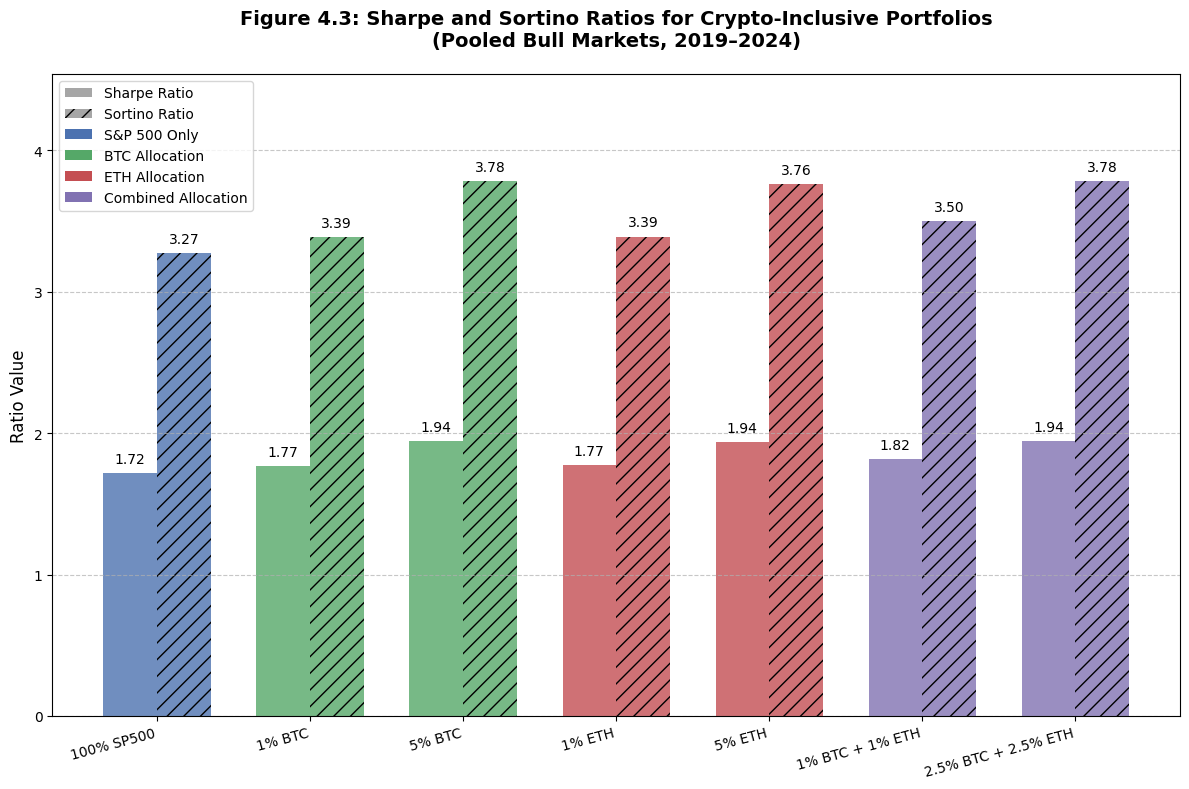

Creating Figure 4.4: CVaR Across Portfolios...


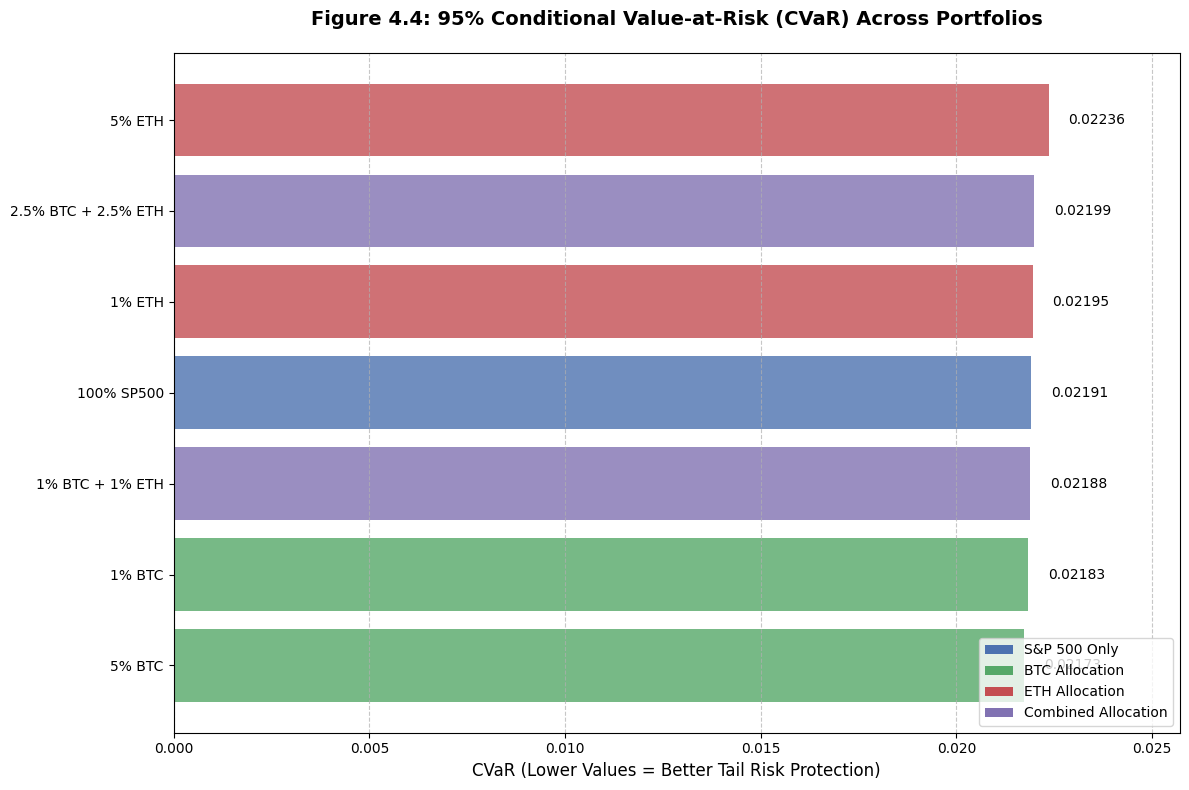

Creating Figure 4.5: Sharpe Ratios Across Bull Phases...


TypeError: 'float' object is not iterable

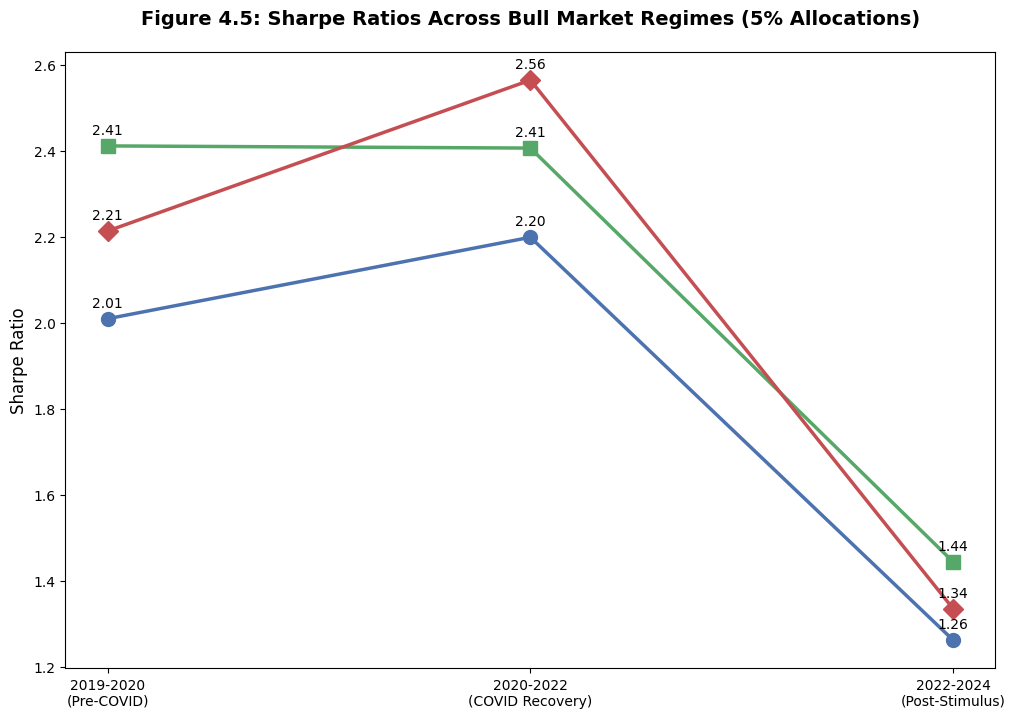

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import os

# ======================
# CONFIGURATION
# ======================
# Input files (generated from previous analysis)
POOLED_RESULTS_PATH = 'pooled_analysis_results_final.xlsx'
SUBPERIOD_RESULTS_PATH = 'subperiod_analysis_results_final.xlsx'

# Output settings
OUTPUT_DIR = 'visualizations'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Color scheme (colorblind-friendly)
COLORS = {
    'SP500': '#4C72B0',  # Blue
    'BTC': '#55A868',     # Green
    'ETH': '#C44E52',     # Red
    'Combined': '#8172B2' # Purple
}

# ======================
# DATA PREPARATION
# ======================
def load_and_prepare_data():
    """Loads and processes results from Excel files"""
    # Load pooled results
    pooled_df = pd.read_excel(POOLED_RESULTS_PATH, sheet_name='Pooled_Results')

    # Load subperiod results
    subperiod_df = pd.read_excel(SUBPERIOD_RESULTS_PATH, sheet_name='Subperiod_Results')

    # Filter key portfolios for visualization
    key_portfolios = [
        '100% SP500',
        '99% SP500, 1% BTC',
        '95% SP500, 5% BTC',
        '99% SP500, 1% ETH',
        '95% SP500, 5% ETH',
        '98% SP500, 1% BTC, 1% ETH',
        '95% SP500, 2.5% BTC, 2.5% ETH'
    ]

    pooled_filtered = pooled_df[pooled_df['Portfolio'].isin(key_portfolios)].copy()
    subperiod_filtered = subperiod_df[
        subperiod_df['Portfolio'].isin(['100% SP500', '95% SP500, 5% BTC', '95% SP500, 5% ETH'])
    ].copy()

    # Clean portfolio names for plotting
    portfolio_names = {
        '99% SP500, 1% BTC': '1% BTC',
        '95% SP500, 5% BTC': '5% BTC',
        '99% SP500, 1% ETH': '1% ETH',
        '95% SP500, 5% ETH': '5% ETH',
        '98% SP500, 1% BTC, 1% ETH': '1% BTC + 1% ETH',
        '95% SP500, 2.5% BTC, 2.5% ETH': '2.5% BTC + 2.5% ETH'
    }

    pooled_filtered['Portfolio'] = pooled_filtered['Portfolio'].replace(portfolio_names)
    subperiod_filtered['Portfolio'] = subperiod_filtered['Portfolio'].replace({
        '95% SP500, 5% BTC': '5% BTC',
        '95% SP500, 5% ETH': '5% ETH'
    })

    # Add category for coloring
    def assign_category(portfolio):
        if 'BTC' in portfolio and 'ETH' in portfolio:
            return 'Combined'
        elif 'BTC' in portfolio:
            return 'BTC'
        elif 'ETH' in portfolio:
            return 'ETH'
        else:
            return 'SP500'

    pooled_filtered['Category'] = pooled_filtered['Portfolio'].apply(assign_category)

    return pooled_filtered, subperiod_filtered

# ======================
# VISUALIZATION FUNCTIONS
# ======================
def create_figure_4_3(pooled_df):
    """Sharpe and Sortino Ratios for Crypto-Inclusive Portfolios"""
    plt.figure(figsize=(12, 8))

    # Set positions and width
    n = len(pooled_df)
    x = np.arange(n)
    width = 0.35

    # Create bars
    sharpe_bars = plt.bar(x - width/2, pooled_df['Sharpe Ratio'],
                          width, color=[COLORS[c] for c in pooled_df['Category']],
                          alpha=0.8, label='Sharpe Ratio')

    sortino_bars = plt.bar(x + width/2, pooled_df['Sortino Ratio'],
                           width, color=[COLORS[c] for c in pooled_df['Category']],
                           alpha=0.8, hatch='//', label='Sortino Ratio')

    # Add values on top of bars
    for i, (sharpe, sortino) in enumerate(zip(pooled_df['Sharpe Ratio'], pooled_df['Sortino Ratio'])):
        plt.text(i - width/2, sharpe + 0.05, f'{sharpe:.2f}',
                 ha='center', va='bottom', fontsize=10)
        plt.text(i + width/2, sortino + 0.05, f'{sortino:.2f}',
                 ha='center', va='bottom', fontsize=10)

    # Formatting
    plt.title('Figure 4.3: Sharpe and Sortino Ratios for Crypto-Inclusive Portfolios\n(Pooled Bull Markets, 2019–2024)',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Ratio Value', fontsize=12)
    plt.xticks(x, pooled_df['Portfolio'], rotation=15, ha='right')
    plt.ylim(0, max(pooled_df[['Sharpe Ratio', 'Sortino Ratio']].max()) * 1.2)

    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gray', alpha=0.7, label='Sharpe Ratio'),
        Patch(facecolor='gray', alpha=0.7, hatch='//', label='Sortino Ratio'),
        Patch(facecolor=COLORS['SP500'], label='S&P 500 Only'),
        Patch(facecolor=COLORS['BTC'], label='BTC Allocation'),
        Patch(facecolor=COLORS['ETH'], label='ETH Allocation'),
        Patch(facecolor=COLORS['Combined'], label='Combined Allocation')
    ]

    plt.legend(handles=legend_elements, loc='upper left', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save and show
    plt.savefig(f'{OUTPUT_DIR}/figure_4_3.png', dpi=300)
    plt.savefig(f'{OUTPUT_DIR}/figure_4_3.pdf')
    plt.show()

def create_figure_4_4(pooled_df):
    """95% Conditional Value-at-Risk (CVaR) Across Portfolios"""
    plt.figure(figsize=(12, 8))

    # Sort by CVaR (lowest risk first)
    df_sorted = pooled_df.sort_values('CVaR 95%')

    # Create horizontal bars
    bars = plt.barh(df_sorted['Portfolio'], df_sorted['CVaR 95%'],
                    color=[COLORS[c] for c in df_sorted['Category']],
                    alpha=0.8)

    # Add data labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.0005, bar.get_y() + bar.get_height()/2,
                 f'{width:.5f}',
                 ha='left', va='center', fontsize=10)

    # Formatting
    plt.title('Figure 4.4: 95% Conditional Value-at-Risk (CVaR) Across Portfolios',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('CVaR (Lower Values = Better Tail Risk Protection)', fontsize=12)
    plt.xlim(0, max(pooled_df['CVaR 95%']) * 1.15)

    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS['SP500'], label='S&P 500 Only'),
        Patch(facecolor=COLORS['BTC'], label='BTC Allocation'),
        Patch(facecolor=COLORS['ETH'], label='ETH Allocation'),
        Patch(facecolor=COLORS['Combined'], label='Combined Allocation')
    ]

    plt.legend(handles=legend_elements, loc='lower right', frameon=True)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save and show
    plt.savefig(f'{OUTPUT_DIR}/figure_4_4.png', dpi=300)
    plt.savefig(f'{OUTPUT_DIR}/figure_4_4.pdf')
    plt.show()

def create_figure_4_5(subperiod_df):
    """Sharpe Ratios Across Bull Market Regimes"""
    plt.figure(figsize=(12, 8))

    # Prepare data
    pivot_df = subperiod_df.pivot(index='Phase', columns='Portfolio', values='Sharpe Ratio')

    # Define bull phases with date ranges
    phase_names = {
        'Bull Phase 1': '2019-2020\n(Pre-COVID)',
        'Bull Phase 2': '2020-2022\n(COVID Recovery)',
        'Bull Phase 3': '2022-2024\n(Post-Stimulus)'
    }
    pivot_df.index = pivot_df.index.map(phase_names)

    # Create line plot
    markers = ['o', 's', 'D']  # Different markers for each portfolio
    for i, portfolio in enumerate(pivot_df.columns):
        plt.plot(pivot_df.index, pivot_df[portfolio],
                 label=portfolio,
                 color=COLORS['SP500'] if portfolio == '100% SP500'
                 else COLORS['BTC'] if 'BTC' in portfolio
                 else COLORS['ETH'],
                 marker=markers[i],
                 markersize=10,
                 linewidth=2.5)

    # Add data labels
    for phase in pivot_df.index:
        for portfolio in pivot_df.columns:
            value = pivot_df.loc[phase, portfolio]
            plt.text(phase, value + 0.02, f'{value:.2f}',
                     ha='center', va='bottom', fontsize=10)

    # Formatting
    plt.title('Figure 4.5: Sharpe Ratios Across Bull Market Regimes (5% Allocations)',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Sharpe Ratio', fontsize=12)
    plt.ylim(0, max(pivot_df.max().max()) * 1.25)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=3, frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save and show
    plt.savefig(f'{OUTPUT_DIR}/figure_4_5.png', dpi=300)
    plt.savefig(f'{OUTPUT_DIR}/figure_4_5.pdf')
    plt.show()

# ======================
# MAIN EXECUTION
# ======================
if __name__ == '__main__':
    # Load and prepare data
    print("Loading and preparing data...")
    pooled_df, subperiod_df = load_and_prepare_data()

    # Create visualizations
    print("Creating Figure 4.3: Sharpe and Sortino Ratios...")
    create_figure_4_3(pooled_df)

    print("Creating Figure 4.4: CVaR Across Portfolios...")
    create_figure_4_4(pooled_df)

    print("Creating Figure 4.5: Sharpe Ratios Across Bull Phases...")
    create_figure_4_5(subperiod_df)

    print(f"\n✅ All visualizations saved to '{OUTPUT_DIR}' directory")

#28.08.25 (Visualization Testing)
(10.08.25 yet result file ko thwar kyi pee run tar )

Loading and preparing data...
Pooled data columns: ['Portfolio', 'Annualized Return', 'Sharpe Ratio', 'Sortino Ratio', 'CVaR 95%', 'Category']
Subperiod data columns: ['Portfolio', 'Annualized Return', 'Sharpe Ratio', 'Sortino Ratio', 'CVaR 95%', 'Phase', 'Category']
Subperiod data phases: ['Bull Phase 1' 'Bull Phase 2' 'Bull Phase 3']
Creating Figure 4.3: Sharpe and Sortino Ratios...


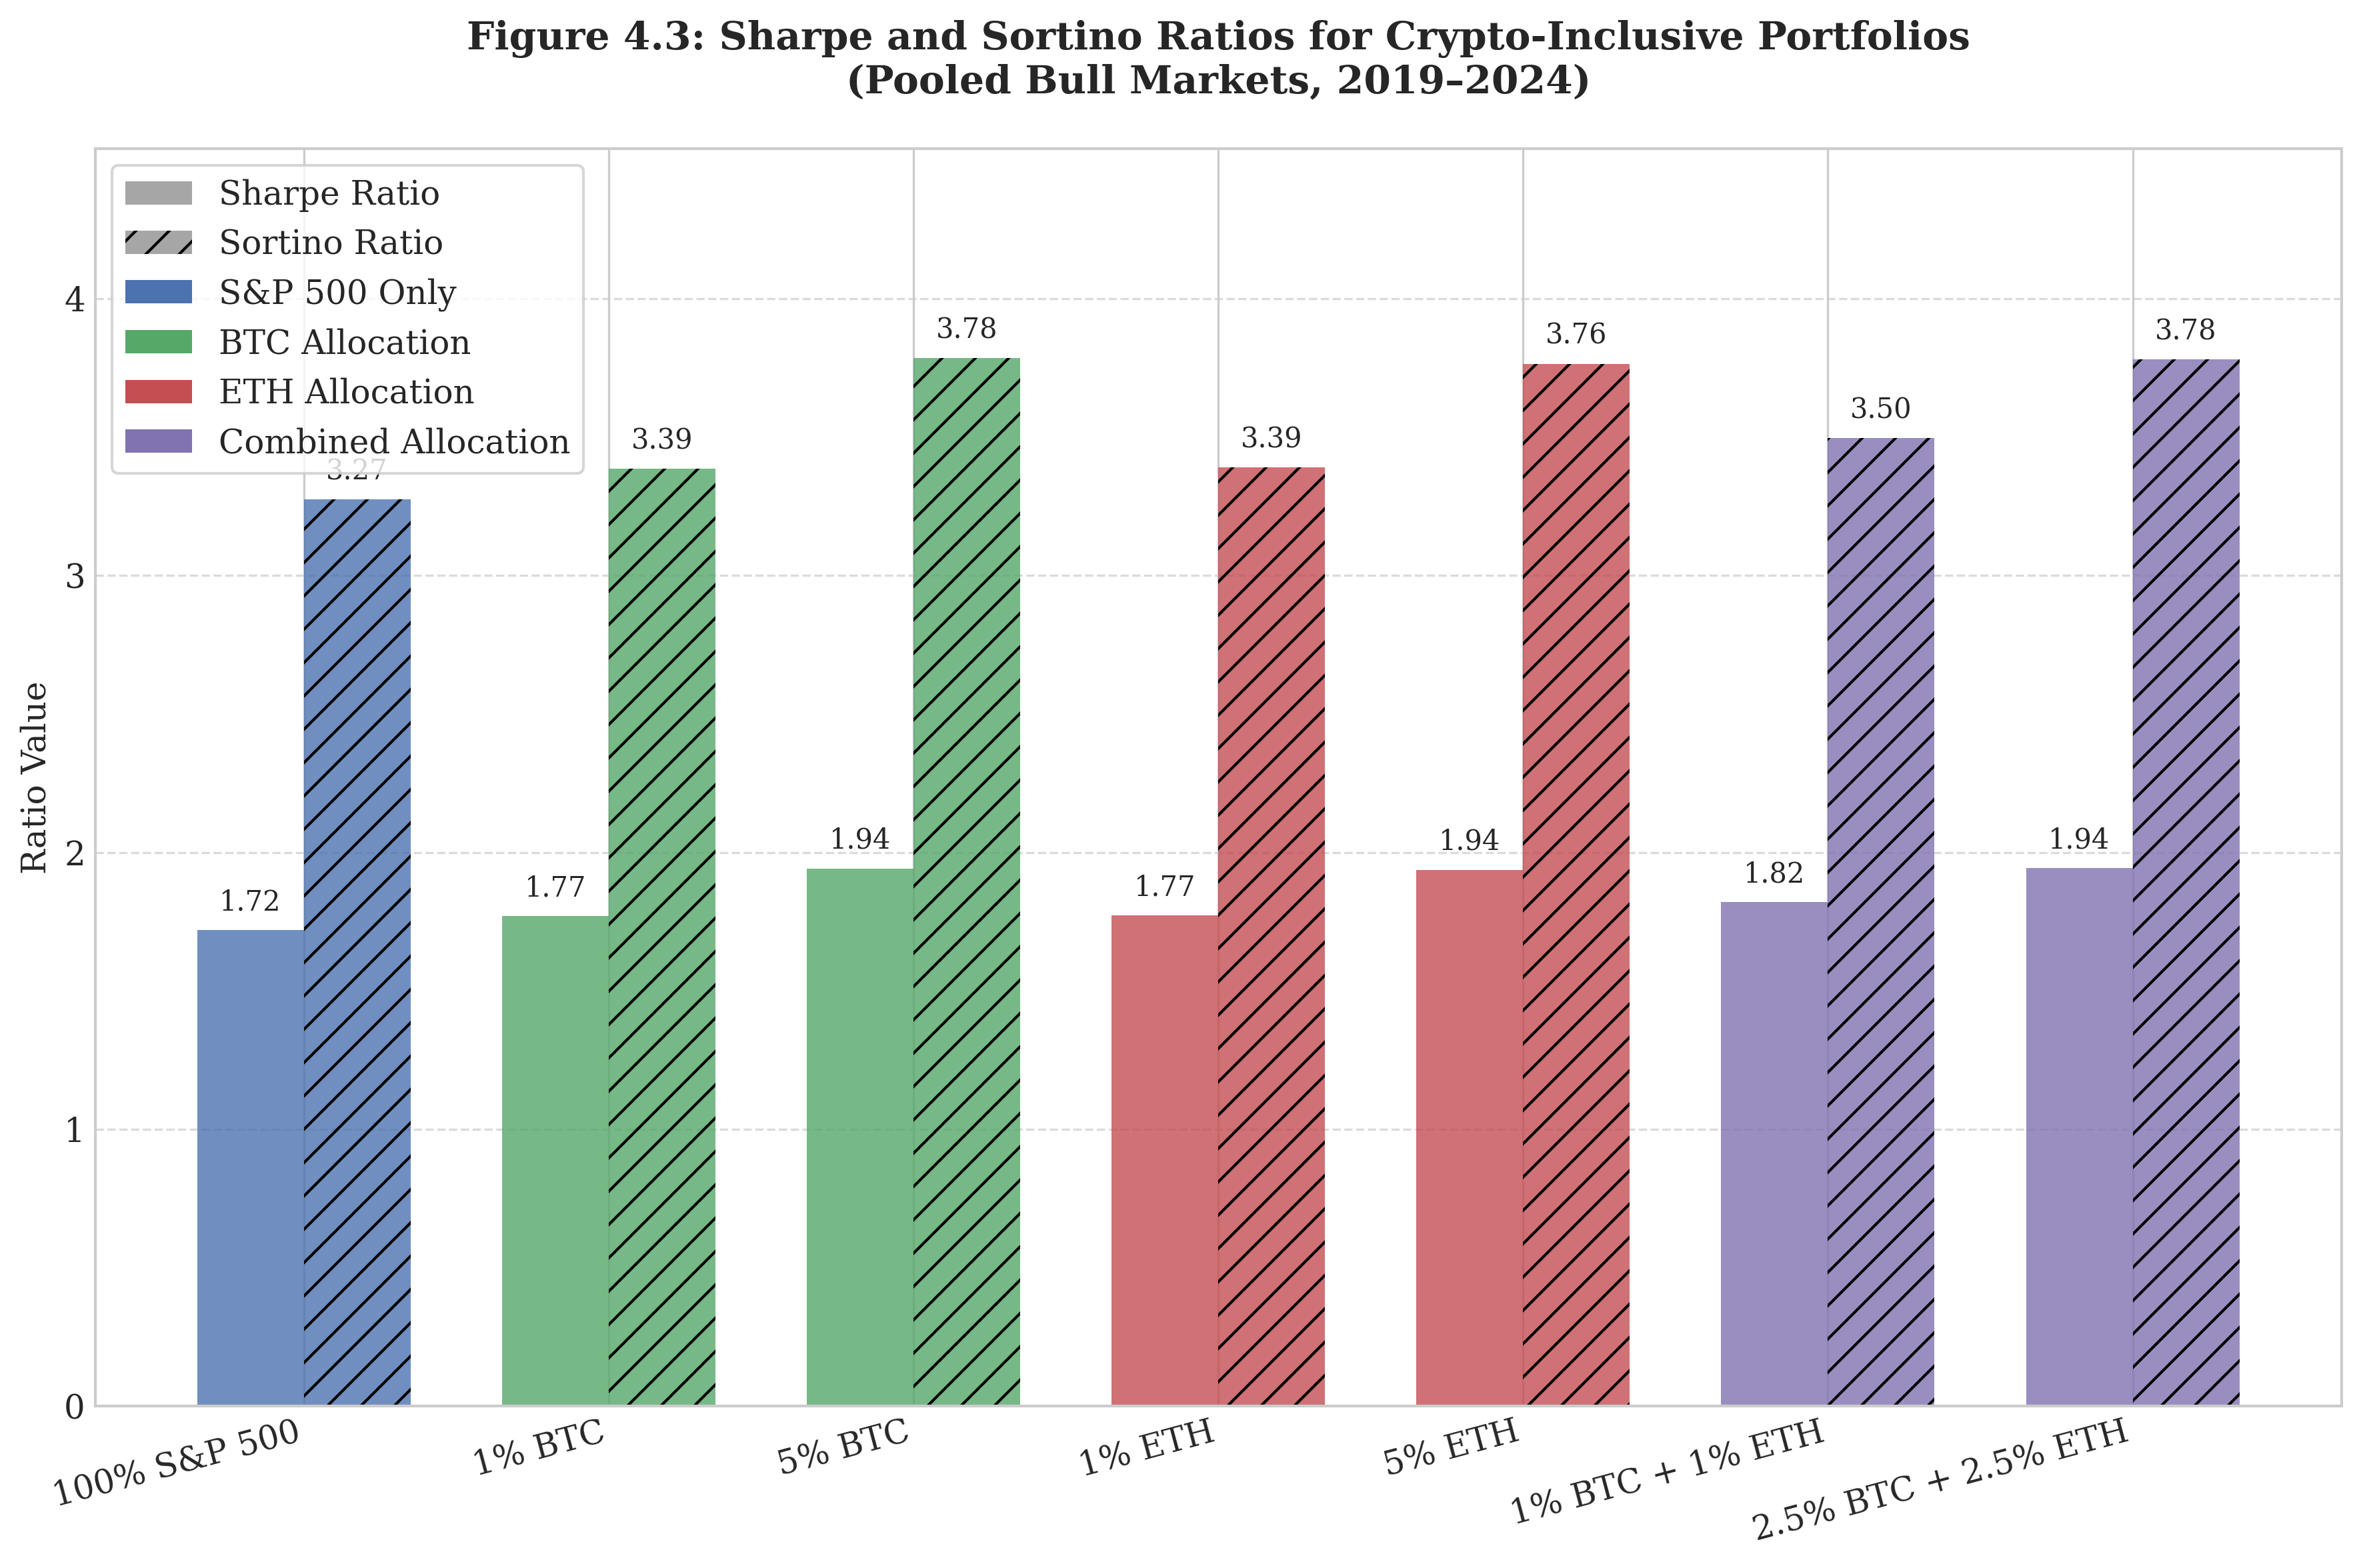

Creating Figure 4.4: CVaR Across Portfolios...


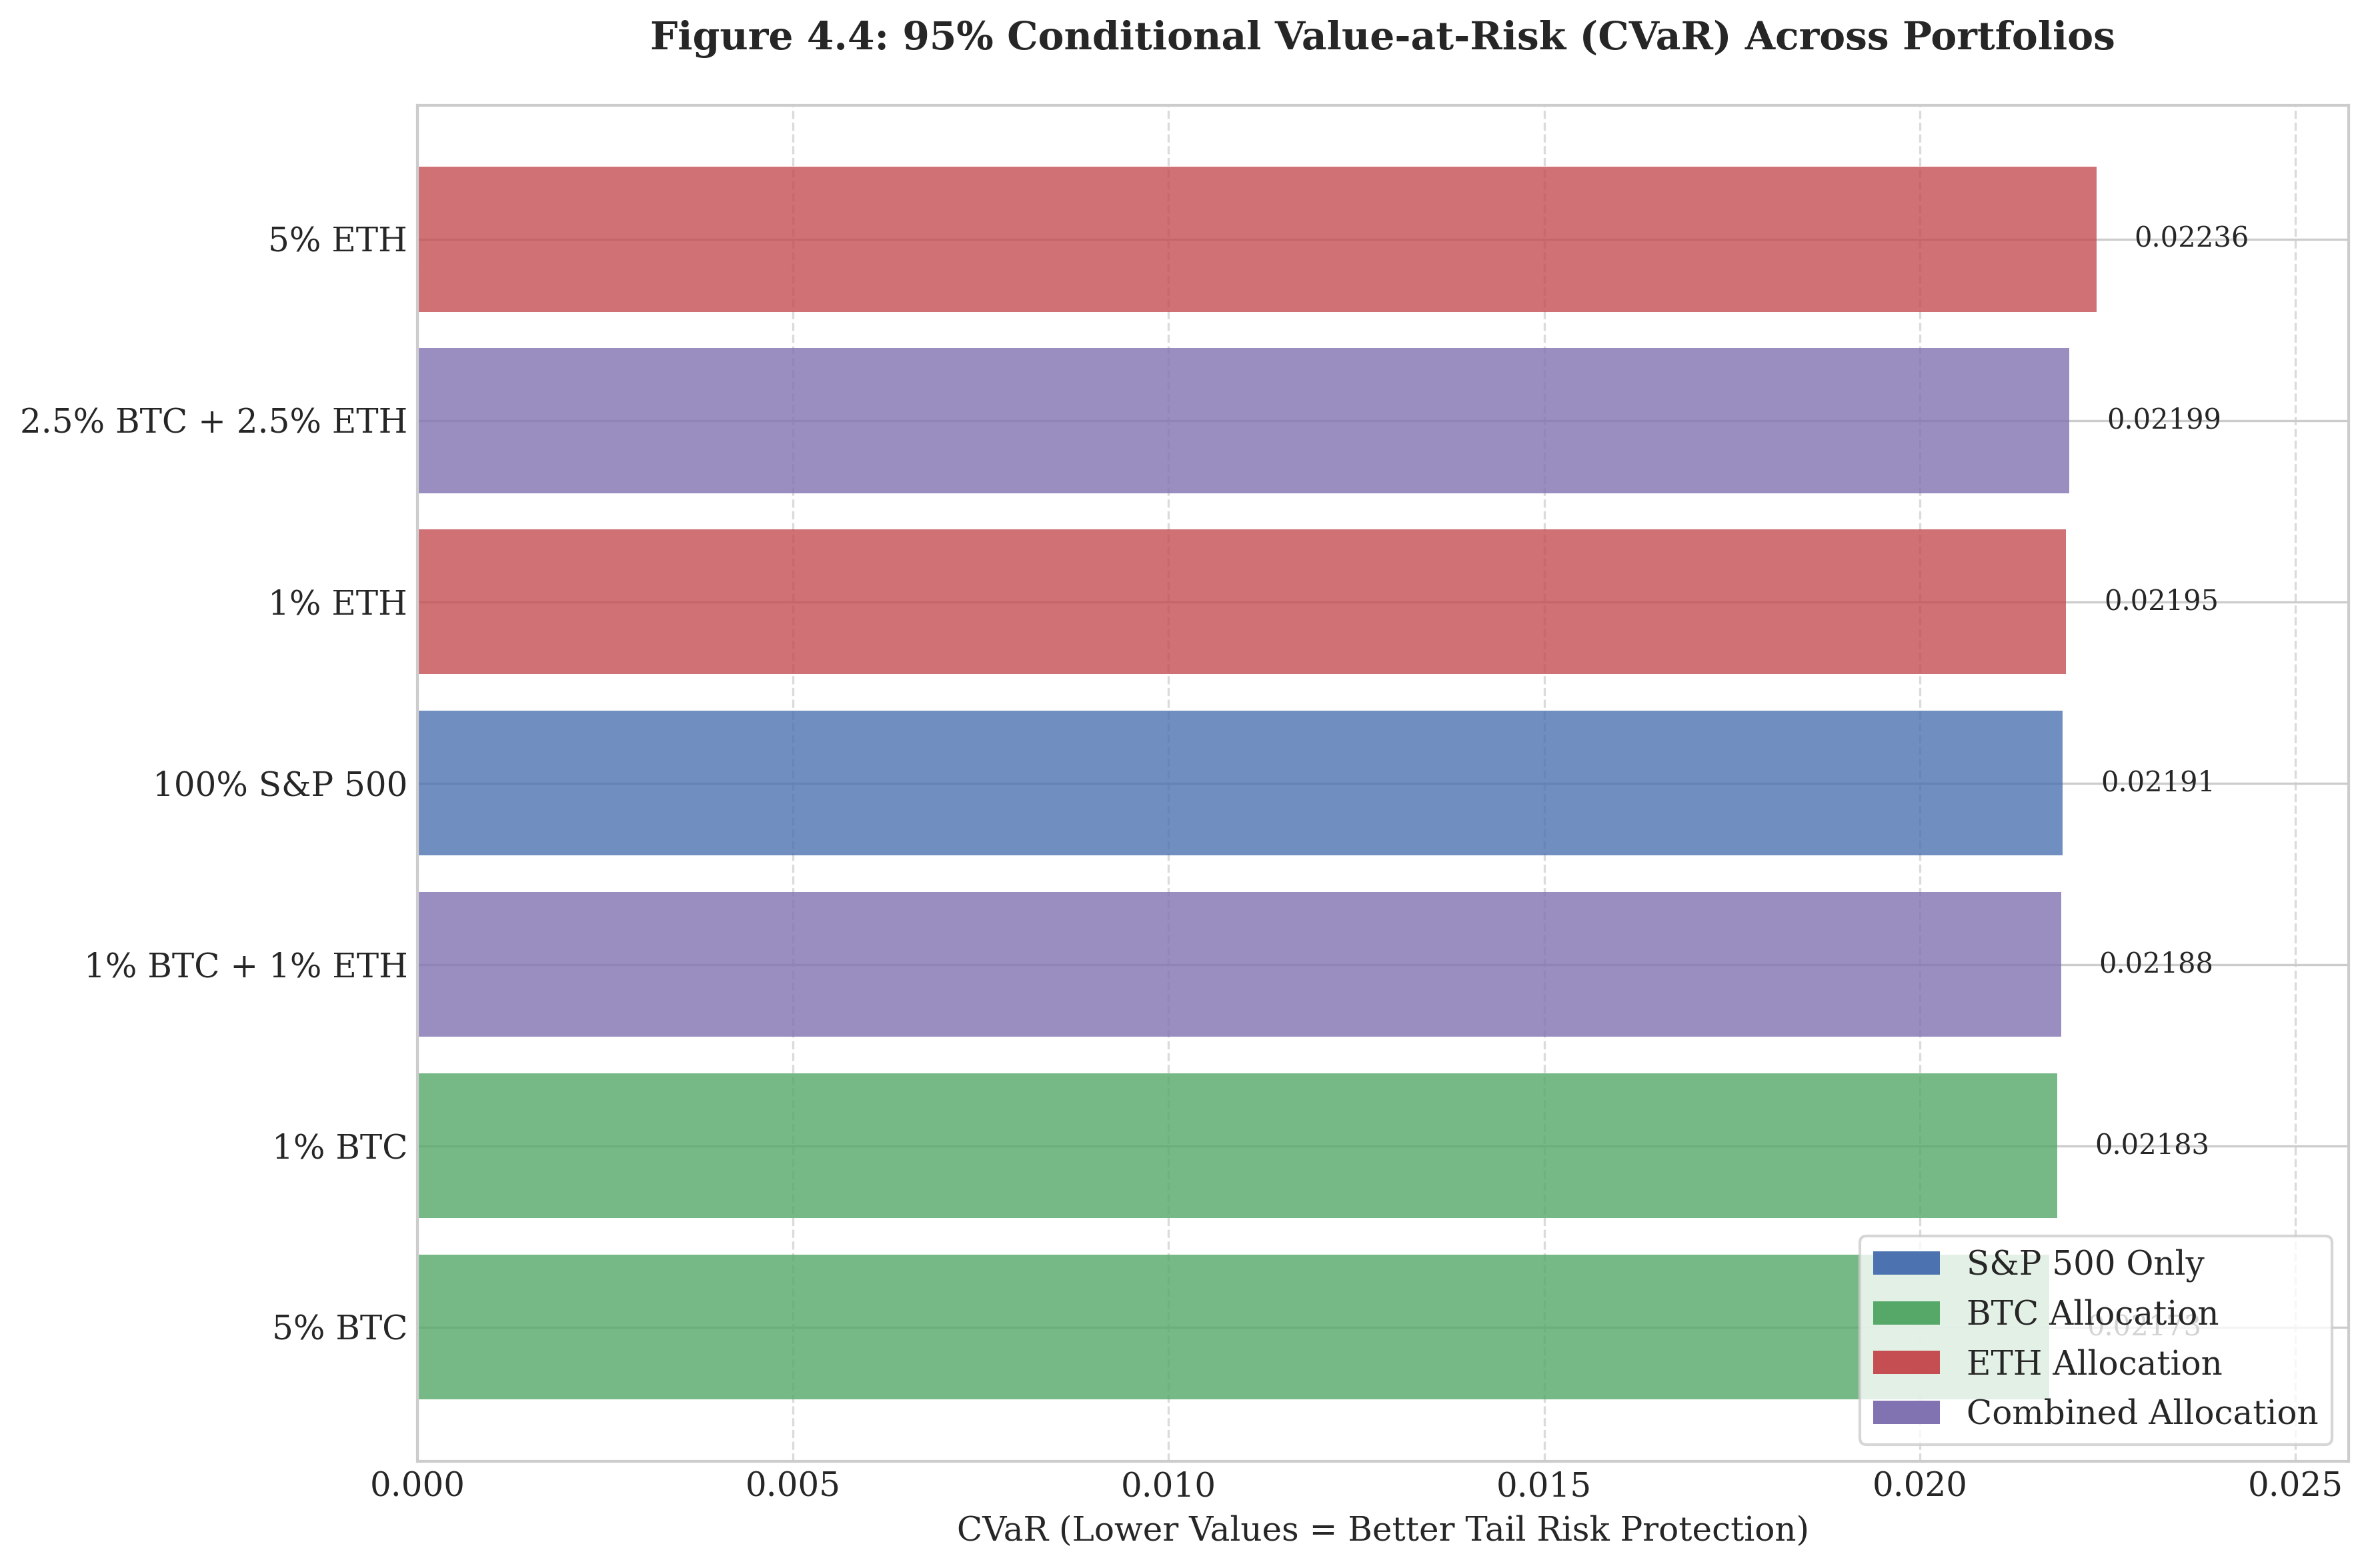

Creating Figure 4.5: Sharpe Ratios Across Bull Phases...
Subperiod DataFrame columns: ['Portfolio', 'Annualized Return', 'Sharpe Ratio', 'Sortino Ratio', 'CVaR 95%', 'Phase', 'Category']
Subperiod DataFrame sample:
       Portfolio  Annualized Return  Sharpe Ratio  Sortino Ratio  CVaR 95%  \
0   100% S&P 500           0.291440      2.009899       3.485417  0.019191   
5         5% BTC           0.339590      2.411569       4.383427  0.017234   
10        5% ETH           0.322340      2.213800       3.934684  0.018145   
18  100% S&P 500           0.511756      2.199212       4.255897  0.026439   
23        5% BTC           0.580488      2.406545       4.794759  0.026622   

           Phase Category  
0   Bull Phase 1    SP500  
5   Bull Phase 1      BTC  
10  Bull Phase 1      ETH  
18  Bull Phase 2    SP500  
23  Bull Phase 2      BTC  
Unique portfolios: ['100% S&P 500' '5% BTC' '5% ETH']
Pivot table created successfully:
Portfolio     100% S&P 500    5% BTC    5% ETH
Phase        

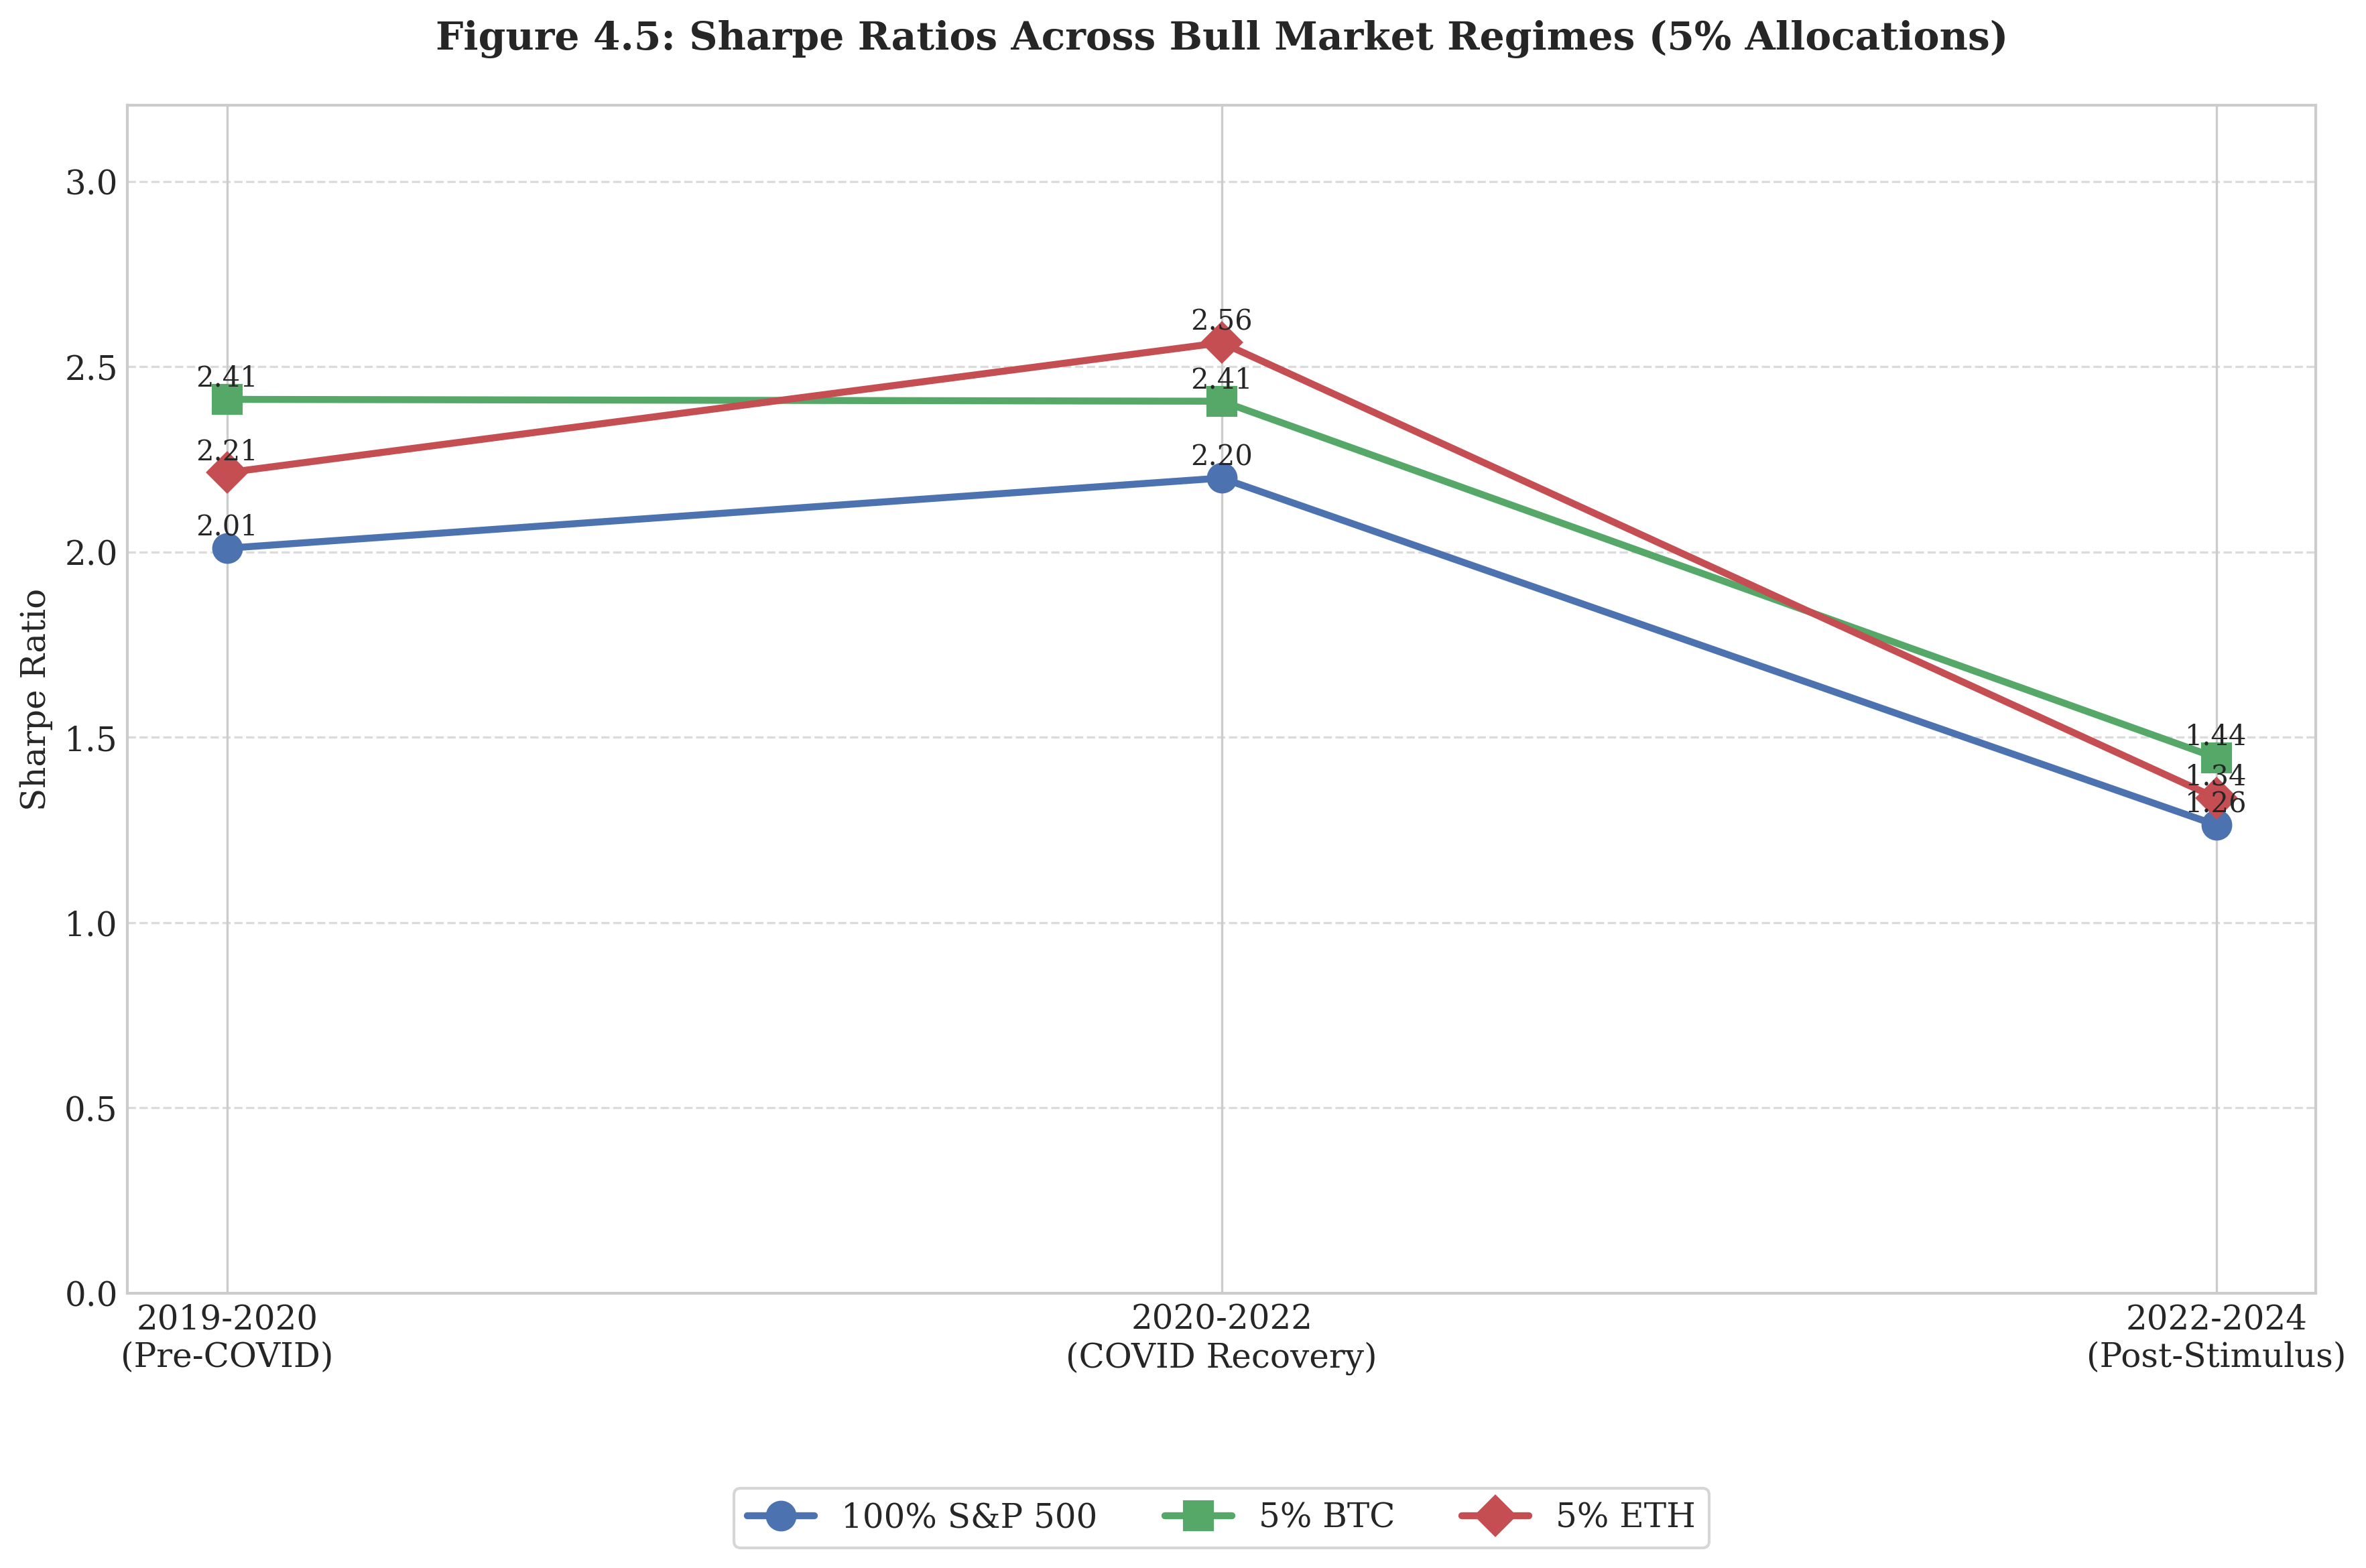

Creating Figure 4.6: Sortino Ratios Comparison...


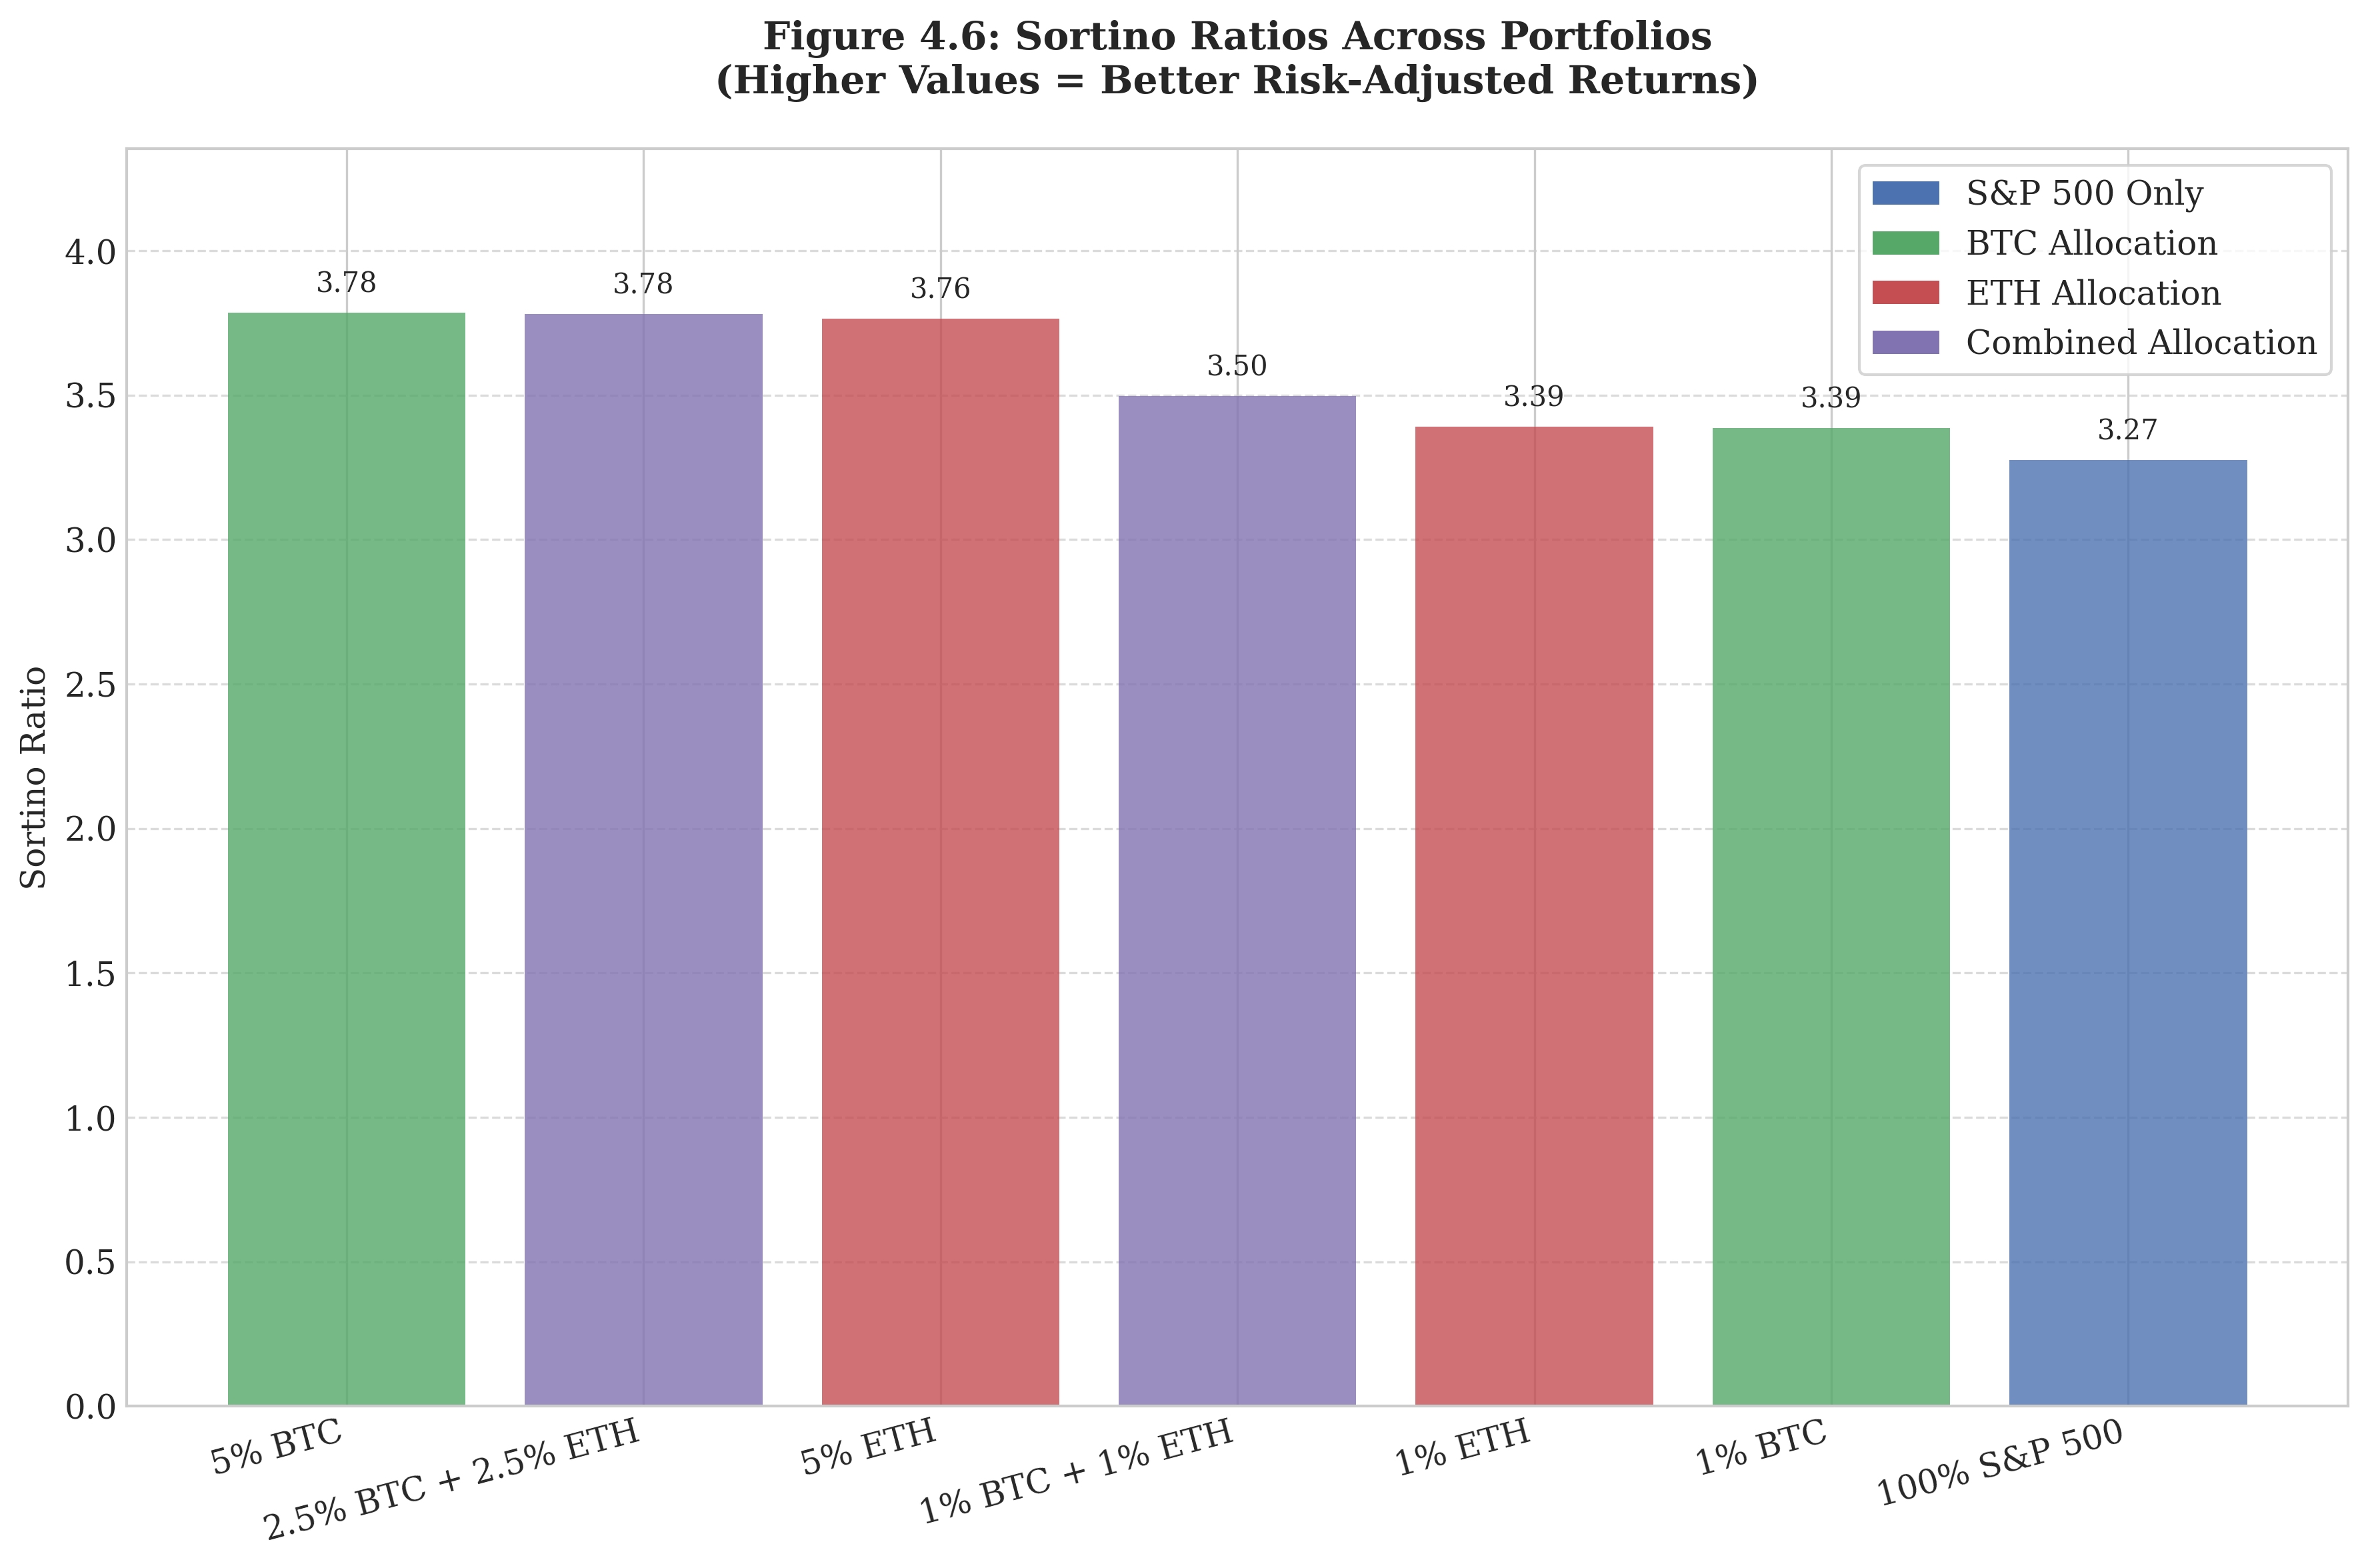


✅ All visualizations saved to 'visualizations' directory as PNG files


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import os

# ======================
# CONFIGURATION
# ======================
# Input files (generated from previous analysis)
POOLED_RESULTS_PATH = 'pooled_analysis_results_final.xlsx'
SUBPERIOD_RESULTS_PATH = 'subperiod_analysis_results_final.xlsx'

# Output settings
OUTPUT_DIR = 'visualizations'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Color scheme (colorblind-friendly)
COLORS = {
    'SP500': '#4C72B0',  # Blue
    'BTC': '#55A868',     # Green
    'ETH': '#C44E52',     # Red
    'Combined': '#8172B2' # Purple
}

# ======================
# DATA PREPARATION
# ======================
def load_and_prepare_data():
    """Loads and processes results from Excel files"""
    # Load pooled results
    pooled_df = pd.read_excel(POOLED_RESULTS_PATH, sheet_name='Pooled_Results')

    # Load subperiod results
    subperiod_df = pd.read_excel(SUBPERIOD_RESULTS_PATH, sheet_name='Subperiod_Results')

    # Filter key portfolios for visualization
    key_portfolios = [
        '100% SP500',
        '99% SP500, 1% BTC',
        '95% SP500, 5% BTC',
        '99% SP500, 1% ETH',
        '95% SP500, 5% ETH',
        '98% SP500, 1% BTC, 1% ETH',
        '95% SP500, 2.5% BTC, 2.5% ETH'
    ]

    pooled_filtered = pooled_df[pooled_df['Portfolio'].isin(key_portfolios)].copy()
    subperiod_filtered = subperiod_df[
        subperiod_df['Portfolio'].isin(['100% SP500', '95% SP500, 5% BTC', '95% SP500, 5% ETH'])
    ].copy()

    # Clean portfolio names for plotting
    portfolio_names = {
        '100% SP500': '100% S&P 500',
        '99% SP500, 1% BTC': '1% BTC',
        '95% SP500, 5% BTC': '5% BTC',
        '99% SP500, 1% ETH': '1% ETH',
        '95% SP500, 5% ETH': '5% ETH',
        '98% SP500, 1% BTC, 1% ETH': '1% BTC + 1% ETH',
        '95% SP500, 2.5% BTC, 2.5% ETH': '2.5% BTC + 2.5% ETH'
    }

    pooled_filtered['Portfolio'] = pooled_filtered['Portfolio'].replace(portfolio_names)
    subperiod_filtered['Portfolio'] = subperiod_filtered['Portfolio'].replace({
        '100% SP500': '100% S&P 500',
        '95% SP500, 5% BTC': '5% BTC',
        '95% SP500, 5% ETH': '5% ETH'
    })

    # Add category for coloring
    def assign_category(portfolio):
        if 'BTC' in portfolio and 'ETH' in portfolio:
            return 'Combined'
        elif 'BTC' in portfolio:
            return 'BTC'
        elif 'ETH' in portfolio:
            return 'ETH'
        else:
            return 'SP500'

    pooled_filtered['Category'] = pooled_filtered['Portfolio'].apply(assign_category)
    subperiod_filtered['Category'] = subperiod_filtered['Portfolio'].apply(assign_category)

    return pooled_filtered, subperiod_filtered

# ======================
# VISUALIZATION FUNCTIONS
# ======================
def create_figure_4_3(pooled_df):
    """Sharpe and Sortino Ratios for Crypto-Inclusive Portfolios"""
    plt.figure(figsize=(12, 8))

    # Set positions and width
    n = len(pooled_df)
    x = np.arange(n)
    width = 0.35

    # Create bars
    sharpe_bars = plt.bar(x - width/2, pooled_df['Sharpe Ratio'],
                          width, color=[COLORS[c] for c in pooled_df['Category']],
                          alpha=0.8, label='Sharpe Ratio')

    sortino_bars = plt.bar(x + width/2, pooled_df['Sortino Ratio'],
                           width, color=[COLORS[c] for c in pooled_df['Category']],
                           alpha=0.8, hatch='//', label='Sortino Ratio')

    # Add values on top of bars
    for i, (sharpe, sortino) in enumerate(zip(pooled_df['Sharpe Ratio'], pooled_df['Sortino Ratio'])):
        plt.text(i - width/2, sharpe + 0.05, f'{sharpe:.2f}',
                 ha='center', va='bottom', fontsize=10)
        plt.text(i + width/2, sortino + 0.05, f'{sortino:.2f}',
                 ha='center', va='bottom', fontsize=10)

    # Formatting
    plt.title('Figure 4.3: Sharpe and Sortino Ratios for Crypto-Inclusive Portfolios\n(Pooled Bull Markets, 2019–2024)',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Ratio Value', fontsize=12)
    plt.xticks(x, pooled_df['Portfolio'], rotation=15, ha='right')
    plt.ylim(0, max(pooled_df[['Sharpe Ratio', 'Sortino Ratio']].max()) * 1.2)

    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gray', alpha=0.7, label='Sharpe Ratio'),
        Patch(facecolor='gray', alpha=0.7, hatch='//', label='Sortino Ratio'),
        Patch(facecolor=COLORS['SP500'], label='S&P 500 Only'),
        Patch(facecolor=COLORS['BTC'], label='BTC Allocation'),
        Patch(facecolor=COLORS['ETH'], label='ETH Allocation'),
        Patch(facecolor=COLORS['Combined'], label='Combined Allocation')
    ]

    plt.legend(handles=legend_elements, loc='upper left', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save and show
    plt.savefig(f'{OUTPUT_DIR}/figure_4_3.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{OUTPUT_DIR}/figure_4_3.pdf', bbox_inches='tight')
    plt.show()

def create_figure_4_4(pooled_df):
    """95% Conditional Value-at-Risk (CVaR) Across Portfolios"""
    plt.figure(figsize=(12, 8))

    # Sort by CVaR (lowest risk first)
    df_sorted = pooled_df.sort_values('CVaR 95%')

    # Create horizontal bars
    bars = plt.barh(df_sorted['Portfolio'], df_sorted['CVaR 95%'],
                    color=[COLORS[c] for c in df_sorted['Category']],
                    alpha=0.8)

    # Add data labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.0005, bar.get_y() + bar.get_height()/2,
                 f'{width:.5f}',
                 ha='left', va='center', fontsize=10)

    # Formatting
    plt.title('Figure 4.4: 95% Conditional Value-at-Risk (CVaR) Across Portfolios',
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('CVaR (Lower Values = Better Tail Risk Protection)', fontsize=12)
    plt.xlim(0, max(pooled_df['CVaR 95%']) * 1.15)

    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS['SP500'], label='S&P 500 Only'),
        Patch(facecolor=COLORS['BTC'], label='BTC Allocation'),
        Patch(facecolor=COLORS['ETH'], label='ETH Allocation'),
        Patch(facecolor=COLORS['Combined'], label='Combined Allocation')
    ]

    plt.legend(handles=legend_elements, loc='lower right', frameon=True)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save and show
    plt.savefig(f'{OUTPUT_DIR}/figure_4_4.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{OUTPUT_DIR}/figure_4_4.pdf', bbox_inches='tight')
    plt.show()

def create_figure_4_5(subperiod_df):
    """Sharpe Ratios Across Bull Market Regimes"""
    plt.figure(figsize=(12, 8))

    # Debug: Print the columns to understand the data structure
    print("Subperiod DataFrame columns:", subperiod_df.columns.tolist())
    print("Subperiod DataFrame sample:")
    print(subperiod_df.head())

    # Check if the required columns exist
    if 'Phase' not in subperiod_df.columns or 'Sharpe Ratio' not in subperiod_df.columns:
        print("Error: Required columns ('Phase' or 'Sharpe Ratio') not found in subperiod data")
        print("Available columns:", subperiod_df.columns.tolist())
        return

    # Check if we have the expected portfolio types
    print("Unique portfolios:", subperiod_df['Portfolio'].unique())

    # Prepare data - ensure we have the right portfolios
    target_portfolios = ['100% S&P 500', '5% BTC', '5% ETH']
    available_portfolios = [p for p in target_portfolios if p in subperiod_df['Portfolio'].values]

    if len(available_portfolios) < 2:
        print("Error: Not enough portfolio types found for comparison")
        print("Available:", subperiod_df['Portfolio'].unique())
        return

    # Filter to only include the portfolios we want to plot
    filtered_df = subperiod_df[subperiod_df['Portfolio'].isin(available_portfolios)].copy()

    # Prepare data using pivot
    try:
        pivot_df = filtered_df.pivot(index='Phase', columns='Portfolio', values='Sharpe Ratio')
        print("Pivot table created successfully:")
        print(pivot_df)
    except Exception as e:
        print(f"Error creating pivot table: {e}")
        # Alternative approach: manual grouping
        pivot_data = {}
        for portfolio in available_portfolios:
            portfolio_data = filtered_df[filtered_df['Portfolio'] == portfolio]
            pivot_data[portfolio] = portfolio_data.set_index('Phase')['Sharpe Ratio']

        pivot_df = pd.DataFrame(pivot_data)
        print("Using alternative approach, created DataFrame:")
        print(pivot_df)

    # Define bull phases with date ranges (map if needed)
    phase_names = {
        'Bull Phase 1': '2019-2020\n(Pre-COVID)',
        'Bull Phase 2': '2020-2022\n(COVID Recovery)',
        'Bull Phase 3': '2022-2024\n(Post-Stimulus)'
    }

    # Map phase names if they exist in the index
    if not pivot_df.empty:
        new_index = []
        for phase in pivot_df.index:
            new_index.append(phase_names.get(phase, phase))
        pivot_df.index = new_index

    # Create line plot
    markers = ['o', 's', 'D', '^', 'v']  # Different markers for each portfolio
    colors = {
        '100% S&P 500': COLORS['SP500'],
        '5% BTC': COLORS['BTC'],
        '5% ETH': COLORS['ETH']
    }

    for i, portfolio in enumerate(pivot_df.columns):
        plt.plot(pivot_df.index, pivot_df[portfolio],
                 label=portfolio,
                 color=colors.get(portfolio, list(COLORS.values())[i % len(COLORS)]),
                 marker=markers[i % len(markers)],
                 markersize=10,
                 linewidth=2.5)

    # Add data labels
    for phase in pivot_df.index:
        for portfolio in pivot_df.columns:
            value = pivot_df.loc[phase, portfolio]
            if not pd.isna(value):  # Only add label if value exists
                plt.text(phase, value + 0.02, f'{value:.2f}',
                         ha='center', va='bottom', fontsize=10)

    # Set y-axis limits safely
    y_max = pivot_df.max().max()
    if not pd.isna(y_max):
        plt.ylim(0, y_max * 1.25)
    else:
        plt.ylim(0, 3)  # Default range if data is missing

    # Formatting
    plt.title('Figure 4.5: Sharpe Ratios Across Bull Market Regimes (5% Allocations)',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Sharpe Ratio', fontsize=12)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=3, frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save and show
    plt.savefig(f'{OUTPUT_DIR}/figure_4_5.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{OUTPUT_DIR}/figure_4_5.pdf', bbox_inches='tight')
    plt.show()

def create_figure_4_6(pooled_df):
    """Create an additional figure showing Sortino Ratio comparison"""
    plt.figure(figsize=(12, 8))

    # Sort by Sortino Ratio (highest first)
    df_sorted = pooled_df.sort_values('Sortino Ratio', ascending=False)

    # Create bars
    bars = plt.bar(df_sorted['Portfolio'], df_sorted['Sortino Ratio'],
                   color=[COLORS[c] for c in df_sorted['Category']],
                   alpha=0.8)

    # Add data labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=10)

    # Formatting
    plt.title('Figure 4.6: Sortino Ratios Across Portfolios\n(Higher Values = Better Risk-Adjusted Returns)',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Sortino Ratio', fontsize=12)
    plt.xticks(rotation=15, ha='right')
    plt.ylim(0, max(pooled_df['Sortino Ratio']) * 1.15)

    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS['SP500'], label='S&P 500 Only'),
        Patch(facecolor=COLORS['BTC'], label='BTC Allocation'),
        Patch(facecolor=COLORS['ETH'], label='ETH Allocation'),
        Patch(facecolor=COLORS['Combined'], label='Combined Allocation')
    ]

    plt.legend(handles=legend_elements, loc='upper right', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save and show
    plt.savefig(f'{OUTPUT_DIR}/figure_4_6.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{OUTPUT_DIR}/figure_4_6.pdf', bbox_inches='tight')
    plt.show()

# ======================
# MAIN EXECUTION
# ======================
if __name__ == '__main__':
    # Load and prepare data
    print("Loading and preparing data...")
    pooled_df, subperiod_df = load_and_prepare_data()

    # Print data info for debugging
    print("Pooled data columns:", pooled_df.columns.tolist())
    print("Subperiod data columns:", subperiod_df.columns.tolist())
    print("Subperiod data phases:", subperiod_df['Phase'].unique() if 'Phase' in subperiod_df.columns else "'Phase' column not found")

    # Create visualizations
    print("Creating Figure 4.3: Sharpe and Sortino Ratios...")
    create_figure_4_3(pooled_df)

    print("Creating Figure 4.4: CVaR Across Portfolios...")
    create_figure_4_4(pooled_df)

    print("Creating Figure 4.5: Sharpe Ratios Across Bull Phases...")
    create_figure_4_5(subperiod_df)

    print("Creating Figure 4.6: Sortino Ratios Comparison...")
    create_figure_4_6(pooled_df)

    print(f"\n✅ All visualizations saved to '{OUTPUT_DIR}' directory as PNG files")

#Thesis (Figures 4.3, 4.4,4.5)

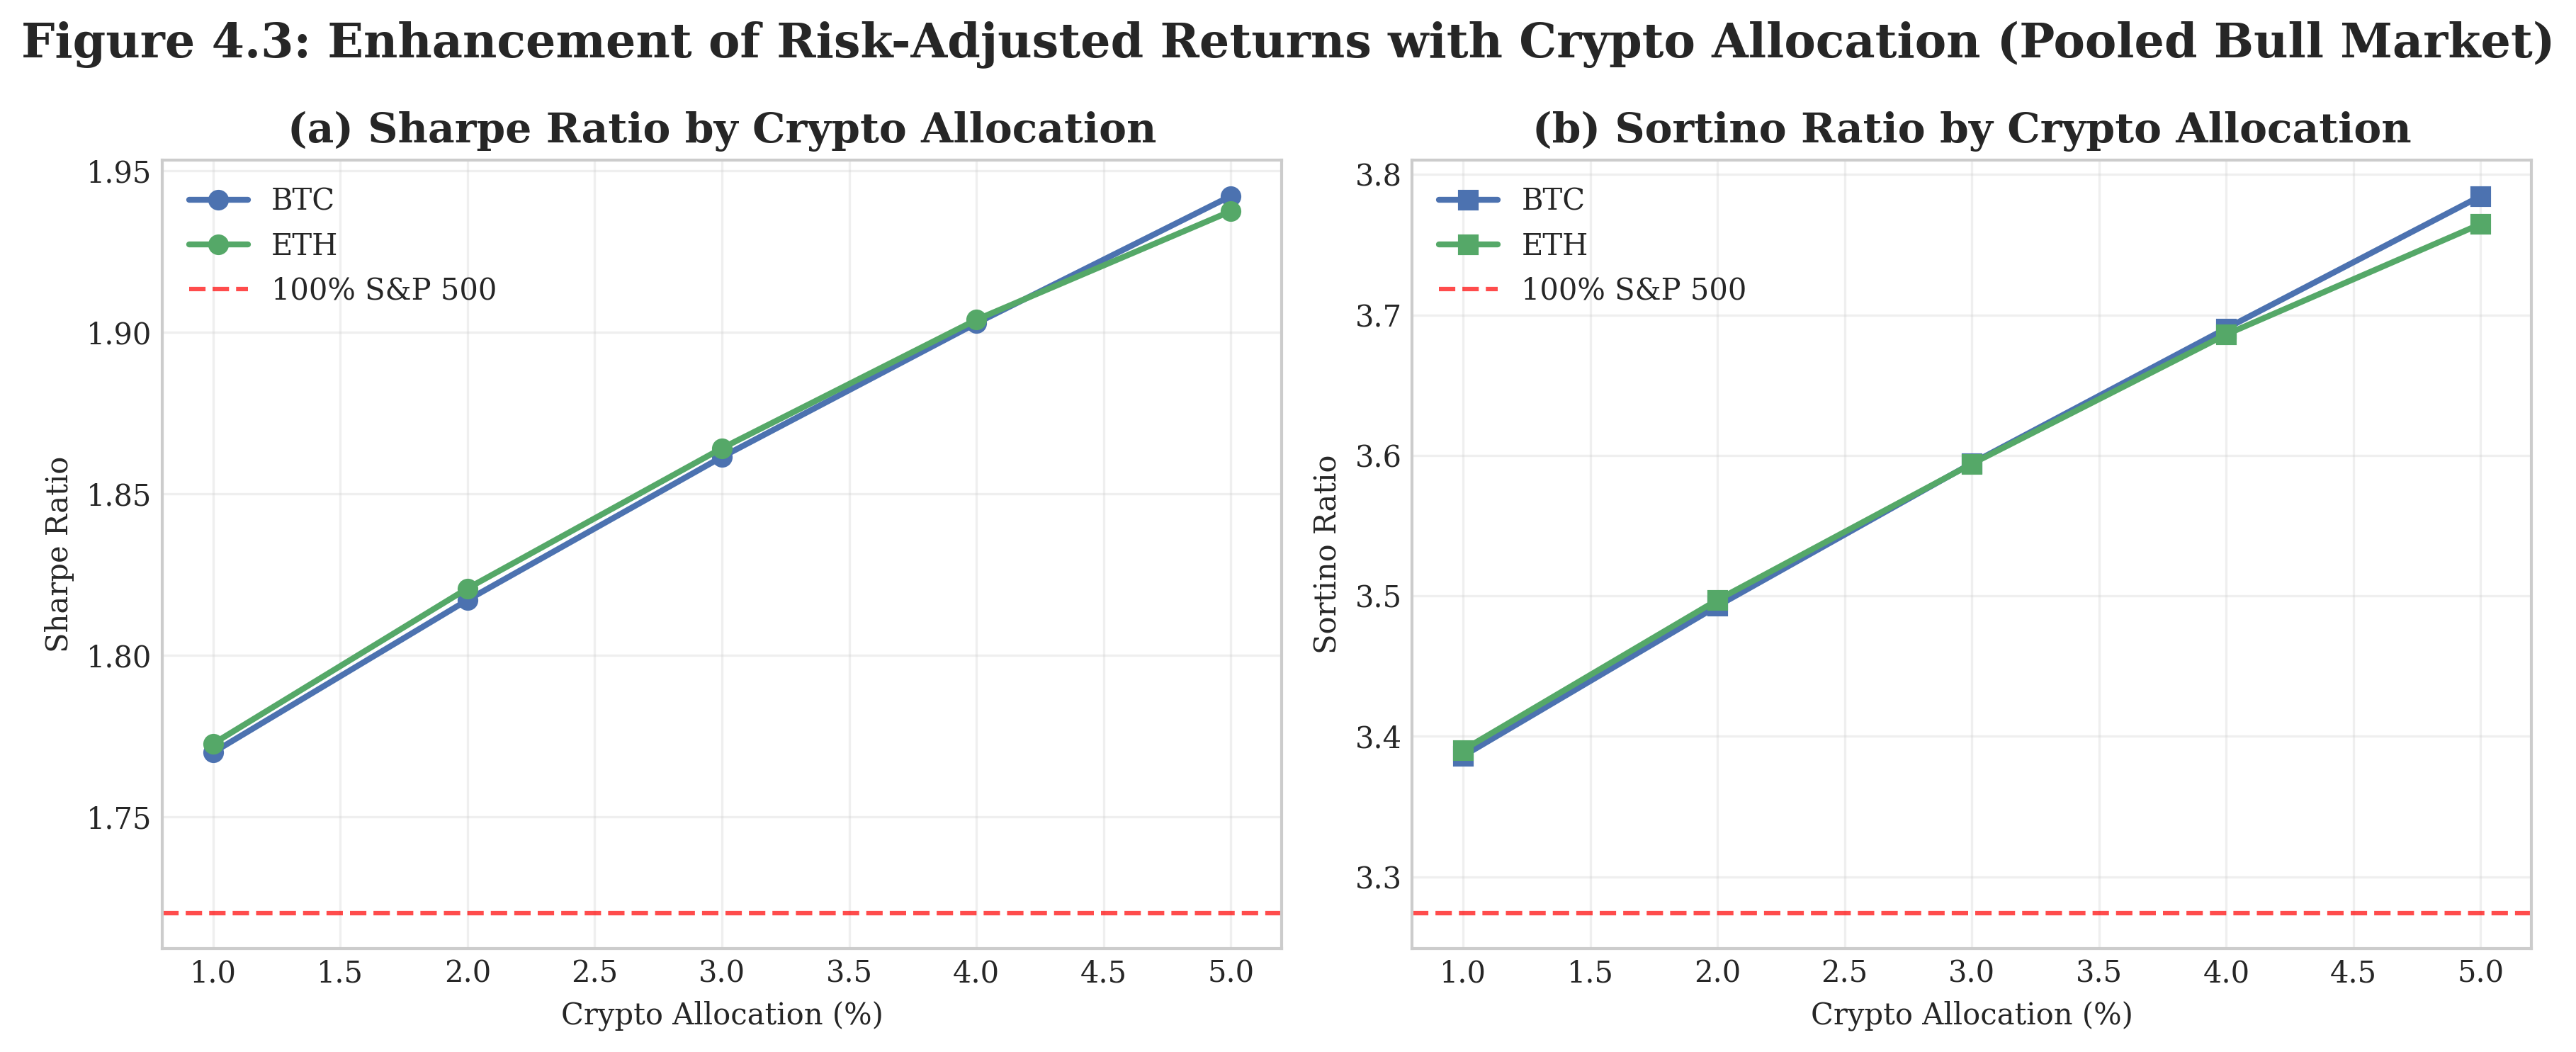

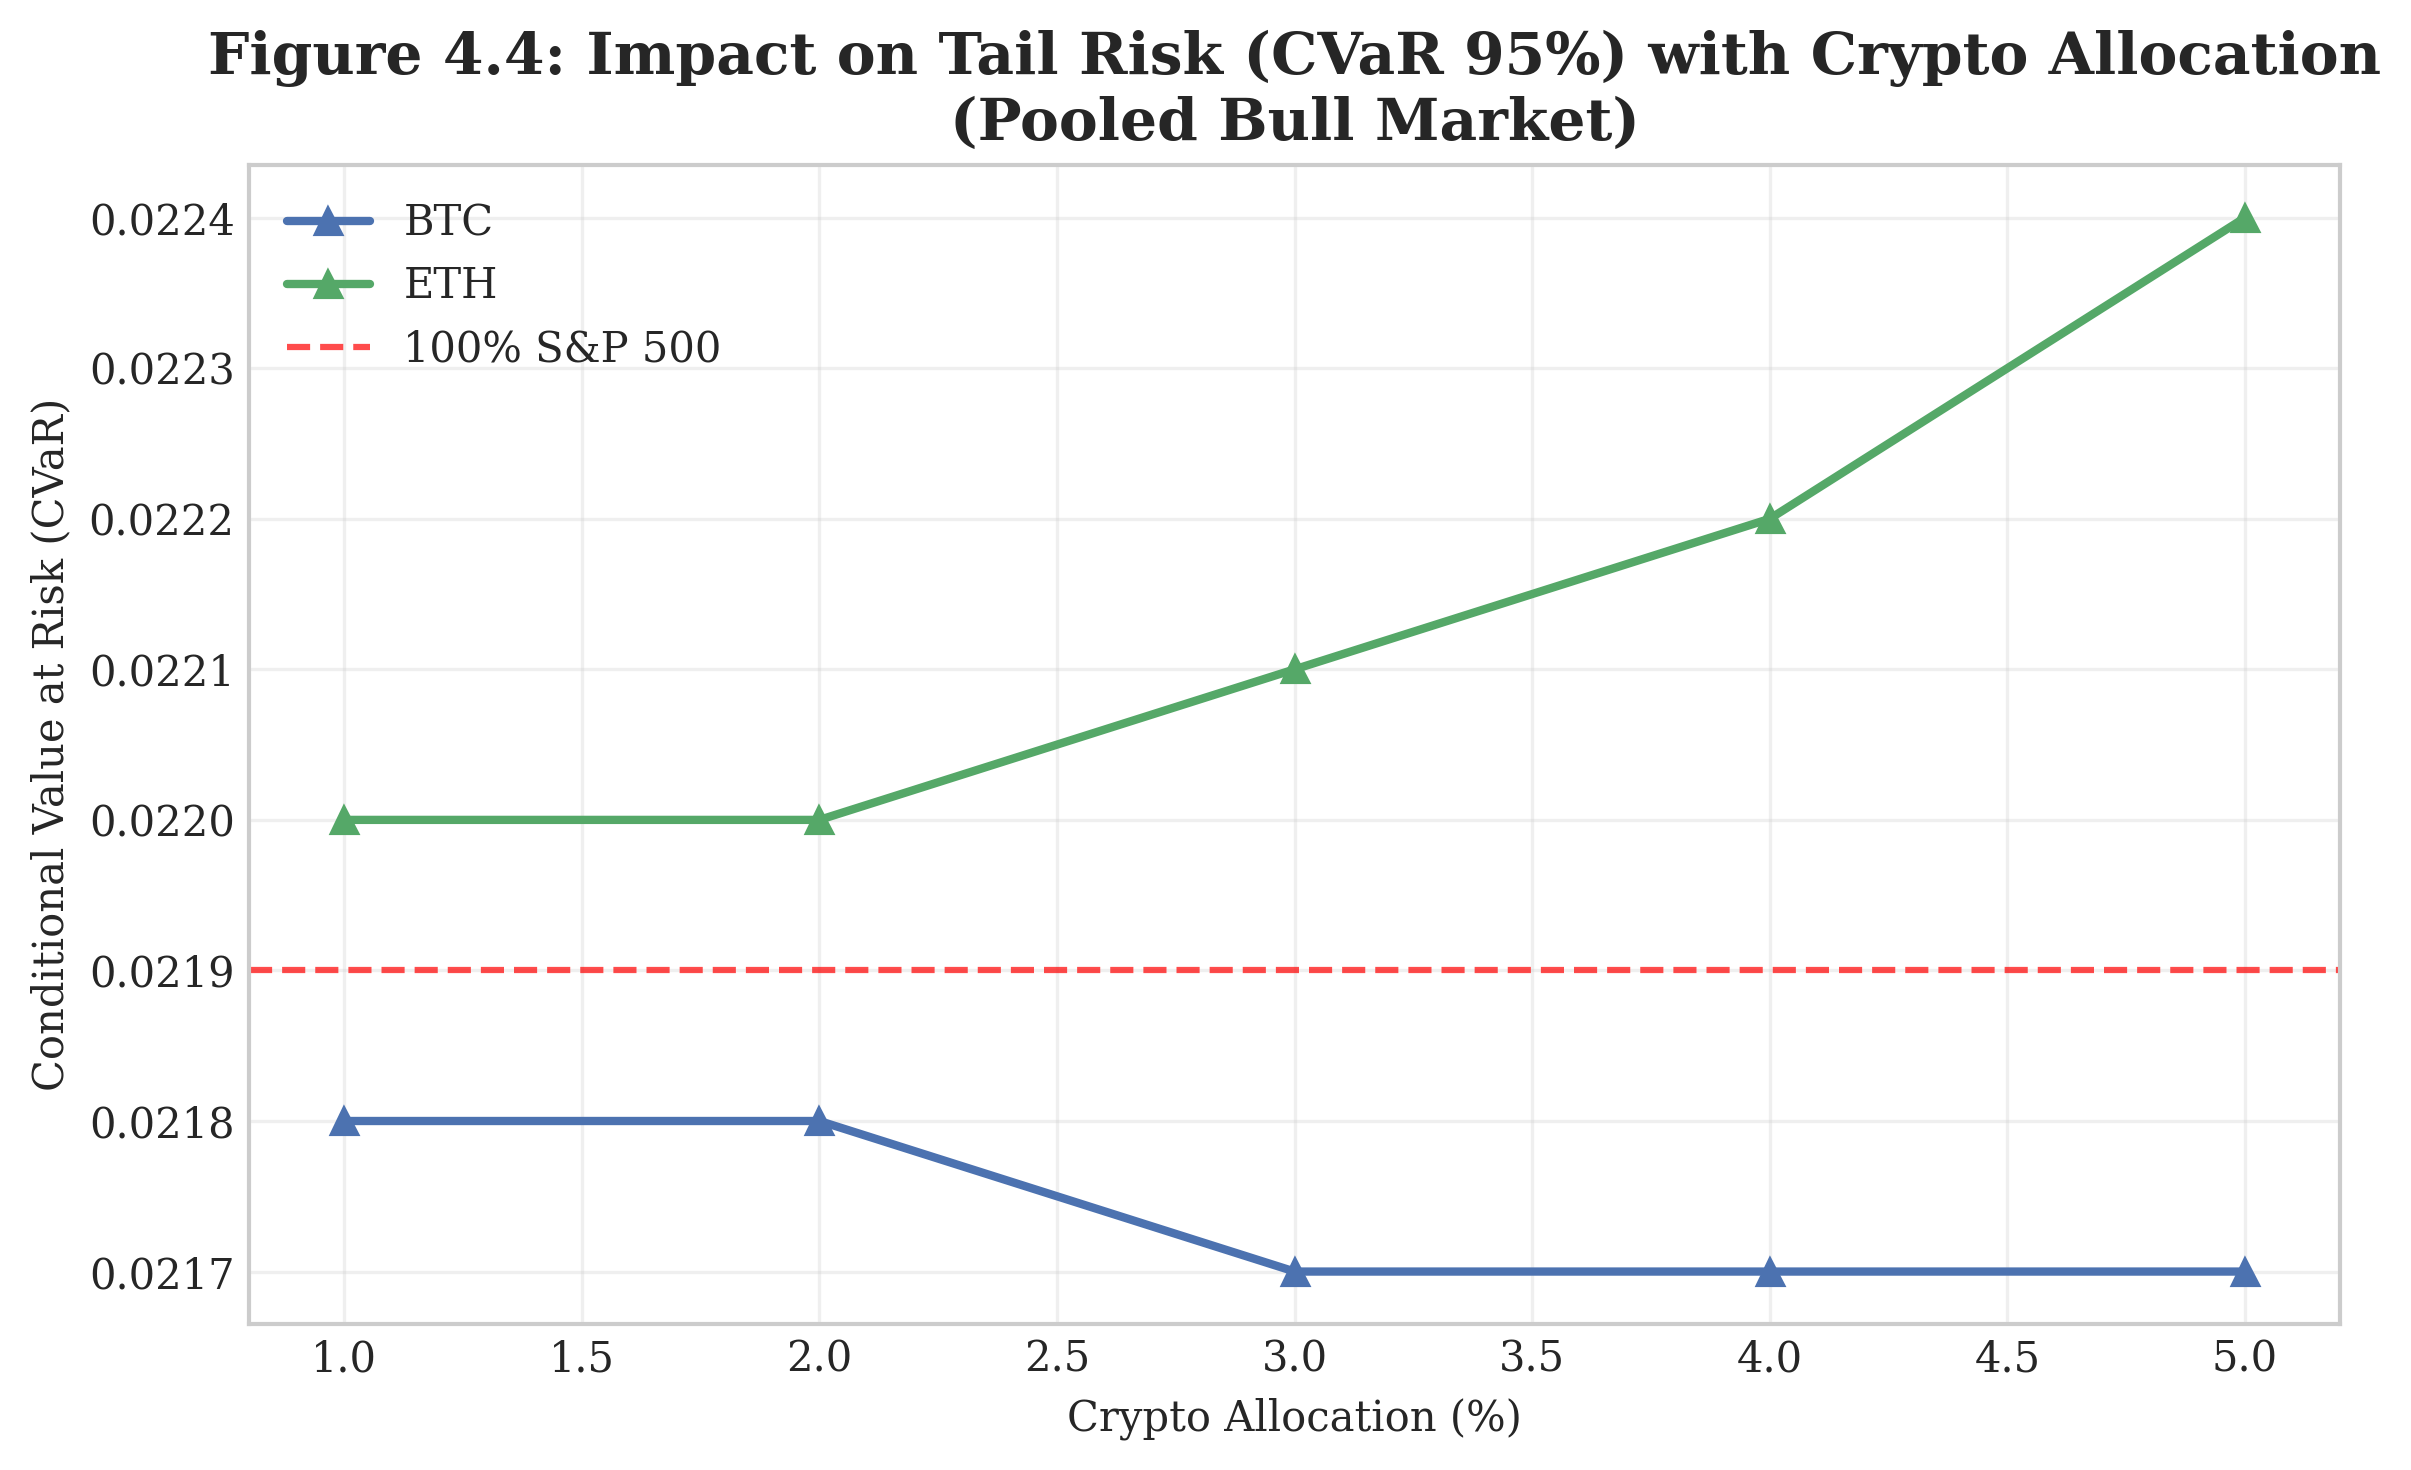

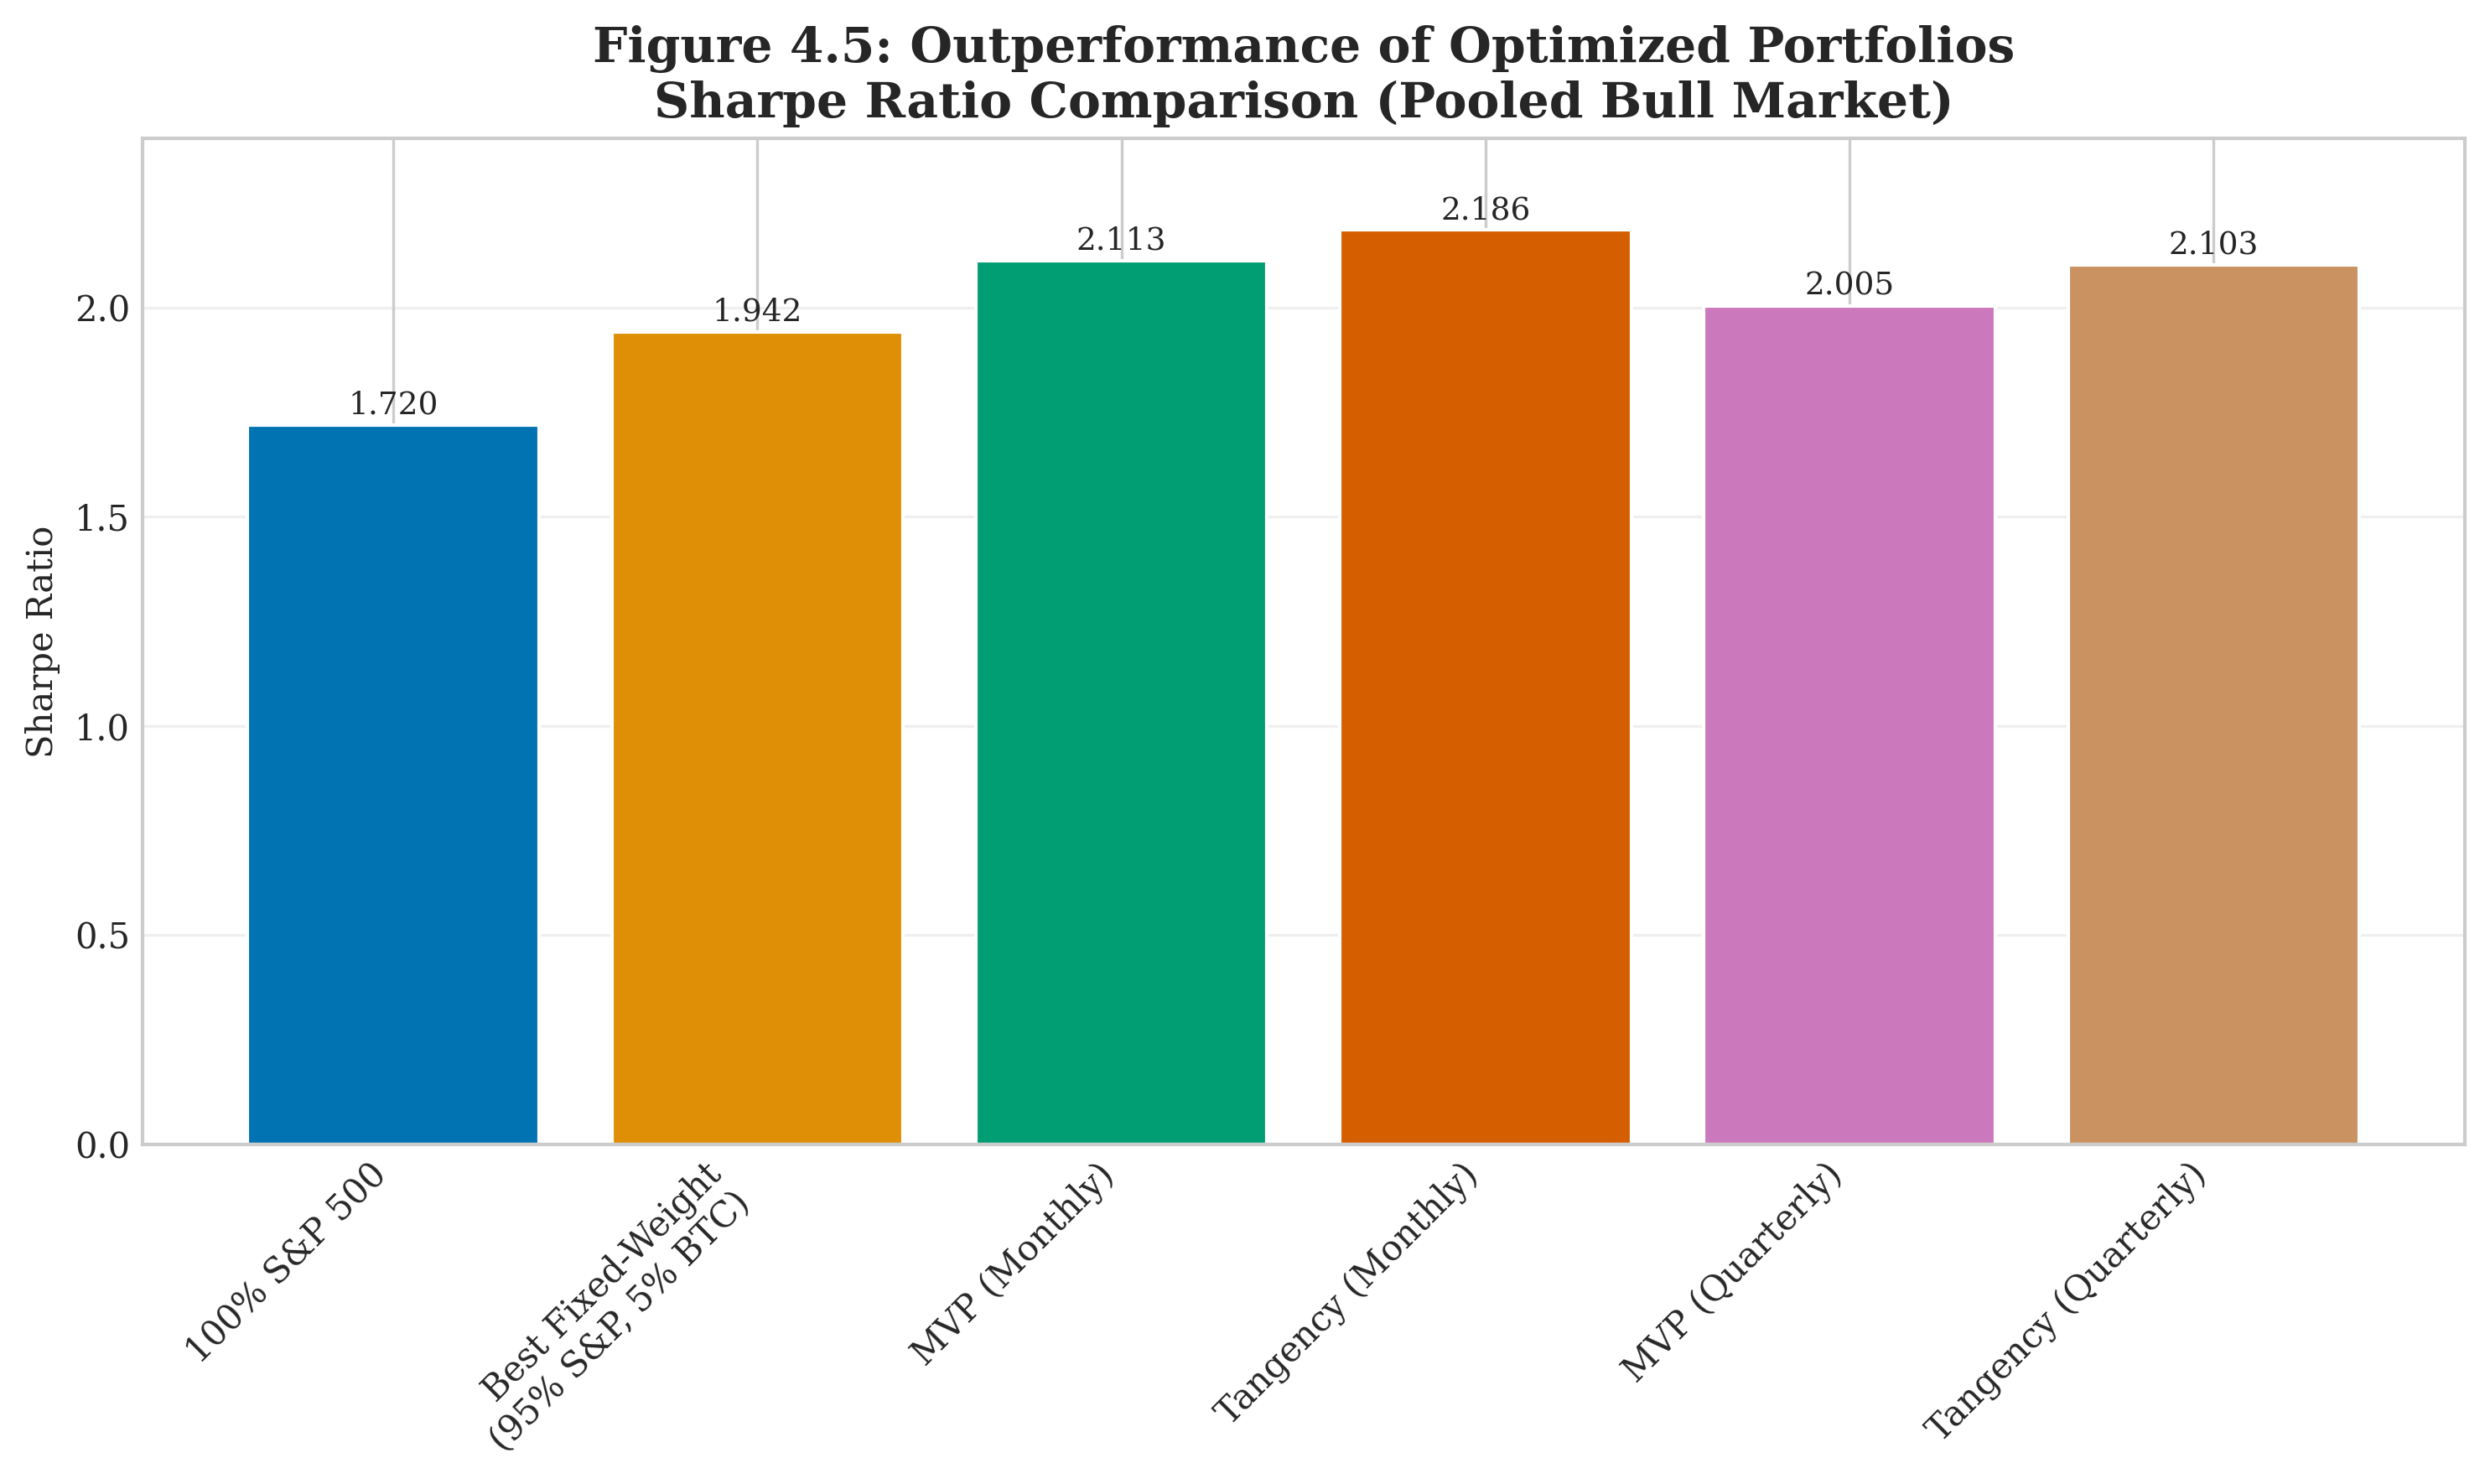

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style for academic publishing (clean and readable)
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif' # Use a serif font common in publications
plt.rcParams['figure.dpi'] = 300 # High resolution
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
colors = sns.color_palette("colorblind") # Colorblind-friendly palette

# --- Create DataFrames from your provided data ---
# Fixed-Weight Data
data_fixed = {
    'Portfolio': [
        '100% S&P 500', '99% S&P 500, 1% BTC', '98% S&P 500, 2% BTC', '97% S&P 500, 3% BTC',
        '96% S&P 500, 4% BTC', '95% S&P 500, 5% BTC', '99% S&P 500, 1% ETH',
        '98% S&P 500, 2% ETH', '97% S&P 500, 3% ETH', '96% S&P 500, 4% ETH',
        '95% S&P 500, 5% ETH', '99% S&P 500, 0.5% BTC, 0.5% ETH',
        '98% S&P 500, 1% BTC, 1% ETH', '97% S&P 500, 1.5% BTC, 1.5% ETH',
        '96% S&P 500, 2% BTC, 2% ETH', '95% S&P 500, 2.5% BTC, 2.5% ETH'
    ],
    'Sharpe Ratio': [1.7202, 1.7699, 1.8171, 1.8614, 1.9028, 1.9422, 1.7726, 1.8207,
                     1.8641, 1.9039, 1.9375, 1.7715, 1.8198, 1.8648, 1.9064, 1.9442],
    'Sortino Ratio': [3.2743, 3.3860, 3.4928, 3.5944, 3.6904, 3.7846, 3.3903, 3.4971,
                      3.5940, 3.6861, 3.7647, 3.3886, 3.4968, 3.5984, 3.6930, 3.7810],
    'CVaR 95%': [0.0219, 0.0218, 0.0218, 0.0217, 0.0217, 0.0217, 0.0220, 0.0220,
                 0.0221, 0.0222, 0.0224, 0.0219, 0.0219, 0.0219, 0.0219, 0.0220]
}
df_fixed = pd.DataFrame(data_fixed)

# Extract the allocation percentage for the x-axis
# This creates a new column 'Allocation' with values [0, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]
df_fixed['Allocation'] = df_fixed['Portfolio'].str.extract(r'(\d+)% (?:BTC|ETH)').fillna(0).astype(int)
# Create a new column 'Type' to label BTC, ETH, or Mixed portfolios
df_fixed['Type'] = 'Mixed'
df_fixed.loc[df_fixed['Portfolio'].str.contains('BTC') & ~df_fixed['Portfolio'].str.contains('ETH'), 'Type'] = 'BTC'
df_fixed.loc[df_fixed['Portfolio'].str.contains('ETH') & ~df_fixed['Portfolio'].str.contains('BTC'), 'Type'] = 'ETH'

# Optimized-Weight Data
data_optimized = {
    'Portfolio': ['MVP', 'Tangency', 'MVP', 'Tangency'],
    'Rebalancing Frequency': ['Monthly', 'Monthly', 'Quarterly', 'Quarterly'],
    'Sharpe Ratio': [2.1126, 2.1864, 2.0047, 2.1026],
    'Sortino Ratio': [4.1931, 4.4194, 3.9303, 4.1785],
    'CVaR 95%': [0.0223, 0.0255, 0.0226, 0.0255]
}
df_optimized = pd.DataFrame(data_optimized)

# --- Create Figure 4.3: Risk-Adjusted Return Ratios (Fixed-Weight) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

# Filter data for BTC and ETH only for clarity (excluding mixed)
df_filtered = df_fixed[df_fixed['Type'].isin(['BTC', 'ETH'])]

# Plot Sharpe Ratio
for key, grp in df_filtered.groupby('Type'):
    ax1.plot(grp['Allocation'], grp['Sharpe Ratio'], label=key, marker='o', linewidth=2)
ax1.axhline(y=1.7202, color='red', linestyle='--', label='100% S&P 500', alpha=0.7)
ax1.set_title('(a) Sharpe Ratio by Crypto Allocation')
ax1.set_xlabel('Crypto Allocation (%)')
ax1.set_ylabel('Sharpe Ratio')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Sortino Ratio
for key, grp in df_filtered.groupby('Type'):
    ax2.plot(grp['Allocation'], grp['Sortino Ratio'], label=key, marker='s', linewidth=2)
ax2.axhline(y=3.2743, color='red', linestyle='--', label='100% S&P 500', alpha=0.7)
ax2.set_title('(b) Sortino Ratio by Crypto Allocation')
ax2.set_xlabel('Crypto Allocation (%)')
ax2.set_ylabel('Sortino Ratio')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Figure 4.3: Enhancement of Risk-Adjusted Returns with Crypto Allocation (Pooled Bull Market)', fontweight='bold')
plt.tight_layout()
plt.savefig('figure_4_3.png', bbox_inches='tight')
plt.show()

# --- Create Figure 4.4: Tail Risk (CVaR) (Fixed-Weight) ---
plt.figure(figsize=(8, 5))

df_filtered = df_fixed[df_fixed['Type'].isin(['BTC', 'ETH'])] # Filter again for BTC/ETH

for key, grp in df_filtered.groupby('Type'):
    plt.plot(grp['Allocation'], grp['CVaR 95%'], label=key, marker='^', linewidth=2)
plt.axhline(y=0.0219, color='red', linestyle='--', label='100% S&P 500', alpha=0.7)

plt.title('Figure 4.4: Impact on Tail Risk (CVaR 95%) with Crypto Allocation\n(Pooled Bull Market)', fontweight='bold')
plt.xlabel('Crypto Allocation (%)')
plt.ylabel('Conditional Value at Risk (CVaR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figure_4_4.png', bbox_inches='tight')
plt.show()

# --- Create Figure 4.5: Optimized Portfolio Outperformance ---
# Prepare data: Select the best fixed-weight portfolio (95% S&P, 5% BTC)
best_fixed_sharpe = df_fixed[df_fixed['Portfolio'] == '95% S&P 500, 5% BTC']['Sharpe Ratio'].values[0]
baseline_sharpe = df_fixed[df_fixed['Portfolio'] == '100% S&P 500']['Sharpe Ratio'].values[0]

# Create a new DataFrame for the bar chart
comparison_data = {
    'Portfolio': ['100% S&P 500', 'Best Fixed-Weight\n(95% S&P, 5% BTC)', 'MVP (Monthly)', 'Tangency (Monthly)', 'MVP (Quarterly)', 'Tangency (Quarterly)'],
    'Sharpe Ratio': [baseline_sharpe, best_fixed_sharpe, 2.1126, 2.1864, 2.0047, 2.1026]
}
df_comparison = pd.DataFrame(comparison_data)

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(df_comparison['Portfolio'], df_comparison['Sharpe Ratio'], color=colors[0:6])

# Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.title('Figure 4.5: Outperformance of Optimized Portfolios\nSharpe Ratio Comparison (Pooled Bull Market)', fontweight='bold')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45, ha='right') # Rotate labels to prevent crowding
plt.ylim(0, max(df_comparison['Sharpe Ratio']) * 1.1) # Add some headroom for labels
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('figure_4_5.png', bbox_inches='tight')
plt.show()

#Figure 4.5: Sharpe Ratio Comparison Bar Chart
( same as previous above one)

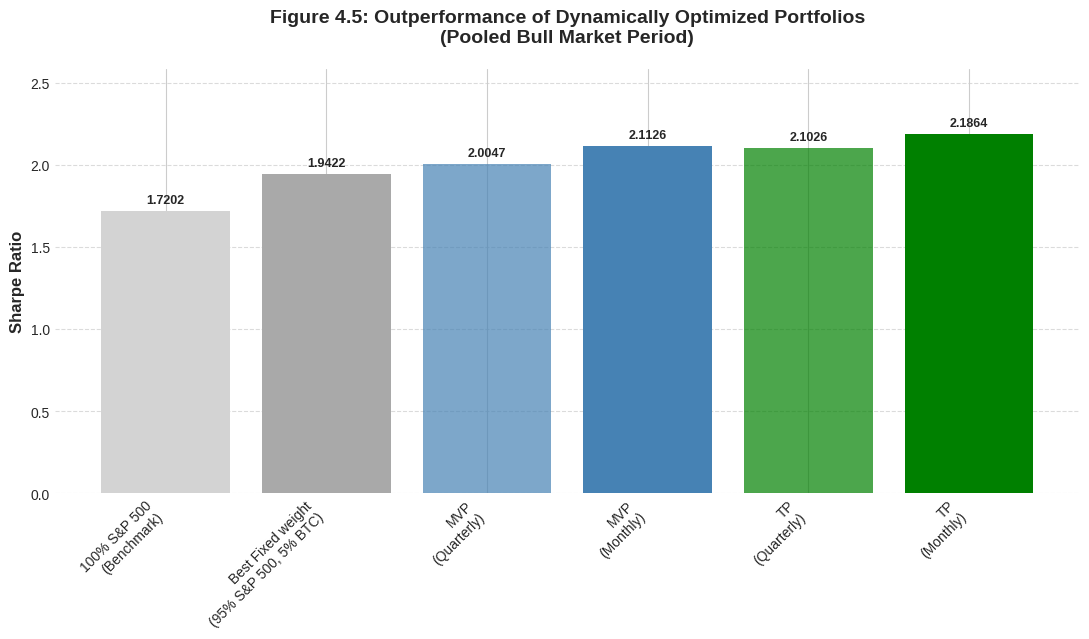

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply a professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")  # Colorblind-friendly palette

# --- DATA PREPARATION ---
# STEP 1: REPLACE THESE LISTS WITH YOUR VALUES

# We will plot a SELECTIVE set of portfolios for clarity:
# 1. The Benchmark (100% S&P 500)
# 2. The BEST Static Portfolio (from your list above)
# 3. All Optimized Portfolios (MVP Q, MVP M, TP Q, TP M)

# Define the categories for the x-axis
categories = [
    '100% S&P 500\n(Benchmark)',      # Category 0
    'Best Fixed weight\n(95% S&P 500, 5% BTC)', # Category 1 - Replace with your best one!
    'MVP\n(Quarterly)',               # Category 2
    'MVP\n(Monthly)',                 # Category 3
    'TP\n(Quarterly)',                # Category 4
    'TP\n(Monthly)'                   # Category 5
]

# Populate the Sharpe Ratio values for the categories above.
# !!! GET THESE VALUES FROM YOUR TABLES !!!
# Find the Sharpe for '95% S&P 500, 5% BTC' in your static list: it's 1.9422
sharpe_ratios = [
    1.7202,  # Benchmark (100% S&P 500)
    1.9422,  # Best Static Portfolio (e.g., 95% S&P 500, 5% BTC)
    2.0047,  # MVP (Quarterly) - From your Table 4.4
    2.1126,  # MVP (Monthly)  - From your Table 4.4
    2.1026,  # TP (Quarterly) - From your Table 4.4
    2.1864   # TP (Monthly)   - From your Table 4.4
]

# --- CREATE THE FIGURE ---
fig, ax = plt.subplots(figsize=(11, 6.5)) # Slightly larger for more categories

# Create the bar plot. We assign specific colors for clarity.
colors = ['lightgrey', 'darkgrey', 'steelblue', 'steelblue', 'green', 'green']
bars = ax.bar(categories, sharpe_ratios, color=colors)

# Differentiate the Quarterly/Monthly pairs with opacity
bars[2].set_alpha(0.7)  # MVP Quarterly
bars[3].set_alpha(1.0)  # MVP Monthly
bars[4].set_alpha(0.7)  # TP Quarterly
bars[5].set_alpha(1.0)  # TP Monthly

# --- FORMATTING ---
# Add labels and title
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Figure 4.5: Outperformance of Dynamically Optimized Portfolios\n(Pooled Bull Market Period)', fontsize=14, fontweight='bold', pad=20)

# Add value labels on top of each bar
for i, v in enumerate(sharpe_ratios):
    ax.text(i, v + 0.03, f'{v:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold') # Formatted to 4 decimals

# Adjust y-axis to start from 0 for better visual comparison
ax.set_ylim(0, max(sharpe_ratios) * 1.18) # Give a little more space for the labels

# Add a horizontal grid for easier reading
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Remove top and right spines for a cleaner look
sns.despine(left=True, bottom=True)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Ensure layout is tight so nothing is cut off
plt.tight_layout()

# --- SAVE THE FIGURE ---
# Save in high resolution for your thesis
plt.savefig('figure_4_5_optimized_vs_static_sharpe.png', dpi=300, bbox_inches='tight')
# plt.savefig('figure_4_5_optimized_vs_static_sharpe.pdf', bbox_inches='tight') # Vector format

# Display the plot
plt.show()

# Figure 4.6 Risk-Return-Turnover Trade-off

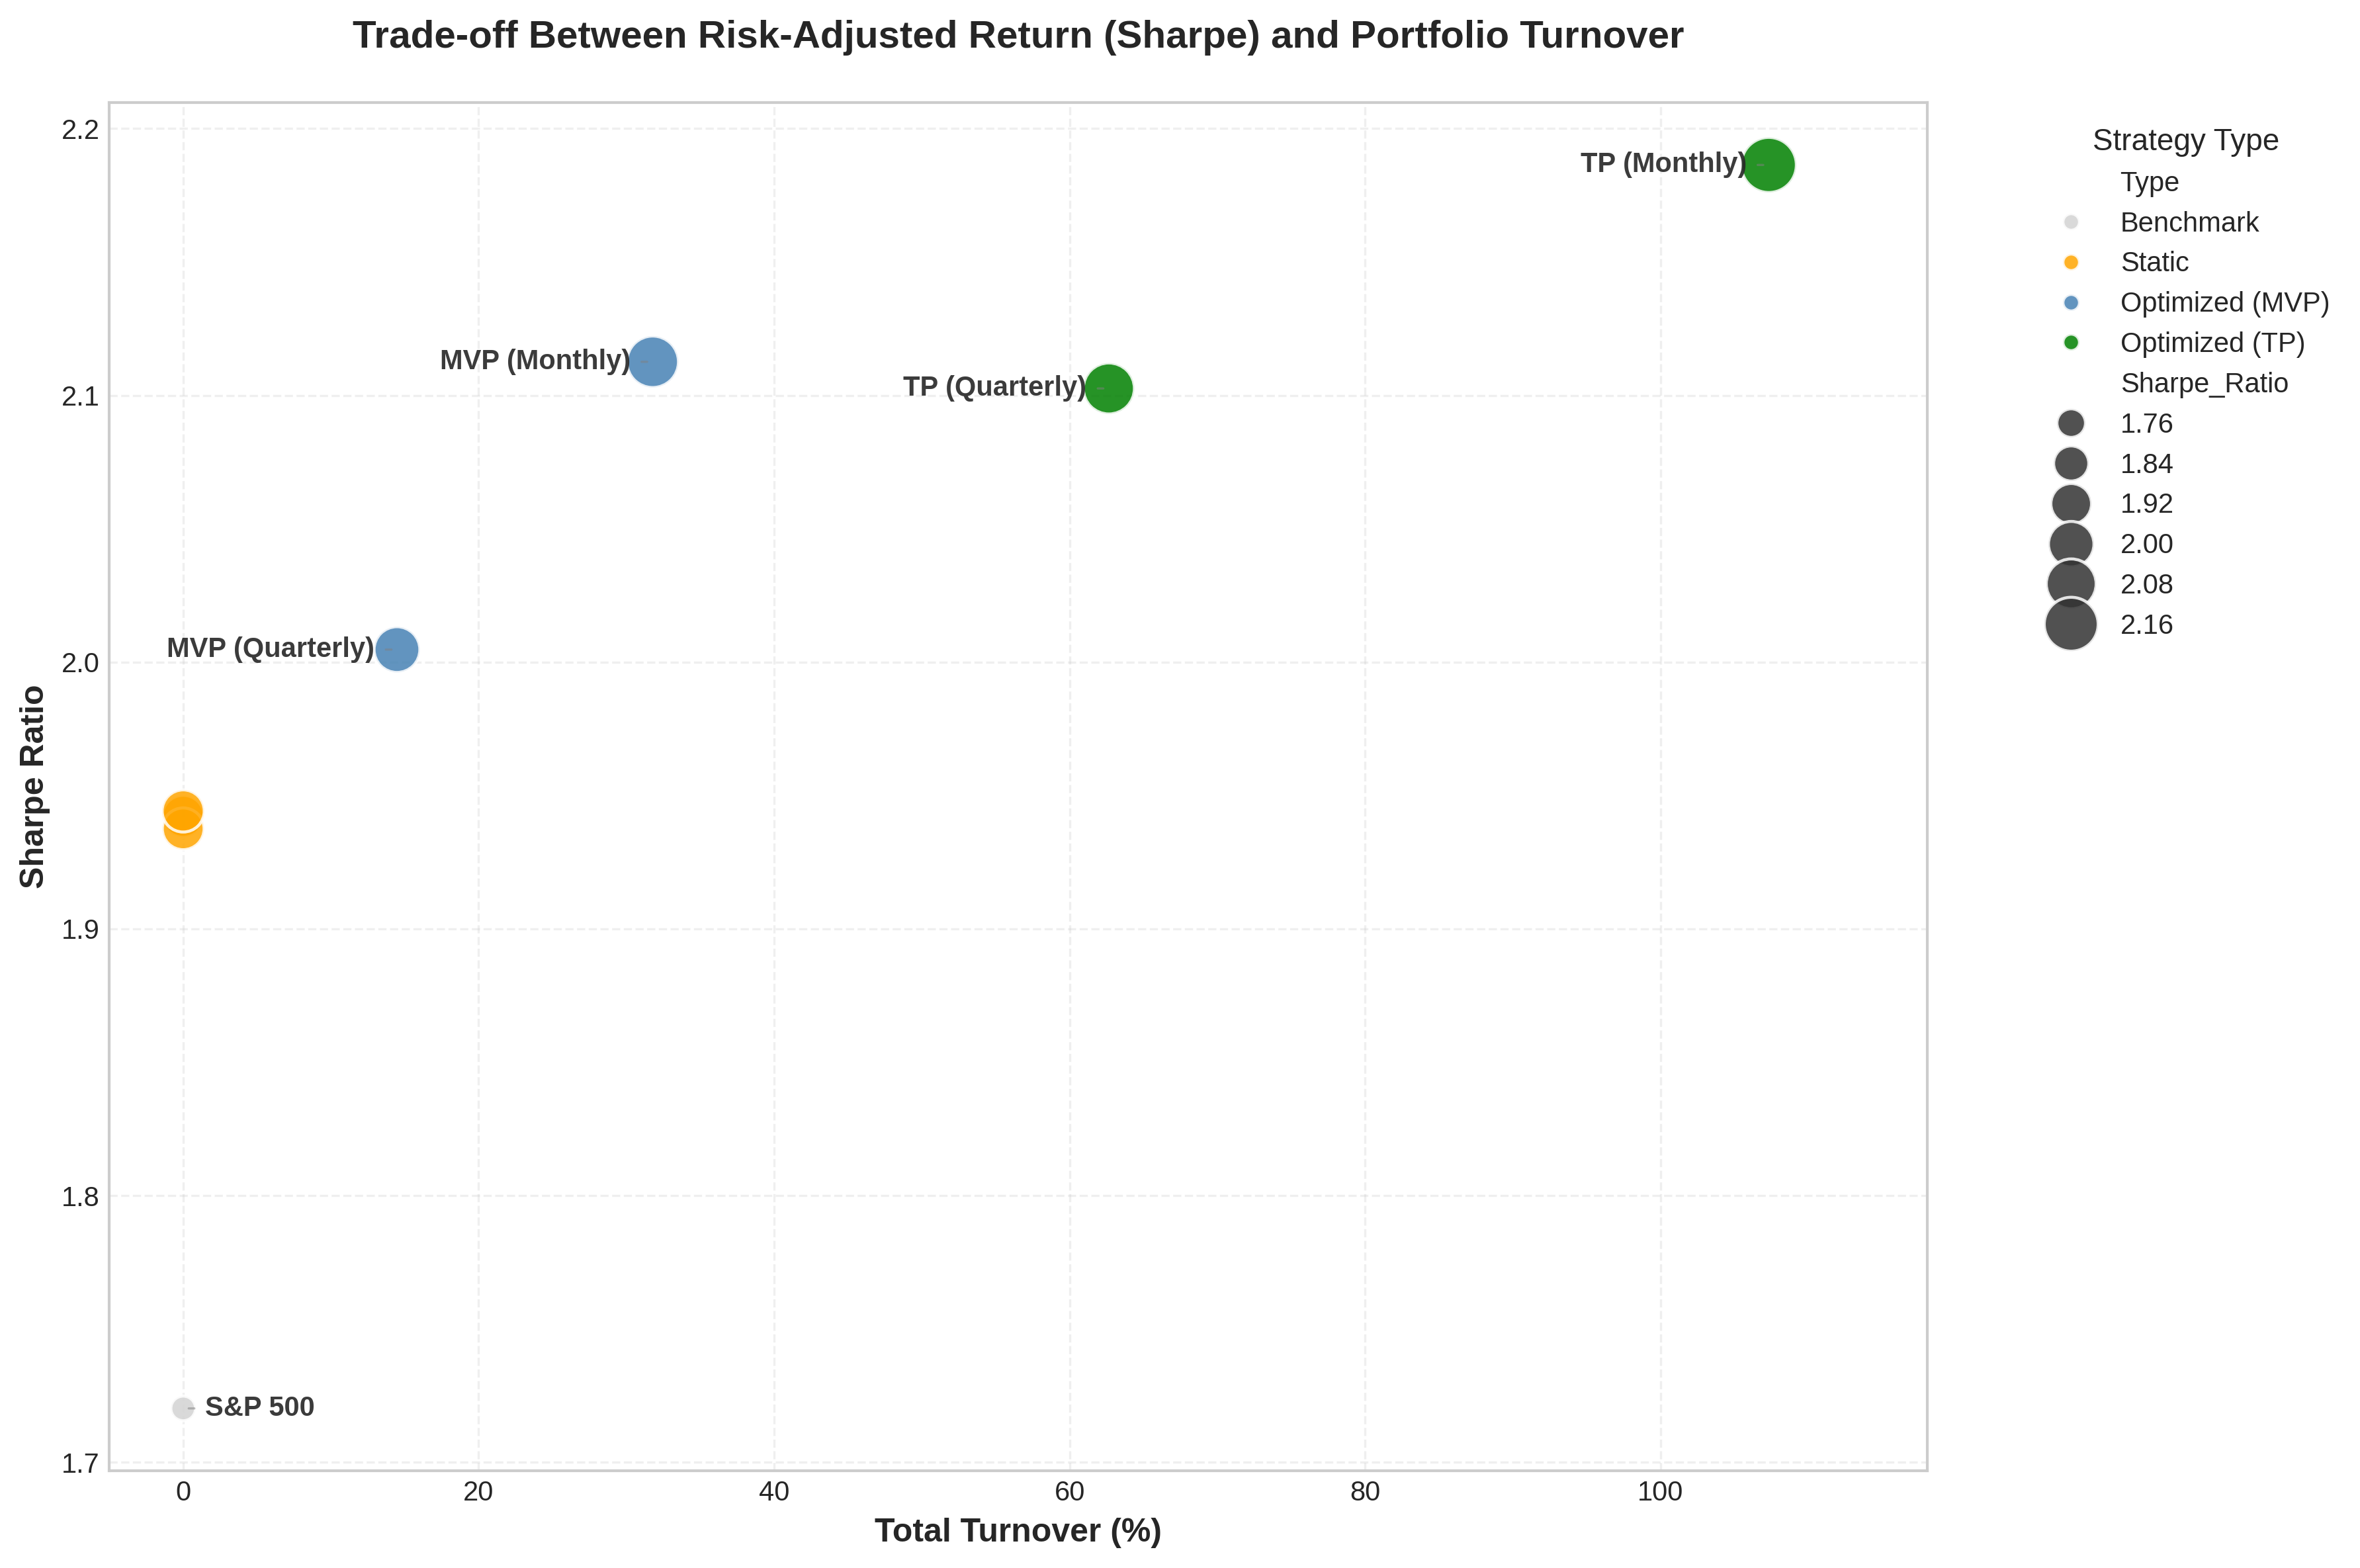

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Apply a professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")  # Colorblind-friendly palette

# --- DATA PREPARATION ---
# CREATE A DATAFRAME WITH YOUR ACTUAL RESULTS
data = {
    'Portfolio': [
        # 1. Benchmark
        'S&P 500',
        # 2. Static Portfolios (Using generic names for plotting)
        'Static 1', # This will be 95% SPY, 5% BTC
        'Static 2', # This will be 95% SPY, 5% ETH
        'Static 3', # This will be 95% SPY, 2.5% BTC, 2.5% ETH
        # 3. All Optimized Portfolios
        'MVP (Quarterly)',
        'MVP (Monthly)',
        'TP (Quarterly)',
        'TP (Monthly)'
    ],
    'Sharpe_Ratio': [
        # --- INSERT YOUR CORRECT VALUES HERE ---
        1.7202,   # S&P 500
        1.9422,   # Static 1: 95% SPY, 5% BTC
        1.9375,   # Static 2: 95% SPY, 5% ETH
        1.9442,   # Static 3: 95% SPY, 2.5% BTC, 2.5% ETH
        2.0047,   # MVP (Quarterly)
        2.1126,   # MVP (Monthly)
        2.1026,   # TP (Quarterly)
        2.1864    # TP (Monthly)
    ],
    'Total_Turnover': [
        # --- INSERT YOUR CORRECT VALUES HERE ---
        0.0,      # S&P 500 (No rebalancing)
        0.0,      # Static 1
        0.0,      # Static 2
        0.0,      # Static 3
        14.47,    # MVP (Quarterly) - From your table
        31.78,    # MVP (Monthly) - From your table
        62.66,    # TP (Quarterly) - From your table
        107.33    # TP (Monthly) - From your table
    ],
    'Type': [
        # Define the group for each portfolio
        'Benchmark',
        'Static',
        'Static',
        'Static',
        'Optimized (MVP)',
        'Optimized (MVP)',
        'Optimized (TP)',
        'Optimized (TP)'
    ]
}
df = pd.DataFrame(data)

# --- CREATE THE FIGURE ---
fig, ax = plt.subplots(figsize=(12, 8))

# Create a scatter plot. Hue=Type and Size=Sharpe_Ratio adds two layers of information.
scatter = sns.scatterplot(
    data=df,
    x='Total_Turnover',
    y='Sharpe_Ratio',
    hue='Type',
    size='Sharpe_Ratio',
    sizes=(80, 400),  # Adjust the size range for bubbles
    alpha=0.85,
    ax=ax,
    palette={
        'Benchmark': 'lightgrey',
        'Static': 'orange',
        'Optimized (MVP)': 'steelblue',
        'Optimized (TP)': 'green'
    }
)

# --- FORMATTING & ANNOTATIONS ---
# We will only annotate the Optimized portfolios and the Benchmark.
# The Static portfolios will be left as unlabeled points.

for i in range(len(df)):
    port_name = df['Portfolio'].iloc[i]
    sharpe = df['Sharpe_Ratio'].iloc[i]
    turnover = df['Total_Turnover'].iloc[i]
    port_type = df['Type'].iloc[i]

    # ONLY ANNOTATE NON-STATIC PORTFOLIOS
    if port_type != 'Static':
        if port_name == 'S&P 500':
            # Place benchmark text to the right
            ha = 'left'
            x_offset = 1.5
            y_offset = 0
            va = 'center'
        else:
            # For optimized portfolios, place text to the left
            ha = 'right'
            x_offset = -1.5
            y_offset = 0
            va = 'center'

        # Apply the annotation
        ax.annotate(port_name,
                     xy=(turnover, sharpe),
                     xytext=(turnover + x_offset, sharpe + y_offset),
                     ha=ha,
                     va=va,
                     fontsize=10,
                     fontweight='bold',
                     alpha=0.9,
                     # Optional: add an arrow for clarity
                     arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.8)
                     )

# --- AXIS AND LABEL FORMATTING ---
ax.set_xlabel('Total Turnover (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Trade-off Between Risk-Adjusted Return (Sharpe) and Portfolio Turnover', fontsize=14, fontweight='bold', pad=20)

# Improve the grid
ax.grid(True, linestyle='--', alpha=0.3)

# Move the legend to not obscure the data
ax.legend(title='Strategy Type', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize='11')


# Set x-axis to start slightly below zero to see the static portfolios clearly
ax.set_xlim(-5, max(df['Total_Turnover']) * 1.1)

# Ensure layout is clean
plt.tight_layout()

# --- SAVE THE FIGURE ---
plt.savefig('figure_tradeoff_analysis.png', dpi=300, bbox_inches='tight')
# plt.savefig('figure_tradeoff_analysis.pdf', bbox_inches='tight') # Vector format

# Display the plot
plt.show()

/tmp/ipython-input-2501225207.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Strategy Type', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize='11')


Successfully saved: figure_4_6_tradeoff_analysis.png


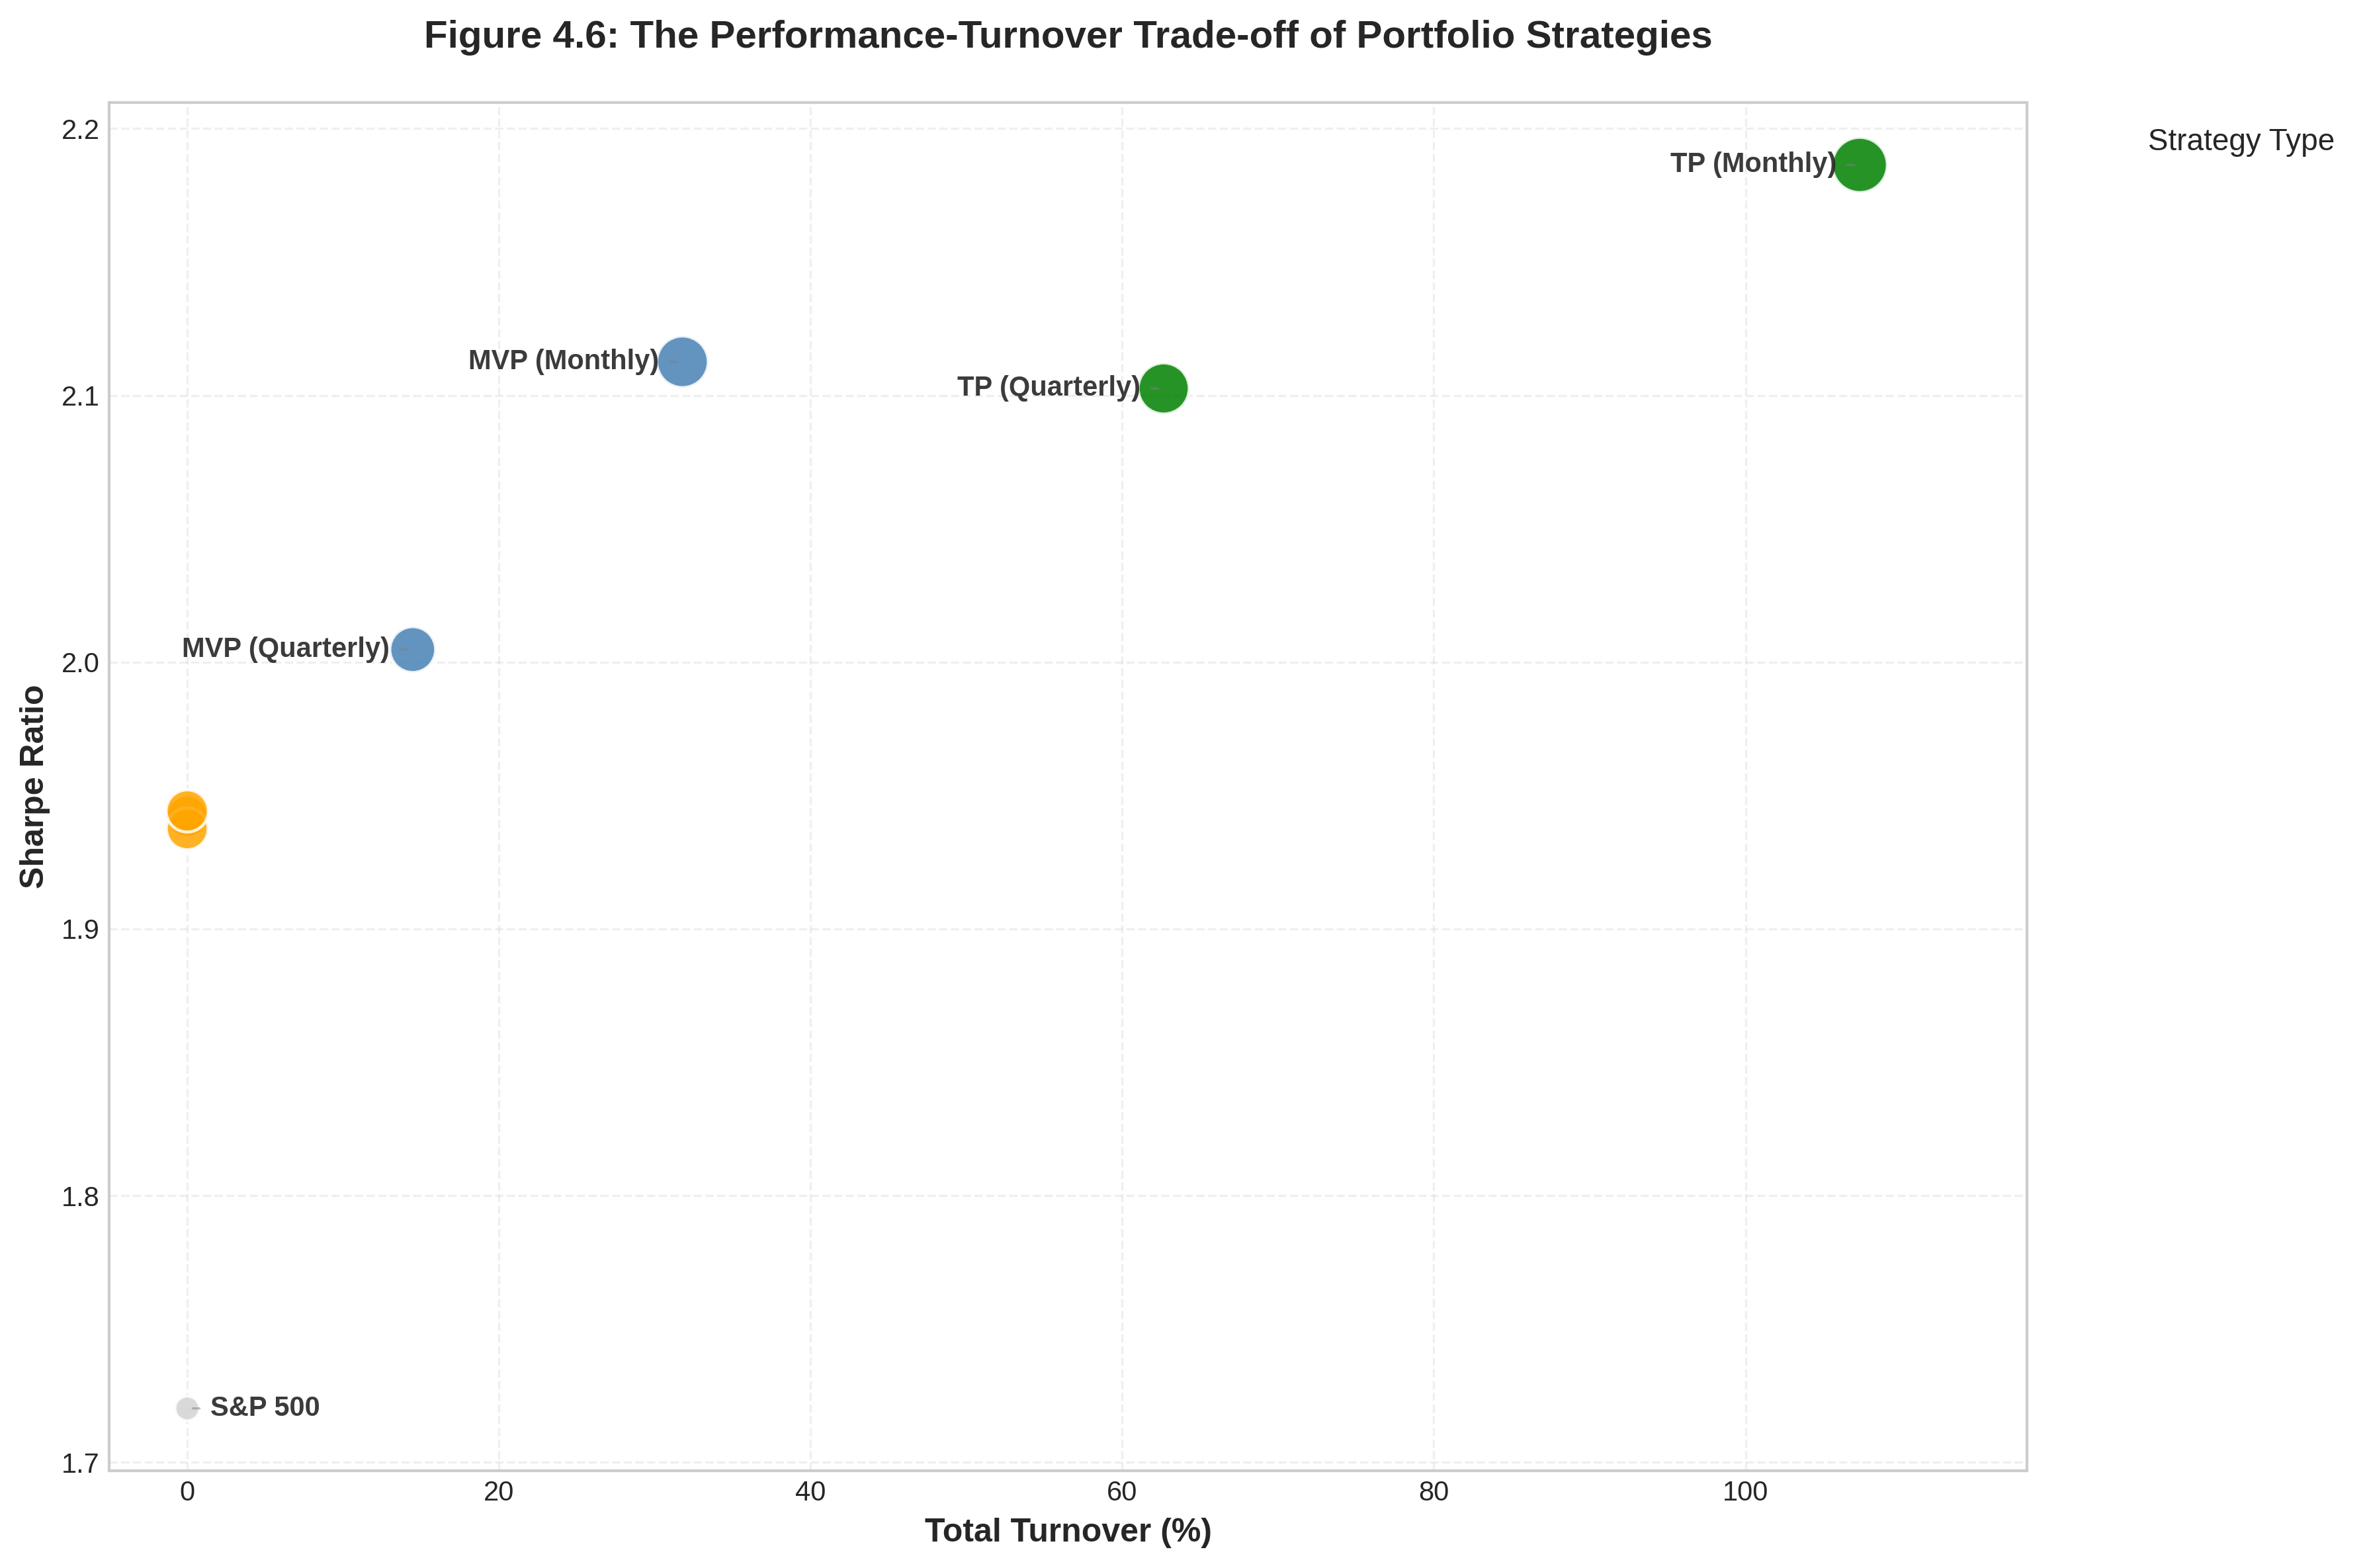

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Apply a professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")  # Colorblind-friendly palette

# --- ENHANCED SAVE FUNCTION ---
def save_plot(fig, filename, formats=['png'], dpi=300, **kwargs):
    """
    Saves matplotlib figure in multiple formats with high resolution.
    """
    for fmt in formats:
        full_filename = f"{filename}.{fmt}"
        try:
            fig.savefig(
                full_filename,
                dpi=dpi if fmt in ['png', 'jpg'] else None,
                bbox_inches='tight',
                **kwargs
            )
            print(f"Successfully saved: {full_filename}")
        except Exception as e:
            print(f"Error saving {full_filename}: {e}")

# --- DATA PREPARATION ---
# CREATE A DATAFRAME WITH YOUR ACTUAL RESULTS
data = {
    'Portfolio': [
        # 1. Benchmark
        'S&P 500',
        # 2. Static Portfolios (Using generic names for plotting)
        'Static 1', # This will be 95% SPY, 5% BTC
        'Static 2', # This will be 95% SPY, 5% ETH
        'Static 3', # This will be 95% SPY, 2.5% BTC, 2.5% ETH
        # 3. All Optimized Portfolios
        'MVP (Quarterly)',
        'MVP (Monthly)',
        'TP (Quarterly)',
        'TP (Monthly)'
    ],
    'Sharpe_Ratio': [
        # INSERT YOUR CORRECT VALUES HERE
        1.7202,   # S&P 500
        1.9422,   # Static 1: 95% SPY, 5% BTC
        1.9375,   # Static 2: 95% SPY, 5% ETH
        1.9442,   # Static 3: 95% SPY, 2.5% BTC, 2.5% ETH
        2.0047,   # MVP (Quarterly)
        2.1126,   # MVP (Monthly)
        2.1026,   # TP (Quarterly)
        2.1864    # TP (Monthly)
    ],
    'Total_Turnover': [
        # INSERT YOUR CORRECT VALUES HERE
        0.0,      # S&P 500 (No rebalancing)
        0.0,      # Static 1
        0.0,      # Static 2
        0.0,      # Static 3
        14.47,    # MVP (Quarterly)
        31.78,    # MVP (Monthly)
        62.66,    # TP (Quarterly)
        107.33    # TP (Monthly)
    ],
    'Type': [
        # Define the group for each portfolio
        'Benchmark',
        'Static',
        'Static',
        'Static',
        'Optimized (MVP)',
        'Optimized (MVP)',
        'Optimized (TP)',
        'Optimized (TP)'
    ]
}
df = pd.DataFrame(data)

# --- CREATE THE FIGURE ---
fig, ax = plt.subplots(figsize=(12, 8))

# Create a scatter plot. Hue=Type and Size=Sharpe_Ratio
scatter = sns.scatterplot(
    data=df,
    x='Total_Turnover',
    y='Sharpe_Ratio',
    hue='Type',
    size='Sharpe_Ratio',
    sizes=(80, 400),  # Adjust the size range for bubbles
    alpha=0.85,
    ax=ax,
    legend=False,  # <--- CRITICAL: This removes the size legend
    palette={
        'Benchmark': 'lightgrey',
        'Static': 'orange',
        'Optimized (MVP)': 'steelblue',
        'Optimized (TP)': 'green'
    }
)

# --- FORMATTING & ANNOTATIONS ---
# We will only annotate the Optimized portfolios and the Benchmark.
# The Static portfolios will be left as unlabeled points.

for i in range(len(df)):
    port_name = df['Portfolio'].iloc[i]
    sharpe = df['Sharpe_Ratio'].iloc[i]
    turnover = df['Total_Turnover'].iloc[i]
    port_type = df['Type'].iloc[i]

    # ONLY ANNOTATE NON-STATIC PORTFOLIOS
    if port_type != 'Static':
        if port_name == 'S&P 500':
            # Place benchmark text to the right
            ha = 'left'
            x_offset = 1.5
            y_offset = 0
            va = 'center'
        else:
            # For optimized portfolios, place text to the left
            ha = 'right'
            x_offset = -1.5
            y_offset = 0
            va = 'center'

        # Apply the annotation
        ax.annotate(port_name,
                     xy=(turnover, sharpe),
                     xytext=(turnover + x_offset, sharpe + y_offset),
                     ha=ha,
                     va=va,
                     fontsize=10,
                     fontweight='bold',
                     alpha=0.9,
                     arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.8)
                     )

# --- AXIS AND LABEL FORMATTING ---
ax.set_xlabel('Total Turnover (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Figure 4.6: The Performance-Turnover Trade-off of Portfolio Strategies', fontsize=14, fontweight='bold', pad=20)

# Improve the grid
ax.grid(True, linestyle='--', alpha=0.3)

# Move the legend to not obscure the data (only for Strategy Type)
ax.legend(title='Strategy Type', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize='11')

# Set x-axis to start slightly below zero to see the static portfolios clearly
ax.set_xlim(-5, max(df['Total_Turnover']) * 1.1)

# Ensure layout is clean
plt.tight_layout()

# --- SAVE THE FIGURE ---
save_plot(fig, 'figure_4_6_tradeoff_analysis', formats=['png'], dpi=300)

# Display the plot
plt.show()

#Figure 4.7 that shows the trend of Sharpe Ratios for the 5% allocations across all three phases

All columns in the DataFrame:
['Phase', 'Portfolio', 'Type', 'Annualized Return', 'Sharpe Ratio', 'Sortino Ratio', 'CVaR 95%', 'Turnover']

First few rows:
          Phase          Portfolio   Type  Annualized Return  Sharpe Ratio  \
0  Bull Phase 1         100% SP500  Fixed           0.291440      2.009899   
1  Bull Phase 1  99% SP500, 1% BTC  Fixed           0.301685      2.108840   
2  Bull Phase 1  98% SP500, 2% BTC  Fixed           0.317839      2.237470   
3  Bull Phase 1  97% SP500, 3% BTC  Fixed           0.320798      2.268492   
4  Bull Phase 1  96% SP500, 4% BTC  Fixed           0.326984      2.322206   

   Sortino Ratio  CVaR 95%  Turnover  
0       3.485417  0.019191         0  
1       3.695718  0.018702         0  
2       3.965816  0.018251         0  
3       4.041134  0.017962         0  
4       4.170928  0.017541         0  

Phases found in data: ['Bull Phase 1' 'Bull Phase 2' 'Bull Phase 3']

Pivoted Data for Plotting:
Phase              Bull Phase 1  Bull Phase

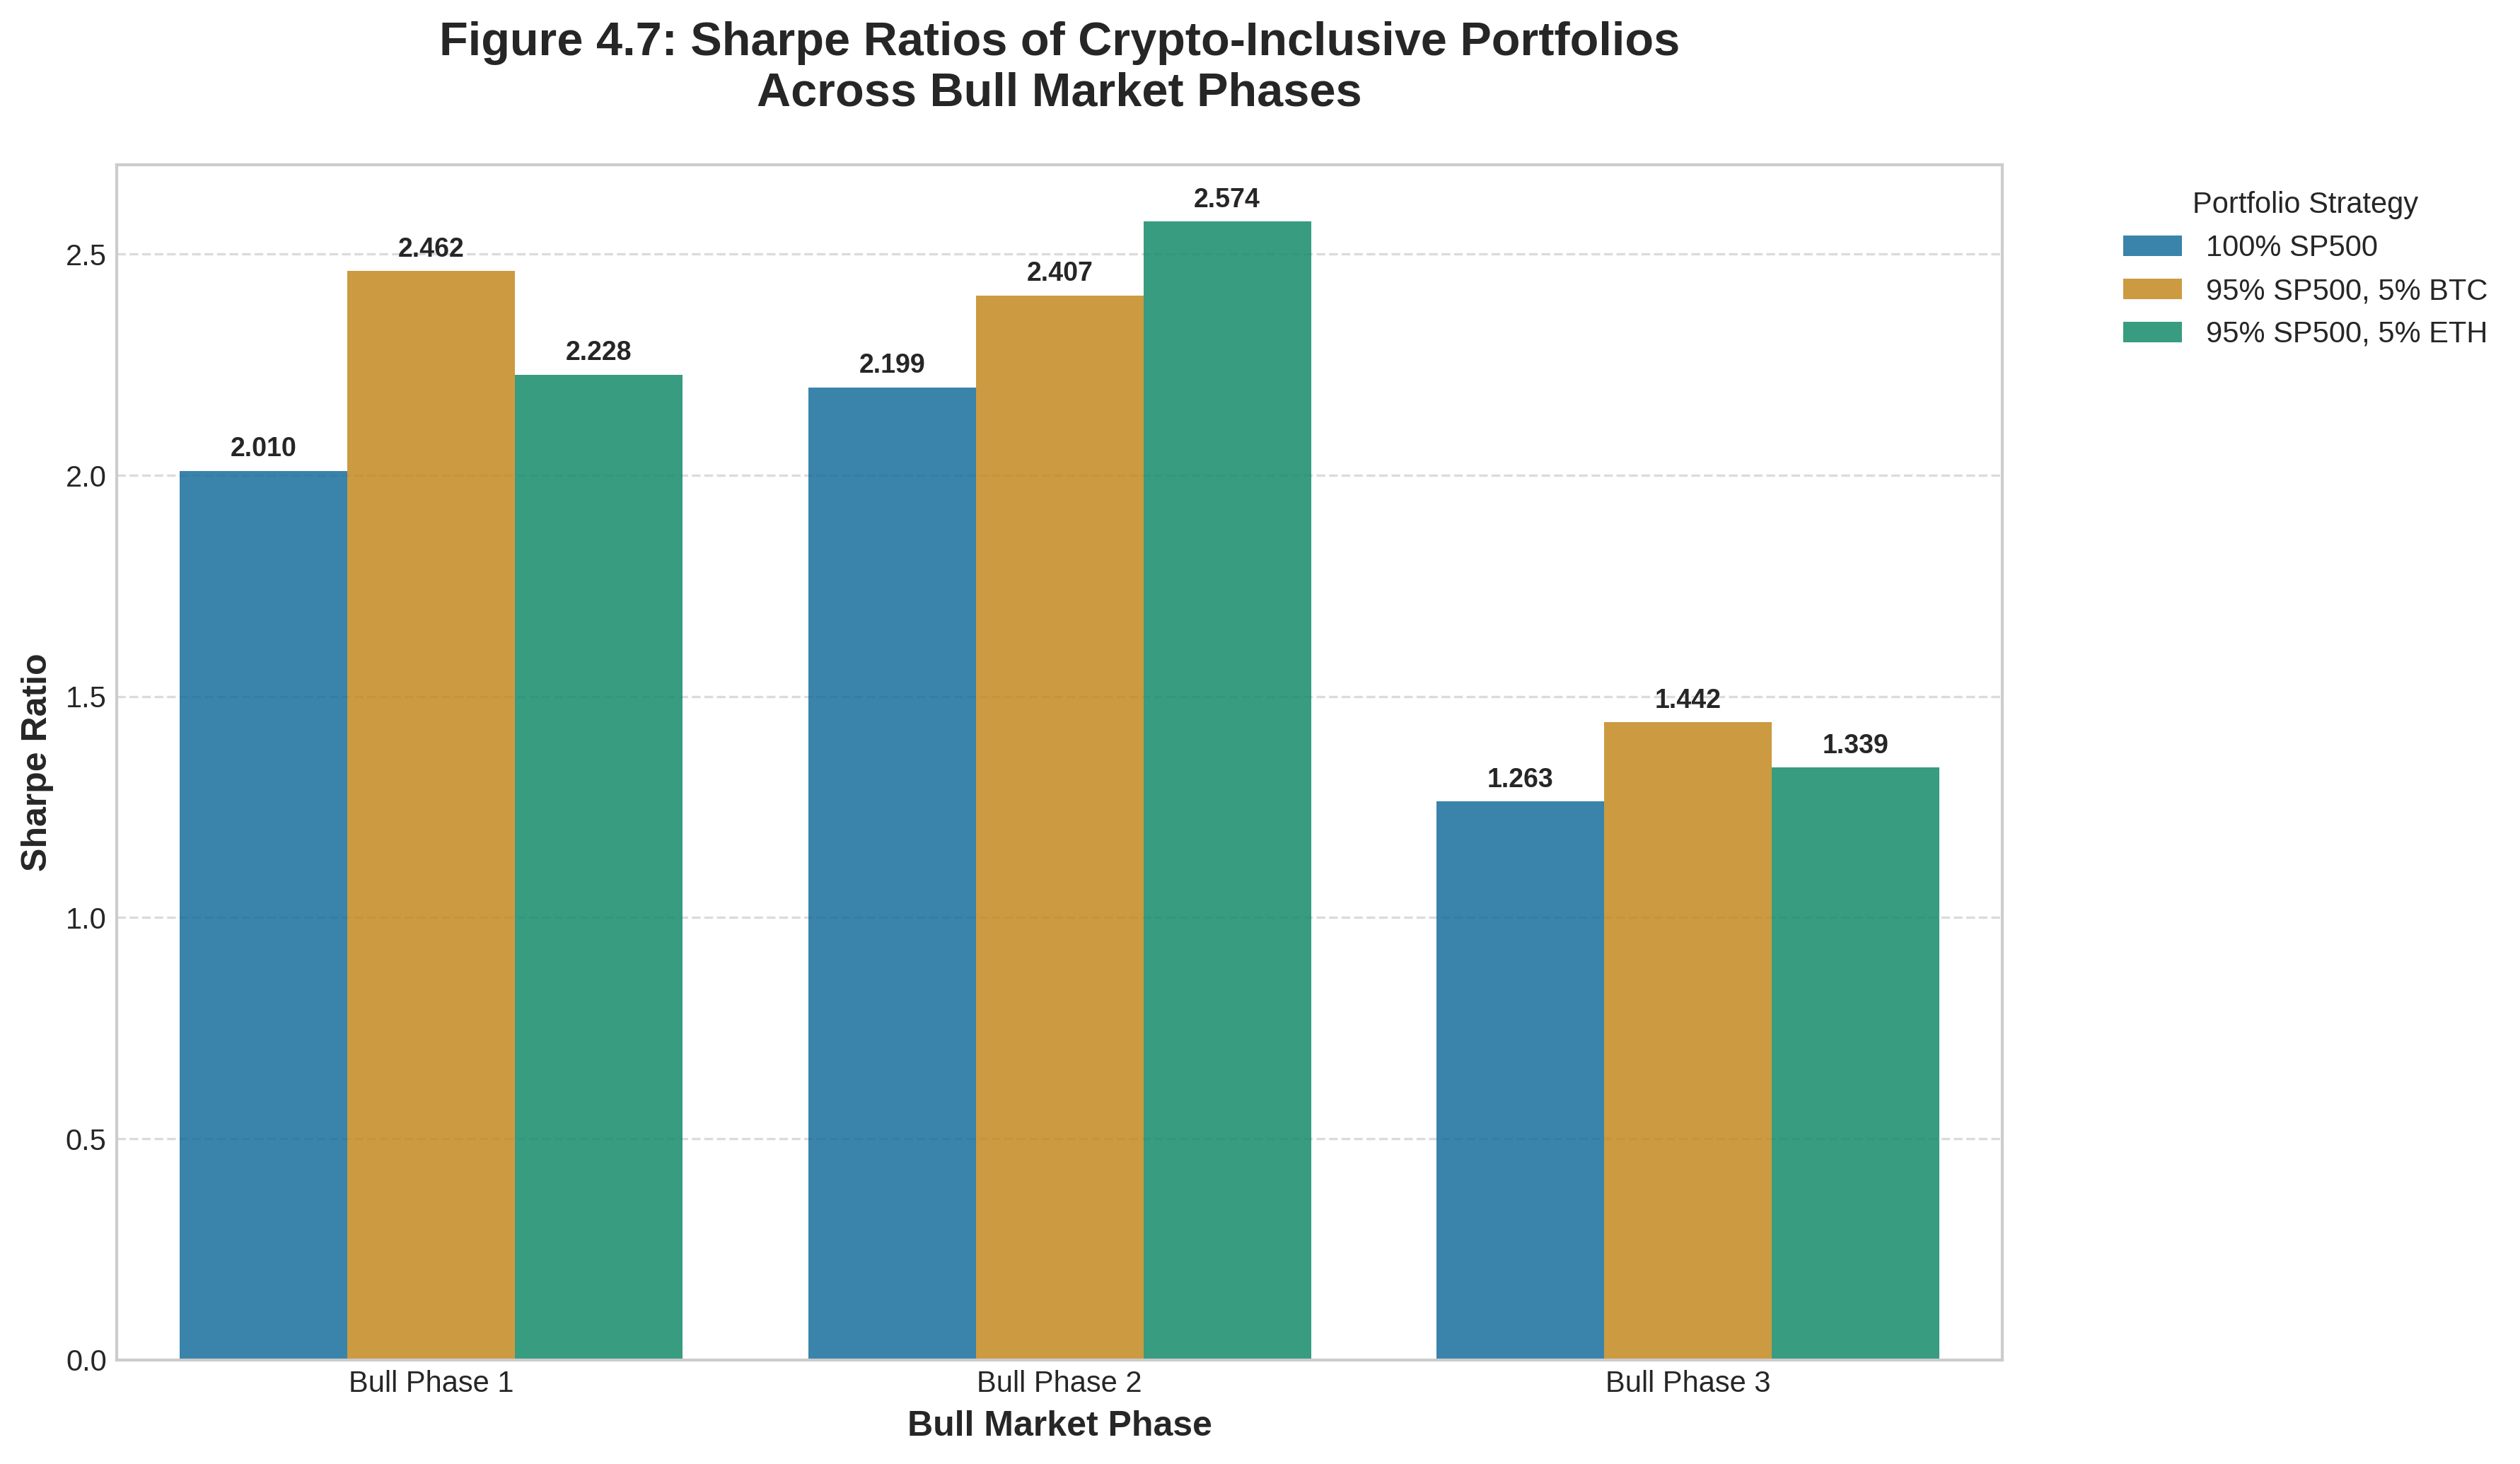


KEY VALUES FOR THESIS DISCUSSION

Phase 3 (12/10/2022 - 31/12/2024):
  100% S&P 500 Sharpe Ratio: 1.2629
  95% S&P 500, 5% BTC Sharpe Ratio: 1.4420 (Δ = +0.1791)
  95% S&P 500, 5% ETH Sharpe Ratio: 1.3392 (Δ = +0.0763)

Leadership Analysis:
  Bull Phase 1: 95% SP500, 5% BTC (2.4621)
  Bull Phase 2: 95% SP500, 5% ETH (2.5737)
  Bull Phase 3: 95% SP500, 5% BTC (1.4420)


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for academic plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")  # Colorblind-friendly palette

# --- 1. LOAD AND FILTER THE DATA ---
file_path = 'subperiod_analysis_results_final.xlsx'
df = pd.read_excel(file_path, sheet_name='Fixed_Weight_Portfolios')

# Display all columns to understand the data
print("All columns in the DataFrame:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Filter for the specific portfolios we need: Benchmark, 5% BTC, 5% ETH
selected_portfolios = [
    '100% SP500',
    '95% SP500, 5% BTC',
    '95% SP500, 5% ETH'
]

# Filter the DataFrame
df_filtered = df[df['Portfolio'].isin(selected_portfolios)].copy()

# Ensure we have all three phases
phases = df_filtered['Phase'].unique()
print(f"\nPhases found in data: {phases}")

# Pivot the table to have phases as columns and portfolios as rows for easy plotting
df_pivot = df_filtered.pivot(index='Portfolio', columns='Phase', values='Sharpe Ratio')

# Reorder the phases chronologically if needed (e.g., Phase 1, Phase 2, Phase 3)
# You might need to adjust this based on your actual phase names in the 'Phase' column
phase_order = ['Bull Phase 1', 'Bull Phase 2', 'Bull Phase 3']  # Replace with your actual phase names if different
df_pivot = df_pivot[phase_order]

print("\nPivoted Data for Plotting:")
print(df_pivot)

# --- 2. CREATE FIGURE 4.3: Sharpe Ratios Across Phases for Key Portfolios ---
# Prepare the data for plotting by resetting the index
df_plot = df_pivot.reset_index().melt(id_vars='Portfolio', var_name='Market Phase', value_name='Sharpe Ratio')

# Create the figure
fig, ax = plt.subplots(figsize=(12, 7))

# Create a bar plot
bar_plot = sns.barplot(
    data=df_plot,
    x='Market Phase',
    y='Sharpe Ratio',
    hue='Portfolio',
    alpha=0.85,
    ax=ax
)

# --- FORMATTING THE FIGURE ---
ax.set_title('Figure 4.7: Sharpe Ratios of Crypto-Inclusive Portfolios\nAcross Bull Market Phases',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Bull Market Phase', fontsize=12, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9, fontweight='bold')

# Adjust legend title and position
ax.legend(title='Portfolio Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a horizontal grid for easier reading
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Ensure layout is clean
plt.tight_layout()

# --- 3. SAVE THE FIGURE ---
plt.savefig('figure_4_7_sharpe_subperiods.png', dpi=300, bbox_inches='tight')
# plt.savefig('figure_4_7_sharpe_subperiods.pdf', bbox_inches='tight') # Vector format

# Display the plot
plt.show()

# --- 4. BONUS: Print the exact values for your thesis discussion ---
print("\n" + "="*60)
print("KEY VALUES FOR THESIS DISCUSSION")
print("="*60)

# Get values for Phase 3 discussion
phase_3_data = df_pivot['Bull Phase 3'] # Replace 'Bull Phase 3' with your actual column name if different
sp500_phase3 = phase_3_data['100% SP500']
btc_phase3 = phase_3_data['95% SP500, 5% BTC']
eth_phase3 = phase_3_data['95% SP500, 5% ETH']

print(f"\nPhase 3 (12/10/2022 - 31/12/2024):")
print(f"  100% S&P 500 Sharpe Ratio: {sp500_phase3:.4f}")
print(f"  95% S&P 500, 5% BTC Sharpe Ratio: {btc_phase3:.4f} (Δ = +{btc_phase3 - sp500_phase3:.4f})")
print(f"  95% S&P 500, 5% ETH Sharpe Ratio: {eth_phase3:.4f} (Δ = +{eth_phase3 - sp500_phase3:.4f})")

# Identify the leader in each phase
print(f"\nLeadership Analysis:")
for phase in phase_order:
    leader = df_pivot[phase].idxmax()
    print(f"  {phase}: {leader} ({df_pivot[phase][leader]:.4f})")

def save_as_png(fig, filename, dpi=300, bbox_inches='tight'):
    """
    Saves a matplotlib figure as a high-resolution PNG file.

    Parameters:
    fig (matplotlib.figure.Figure): The figure object to save.
    filename (str): The name of the file without the .png extension.
    dpi (int): Dots per inch resolution (default: 300 for high quality).
    bbox_inches (str): Bounding box setting ('tight' avoids cutting off labels).
    """
    full_filename = f"{filename}.png"
    try:
        fig.savefig(full_filename, dpi=dpi, bbox_inches=bbox_inches)
        print(f"✓ Successfully saved: {full_filename}")
    except Exception as e:
        print(f"✗ Error saving {full_filename}: {e}")